#Predicao pnad continua




In [ ]:
pip install --upgrade xlrd

In [ ]:
!pip install --upgrade pandas

In [ ]:
!pip install python-bcb

In [ ]:
!pip install pmdarima
##Solucao https://blog.csdn.net/qq_49821869/article/details/128540436
import os
os.kill(os.getpid(),9)


#Importacao das bibliotecas

In [1]:
!pip install sidrapy
import sidrapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from pmdarima import arima
import plotly.express as ploty
from datetime import datetime
from datetime import timedelta
import plotly.express as px
import plotly.graph_objs as go
import random

In [3]:
## testes de aderencia e estacionaridades
#https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [4]:
pd.options.display.float_format = '{:.2f}'.format

In [5]:
%matplotlib inline
sns.set(rc={'figure.figsize':(20,10)})

#Importandos os dados

In [6]:
data_inicio = '2000-01-01'

##Dados do SIDRA

Taxa de desocupação, na semana de referência, das pessoas de 14 anos ou mais de idade

t/6381/n1/all/v/4099/p/all/d/v4099%201

In [7]:
def converter_mes_para_data(mes):
    mes_texto = str(mes)
    ano = int(mes_texto[:4])
    mes = int(mes_texto[4:])
    data = datetime(year=ano, month=mes, day=1)
    return data

In [8]:
!pip install sidrapy
import sidrapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
taxa_desocupacao = sidrapy.get_table(table_code = '6381',
                             territorial_level = '1',
                             ibge_territorial_code = 'all',
                             variable = '4099',
                             period = 'all')
taxa_desocupacao.columns = taxa_desocupacao.iloc[0,:]
taxa_desocupacao = taxa_desocupacao.iloc[1:,:]
taxa_desocupacao['data'] = taxa_desocupacao['Trimestre Móvel (Código)'].apply(converter_mes_para_data)
taxa_desocupacao.index = taxa_desocupacao['data']
taxa_desocupacao['Valor'] = taxa_desocupacao['Valor'].astype(float)
taxa_desocupacao.head()

0          Nível Territorial (Código) Nível Territorial  \
data                                                      
2012-03-01                          1            Brasil   
2012-04-01                          1            Brasil   
2012-05-01                          1            Brasil   
2012-06-01                          1            Brasil   
2012-07-01                          1            Brasil   

0          Unidade de Medida (Código) Unidade de Medida  Valor  \
data                                                             
2012-03-01                          2                 %   8.00   
2012-04-01                          2                 %   7.80   
2012-05-01                          2                 %   7.70   
2012-06-01                          2                 %   7.60   
2012-07-01                          2                 %   7.50   

0          Brasil (Código)  Brasil Trimestre Móvel (Código)   Trimestre Móvel  \
data                                                                            
2012-03-01               1  Brasil                   201203  jan-fev-mar 2012   
2012-04-01               1  Brasil                   201204  fev-mar-abr 2012   
2012-05-01               1  Brasil                   201205  mar-abr-mai 2012   
2012-06-01               1  Brasil                   201206  abr-mai-jun 2012   
2012-07-01               1  Brasil                   201207  mai-jun-jul 2012   

0          Variável (Código)  \
data                           
2012-03-01              4099   
2012-04-01              4099   
2012-05-01              4099   
2012-06-01              4099   
2012-07-01              4099   

0                                                    Variável       data  
data                                                                      
2012-03-01  Taxa de desocupação, na semana de referência, ... 2012-03-01  
2012-04-01  Taxa de desocupação, na semana de referência, ... 2012-04-01  
2012-05-01  Taxa de desocupação, na semana de referência, ... 2012-05-01  
2012-06-01  Taxa de desocupação, na semana de referência, ... 2012-06-01  
2012-07-01  Taxa de desocupação, na semana de referência, ... 2012-07-01

In [10]:
taxa_desocupacao.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 130 entries, 2012-03-01 to 2022-12-01
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Nível Territorial (Código)  130 non-null    object        
 1   Nível Territorial           130 non-null    object        
 2   Unidade de Medida (Código)  130 non-null    object        
 3   Unidade de Medida           130 non-null    object        
 4   Valor                       130 non-null    float64       
 5   Brasil (Código)             130 non-null    object        
 6   Brasil                      130 non-null    object        
 7   Trimestre Móvel (Código)    130 non-null    object        
 8   Trimestre Móvel             130 non-null    object        
 9   Variável (Código)           130 non-null    object        
 10  Variável                    130 non-null    object        
 11  data                        130 non-nul

##Dados Fgv

link para pegar os dados:https://extra-ibre.fgv.br/IBRE/sitefgvdados/default.aspx


In [11]:
def converter_data(data):
    data_texto = data.split('/')
    ano = int(data_texto[1])
    mes = int(data_texto[0])
    data = datetime(year=ano, month=mes, day=1)
    return data

In [12]:
dados_fgv = pd.read_excel('/content/xgvxConsulta.xls',skiprows=14).iloc[:,:3]
dados_fgv.index = dados_fgv['Data'].apply(converter_data)
dados_fgv.drop('Data',axis=1,inplace=True)
dados_fgv.columns = ['Indicador de Incerteza da Economia Brasileira','Indicador Antecedente de Emprego']
dados_fgv['Indicador Antecedente de Emprego'] = pd.to_numeric(dados_fgv['Indicador Antecedente de Emprego'], errors='coerce')
dados_fgv.head()

Indicador de Incerteza da Economia Brasileira  \
Data                                                        
2000-01-01                                          85.80   
2000-02-01                                          86.10   
2000-03-01                                          85.00   
2000-04-01                                          86.30   
2000-05-01                                          85.10   

            Indicador Antecedente de Emprego  
Data                                          
2000-01-01                               NaN  
2000-02-01                               NaN  
2000-03-01                               NaN  
2000-04-01                               NaN  
2000-05-01                               NaN

##Dados google

In [13]:
!pip install pytrends 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
try:
  from pytrends.request import TrendReq
  import pandas as pd
  import time

  # Definindo os termos de pesquisa
  kw_list = ['seguro desemprego', 'empregos','FGTS','INSS']

  # Definindo as datas de início e fim da pesquisa
  start_date = '2004-01-01'
  end_date = str(date.today())

  # Dividindo a pesquisa em vários períodos de 5 anos
  periods = pd.date_range(start=start_date, end=end_date, freq='5Y')
  if periods[-1] < pd.to_datetime(end_date):
    periods = periods.append(pd.Index([pd.to_datetime(end_date)]))

  # Criando uma instância do TrendReq
  pytrends = TrendReq()

  # Fazendo a pesquisa para cada período de 5 anos
  data = pd.DataFrame()

  for i in range(len(periods)-1):
    timeframe = f"{periods[i].strftime('%Y-%m-%d')} {periods[i+1].strftime('%Y-%m-%d')}"
    pytrends.build_payload(kw_list, timeframe=timeframe)
    temp_data = pytrends.interest_over_time()
    data = pd.concat([data, temp_data])

    # Aguardando alguns segundos para evitar sobrecarga no servidor do Google Trends
    time.sleep(20)

  data = data.resample('MS').sum()
  # Imprimindo os resultados em uma célula
  data
except:
  data = pd.read_csv('/content/dados_google.csv')
  data.index = pd.to_datetime(data['date'])
  data.drop(['Unnamed: 0','date'],axis=1,inplace=True)

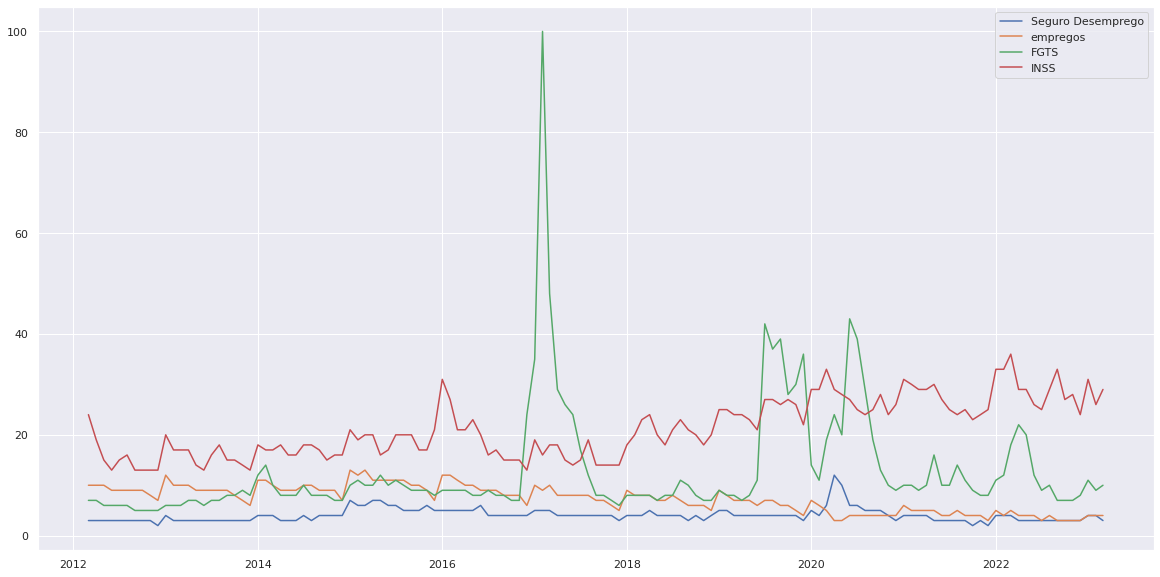

In [18]:
plt.plot(data.index,data['seguro desemprego'],label='Seguro Desemprego')
plt.plot(data.index,data['empregos'],label='empregos')
plt.plot(data.index,data['FGTS'],label='FGTS')
plt.plot(data.index,data['INSS'],label='INSS')
plt.legend();

##Dados do Banco Central

Índice de Atividade Econômica do Banco Central (IBC-Br) com ajuste sazonal = 24364

Taxa de juros Selic acumulada no mês anualizada base 252= 4189

In [19]:
!pip install python-bcb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
from bcb import sgs
dados_banco_central = sgs.get({'ibc':24364,'selic':4189}, start = data_inicio)
dados_banco_central.head()

ibc  selic
Date                  
2000-01-01  NaN  18.94
2000-02-01  NaN  18.87
2000-03-01  NaN  18.85
2000-04-01  NaN  18.62
2000-05-01  NaN  18.51

##Juntando os dados

In [21]:
data_fre = pd.date_range(data_inicio,datetime.today().strftime('%Y-%m-%d'),freq='MS')
dados = pd.DataFrame(index=data_fre)

In [22]:
dados['taxa_desocupacao'] = taxa_desocupacao['Valor']
dados['Indicador de Incerteza da Economia Brasileira'] = dados_fgv['Indicador de Incerteza da Economia Brasileira']
dados['Indicador Antecedente de Emprego'] = dados_fgv['Indicador Antecedente de Emprego']
dados['seguro_desemprego'] = data['seguro desemprego']
dados['fgts'] = data['FGTS']
dados['empregos'] = data['empregos']
dados['inss'] = data['INSS']
dados['ibc'] =dados_banco_central['ibc']
dados['selic'] = dados_banco_central['selic']
#Pegando o primeira data valida da taxa de desocupacao
dados = dados[dados.index >= dados['taxa_desocupacao'].first_valid_index()]
dados.head()

taxa_desocupacao  Indicador de Incerteza da Economia Brasileira  \
2012-03-01              8.00                                          95.40   
2012-04-01              7.80                                          97.80   
2012-05-01              7.70                                         101.60   
2012-06-01              7.60                                         106.30   
2012-07-01              7.50                                         105.60   

            Indicador Antecedente de Emprego  seguro_desemprego  fgts  \
2012-03-01                             88.20               3.00  7.00   
2012-04-01                             88.70               3.00  7.00   
2012-05-01                             87.70               3.00  6.00   
2012-06-01                             85.70               3.00  6.00   
2012-07-01                             84.40               3.00  6.00   

            empregos  inss    ibc  selic  
2012-03-01     10.00 24.00 140.03   9.82  
2012-04-01     10.00 19.00 140.91   9.35  
2012-05-01     10.00 15.00 142.47   8.87  
2012-06-01      9.00 13.00 143.48   8.39  
2012-07-01      9.00 15.00 143.91   8.07


#Tratando os dados

##Criando dummy Covid para as 2020-04-01 e 2020-05-01

In [23]:
dados['dummy_covid'] = np.where((dados.index >= pd.to_datetime('2020-04-01')) & (dados.index <= pd.to_datetime('2020-05-01')), 1,0)
dados

taxa_desocupacao  Indicador de Incerteza da Economia Brasileira  \
2012-03-01              8.00                                          95.40   
2012-04-01              7.80                                          97.80   
2012-05-01              7.70                                         101.60   
2012-06-01              7.60                                         106.30   
2012-07-01              7.50                                         105.60   
...                      ...                                            ...   
2022-11-01              8.10                                         112.10   
2022-12-01              7.90                                         112.70   
2023-01-01               NaN                                         113.30   
2023-02-01               NaN                                         111.70   
2023-03-01               NaN                                            NaN   

            Indicador Antecedente de Emprego  seguro_desemprego  fgts  \
2012-03-01                             88.20               3.00  7.00   
2012-04-01                             88.70               3.00  7.00   
2012-05-01                             87.70               3.00  6.00   
2012-06-01                             85.70               3.00  6.00   
2012-07-01                             84.40               3.00  6.00   
...                                      ...                ...   ...   
2022-11-01                             73.10               3.00  7.00   
2022-12-01                             74.70               3.00  8.00   
2023-01-01                             73.90               4.00 11.00   
2023-02-01                             74.72               4.00  9.00   
2023-03-01                               NaN               3.00 10.00   

            empregos  inss    ibc  selic  dummy_covid  
2012-03-01     10.00 24.00 140.03   9.82            0  
2012-04-01     10.00 19.00 140.91   9.35            0  
2012-05-01     10.00 15.00 142.47   8.87            0  
2012-06-01      9.00 13.00 143.48   8.39            0  
2012-07-01      9.00 15.00 143.91   8.07            0  
...              ...   ...    ...    ...          ...  
2022-11-01      3.00 28.00 142.54  13.65            0  
2022-12-01      3.00 24.00 142.95  13.65            0  
2023-01-01      4.00 31.00    NaN  13.65            0  
2023-02-01      4.00 26.00    NaN  13.65            0  
2023-03-01      4.00 29.00    NaN  13.65            0  

[133 rows x 10 columns]

##Estacionaridade
A TS é dita estacionária se as suas propriedades estatísticas, tais como a média e variância permanecem constantes ao longo do tempo. Mas por que isso é importante? A maioria dos modelos TS trabalha com o pressuposto de que a TS é estacionária. Intuitivamente, podemos entender que se uma TS tem um comportamento particular ao longo de um tempo, há uma probabilidade muito elevada de que seguirá o mesmo comportamento no futuro. Além disso, as teorias relacionadas com séries estacionárias são mais maduras e mais fáceis de implementar, em comparação com séries não-estacionárias.

https://www.vooo.pro/insights/guia-completo-para-criar-time-series-com-codigo-em-python/

In [24]:
def plotar(dados):
  for i in range(len(dados.columns)):
    fig, ax = plt.subplots(dpi=120)
    ax.plot(dados.iloc[:,i],label=dados.columns[i])
    plt.legend()
    plt.show()

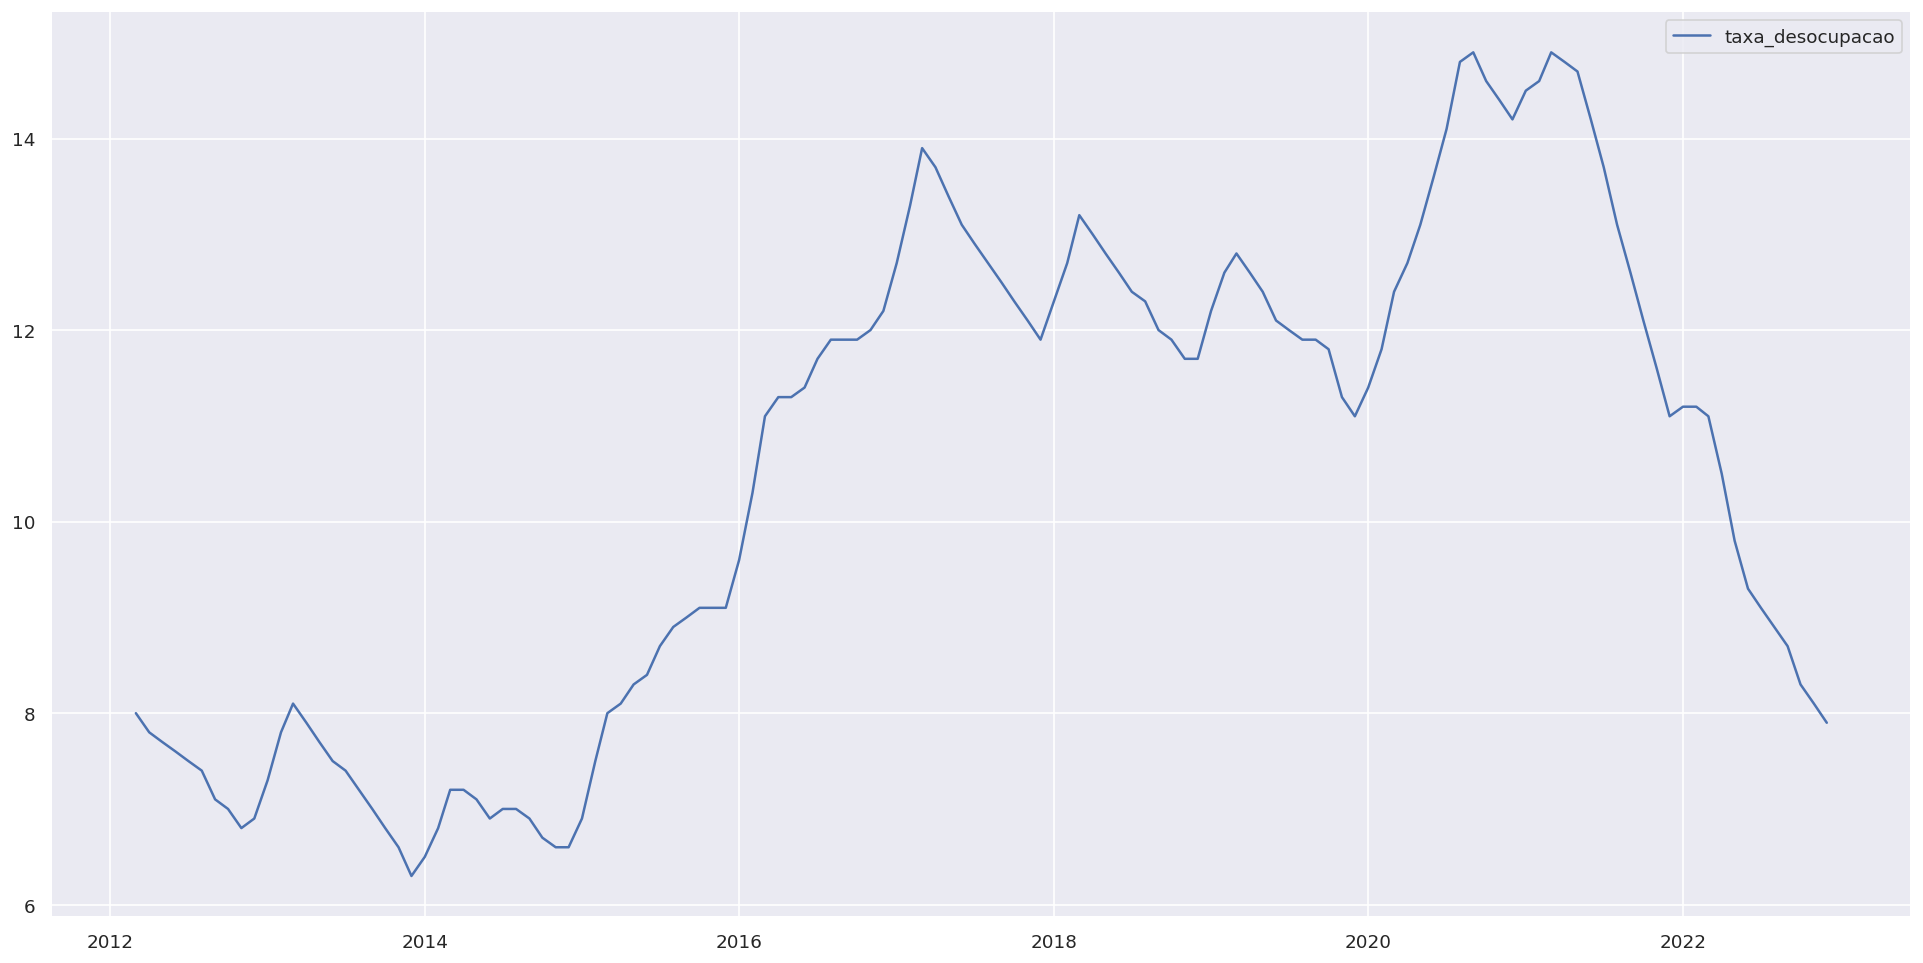

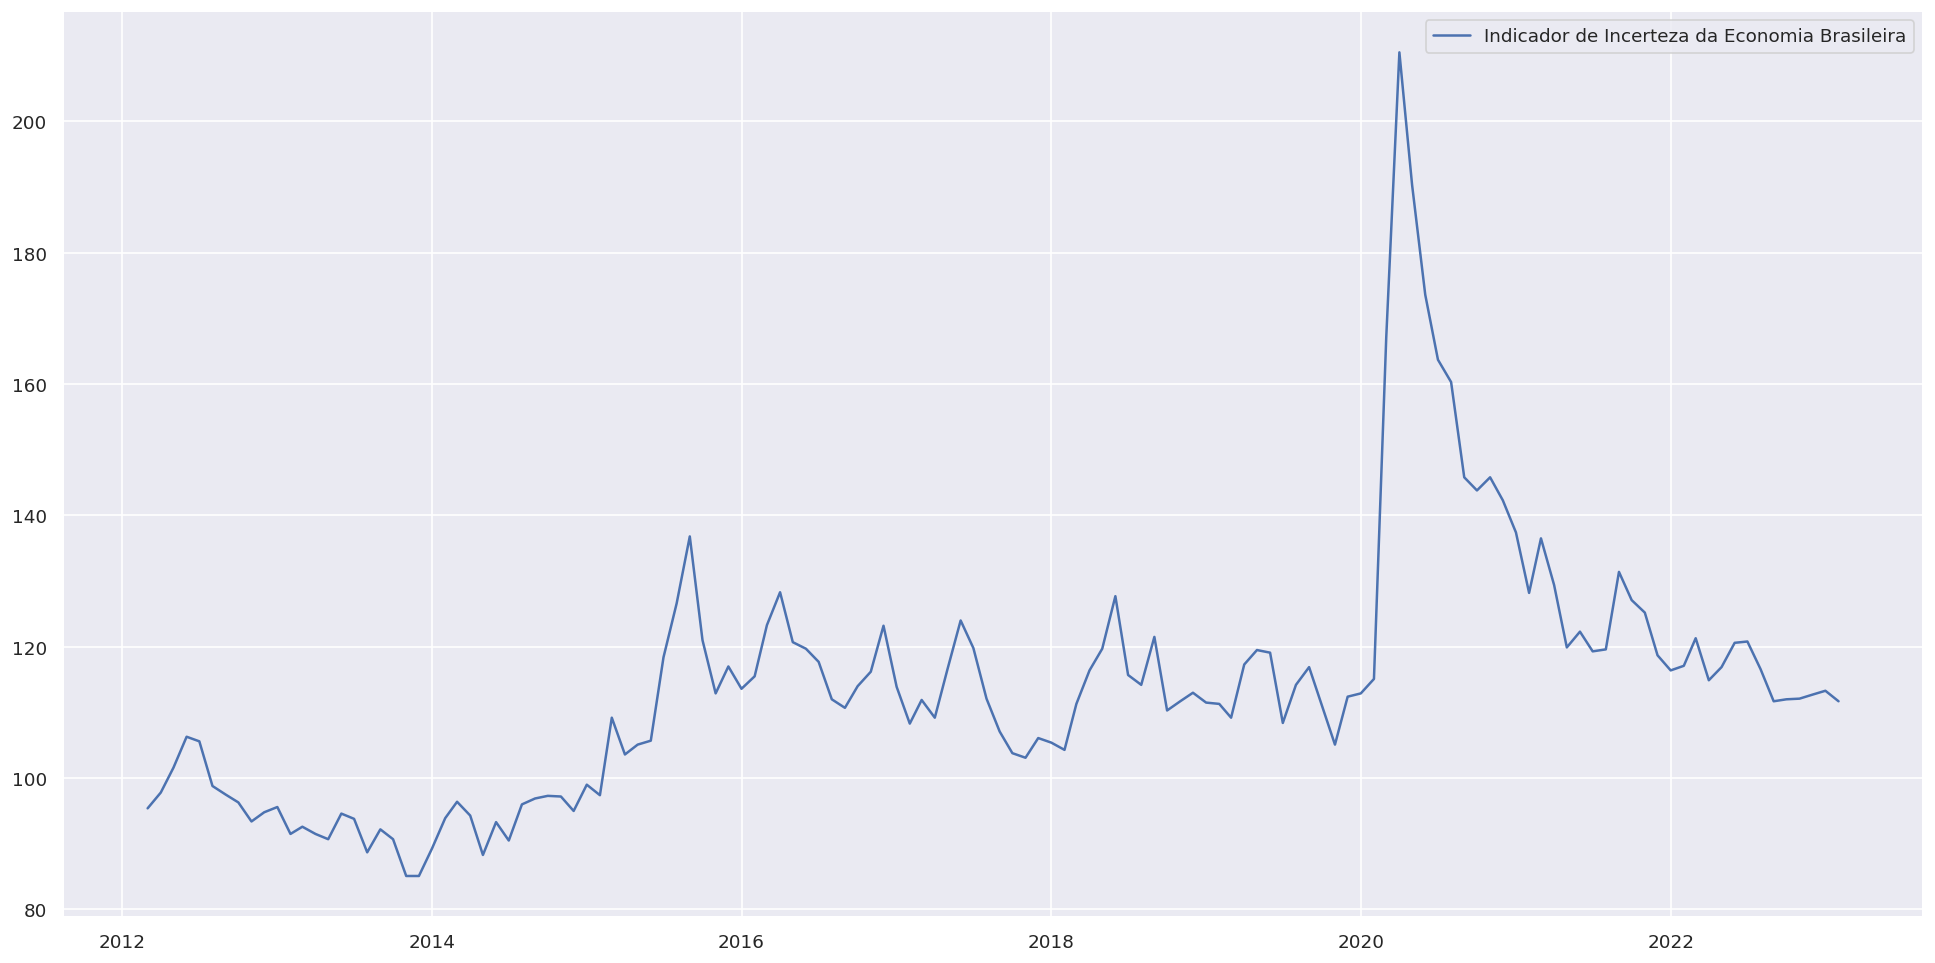

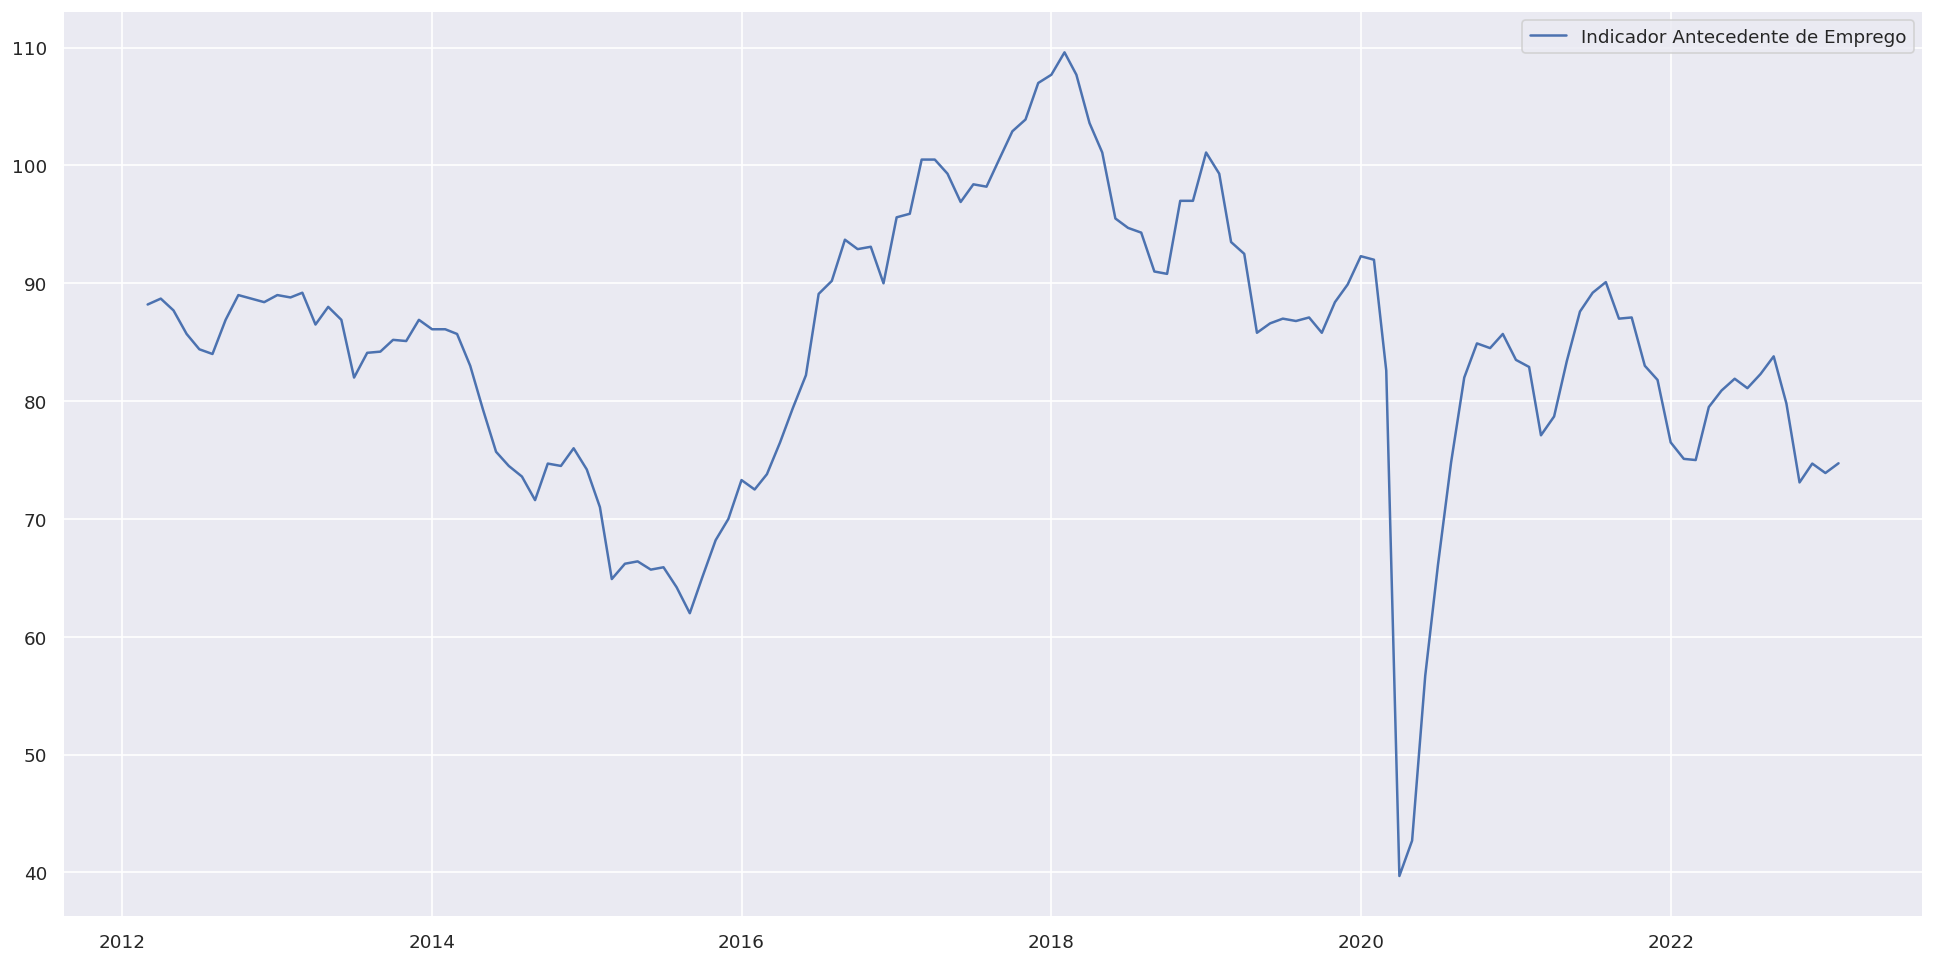

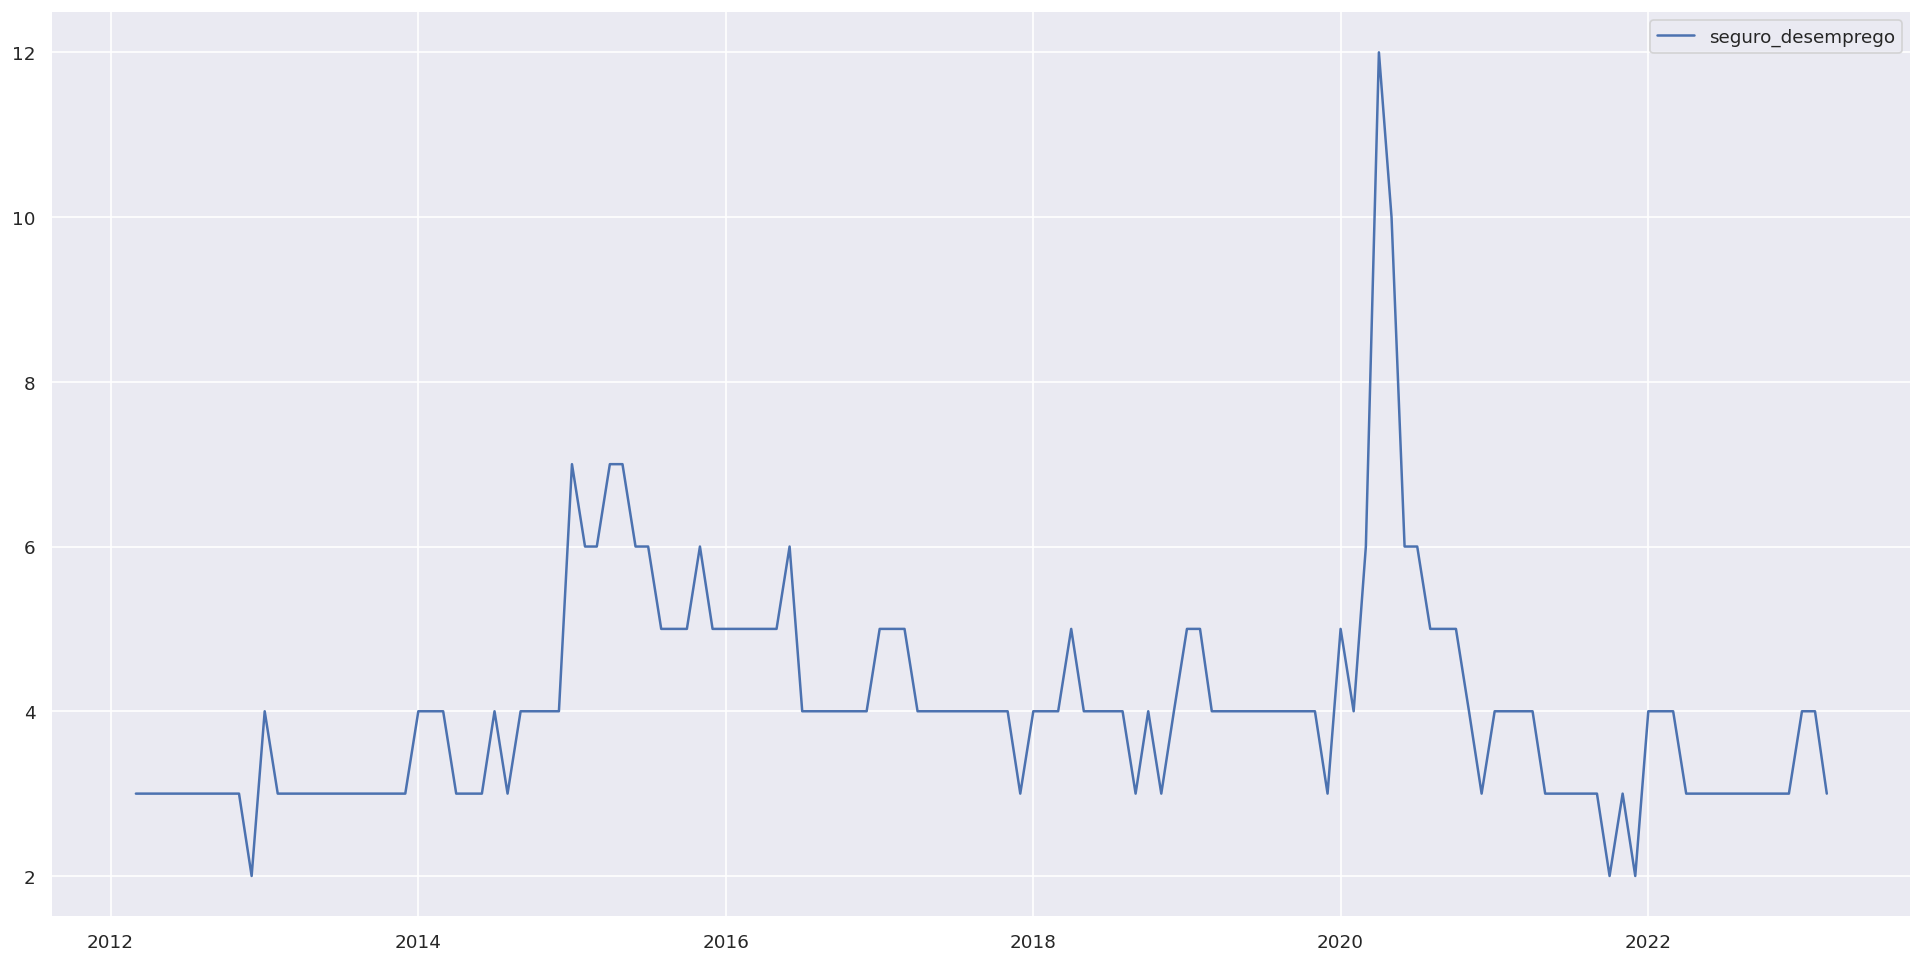

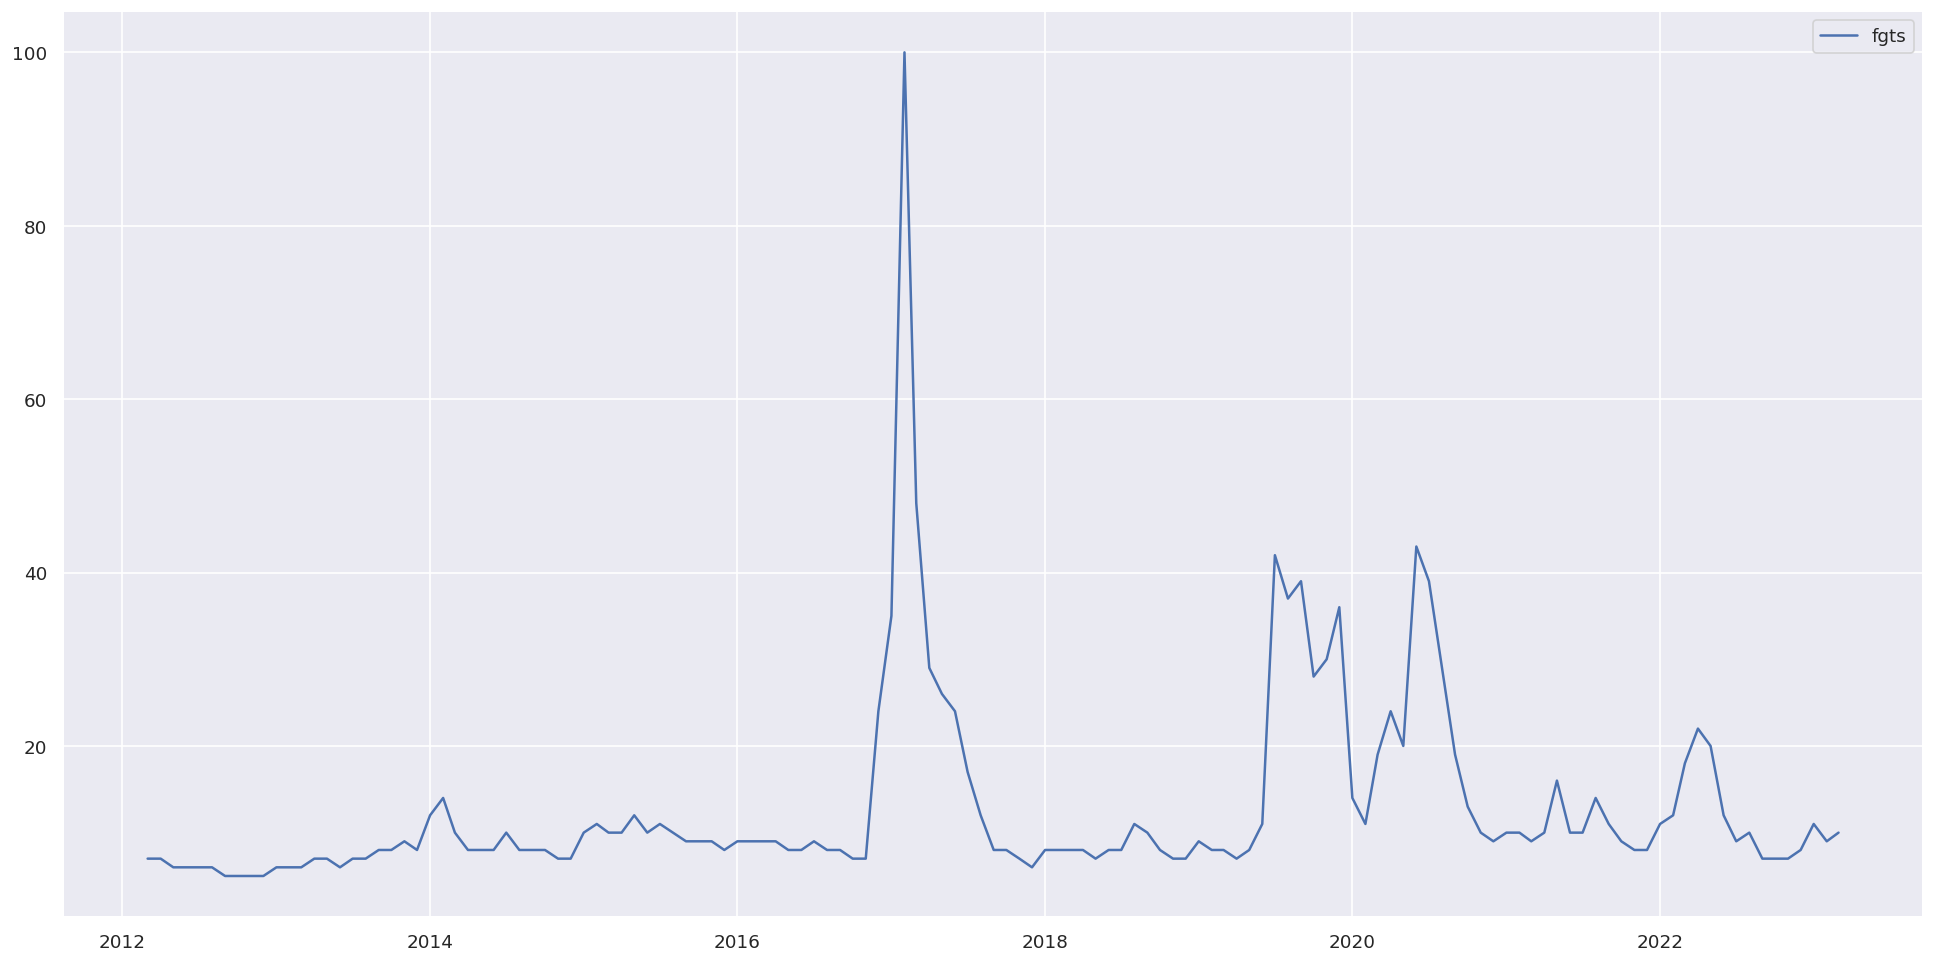

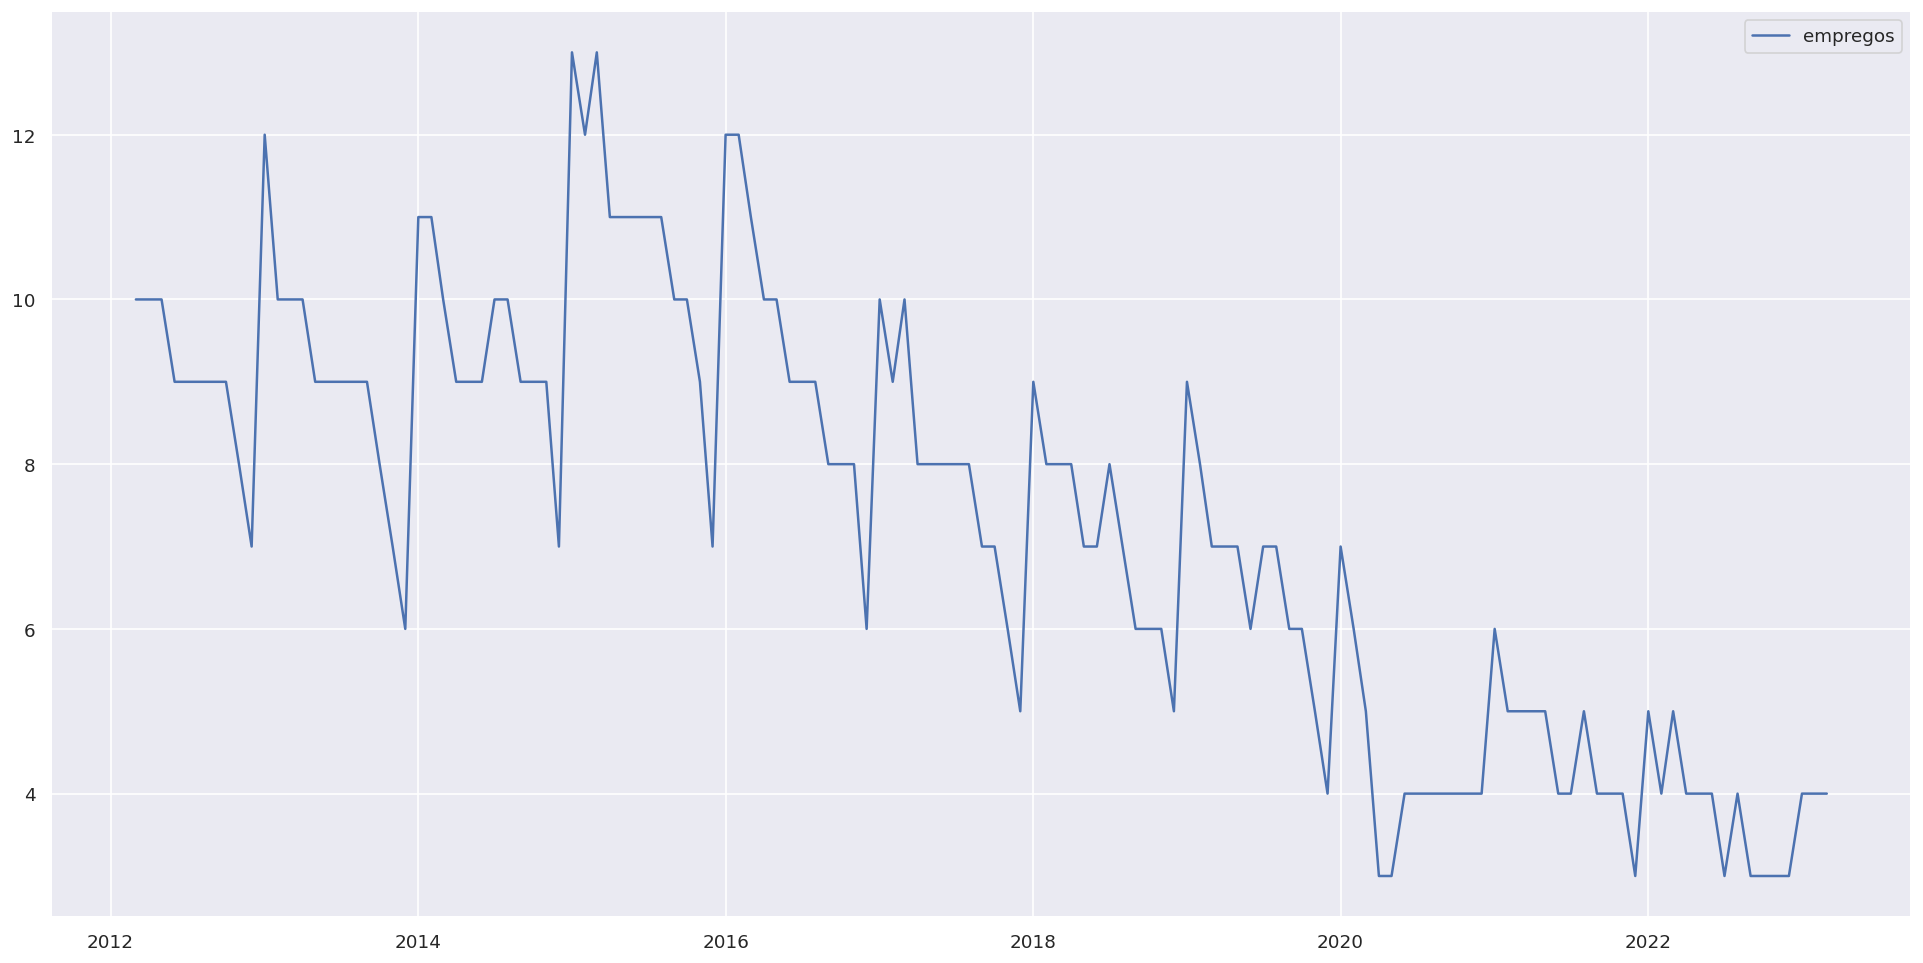

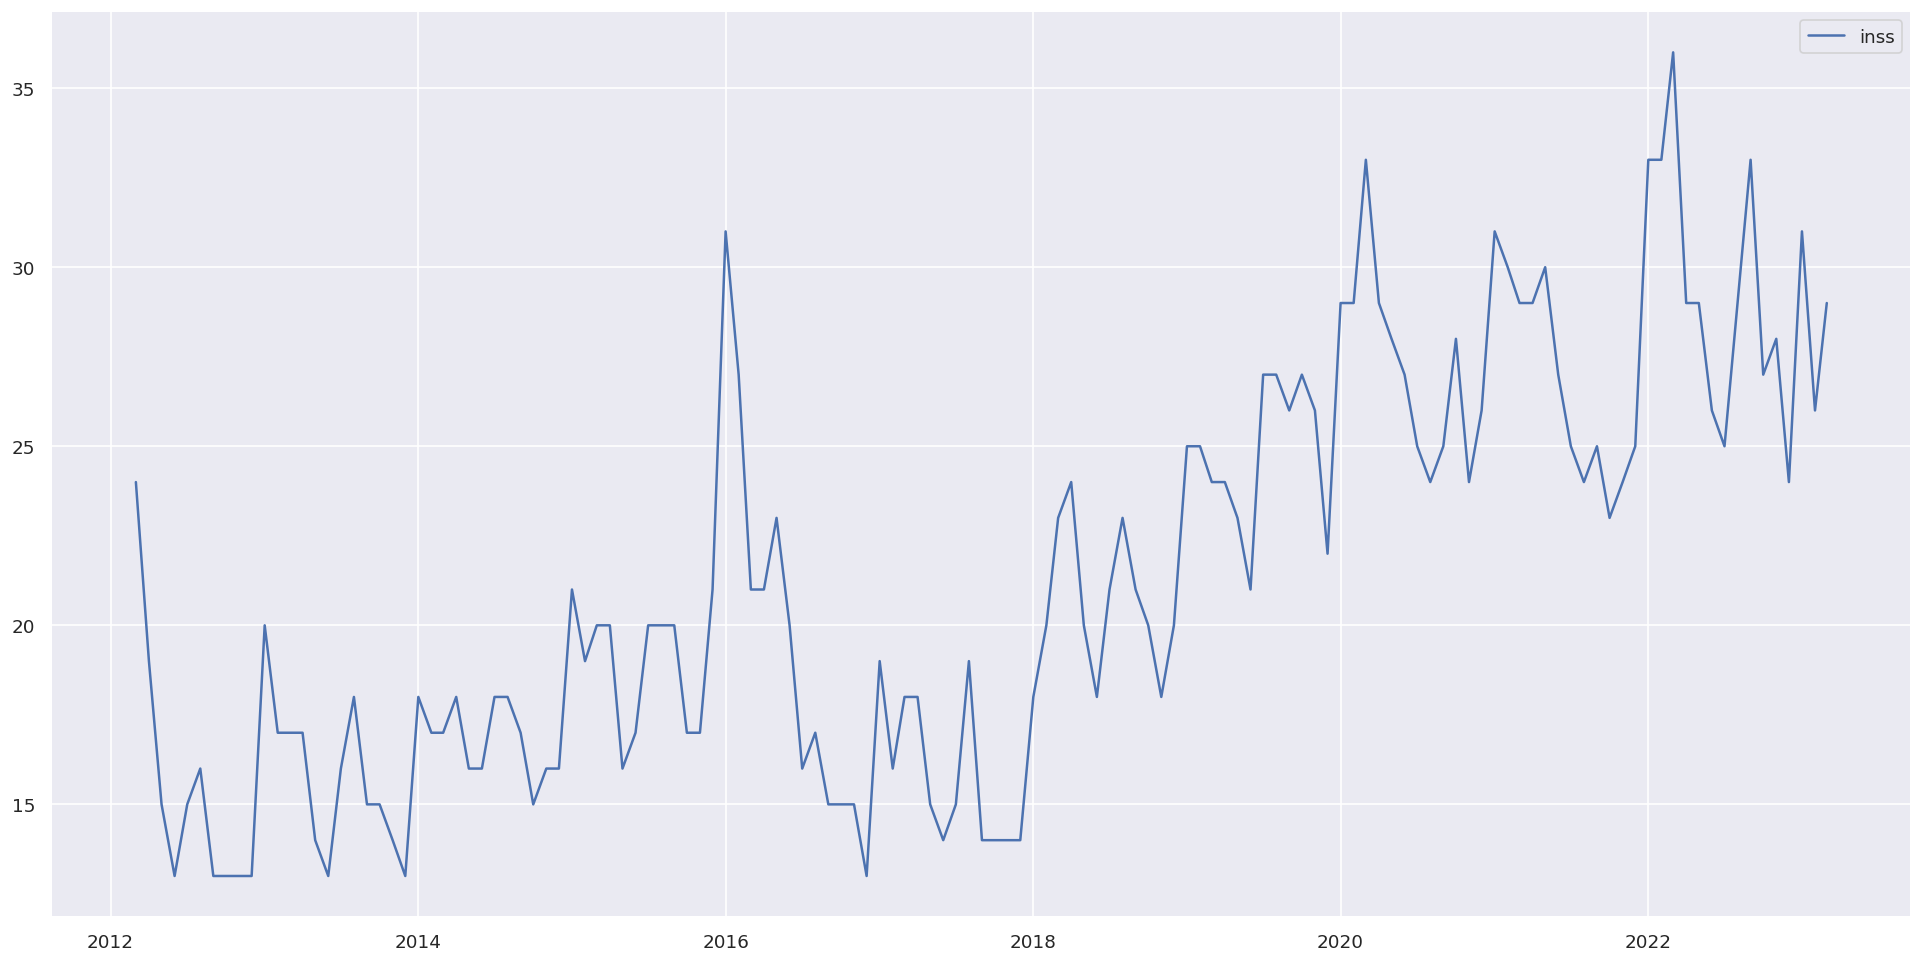

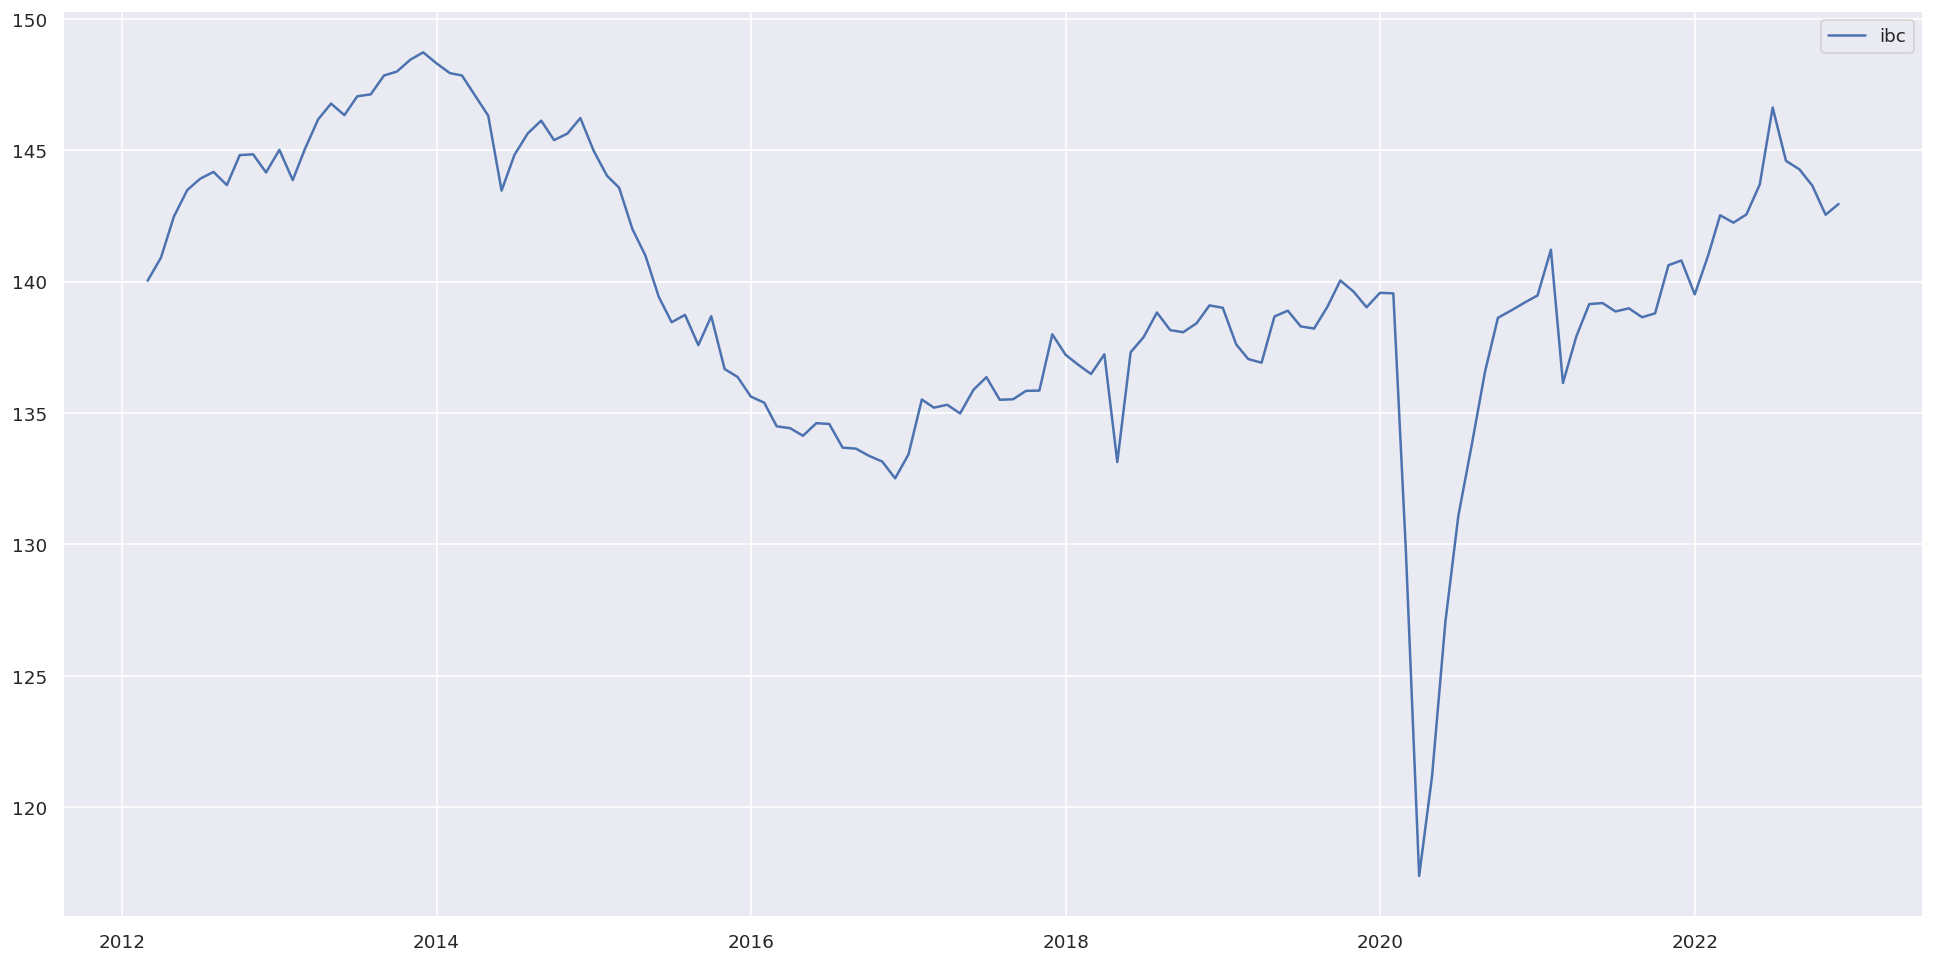

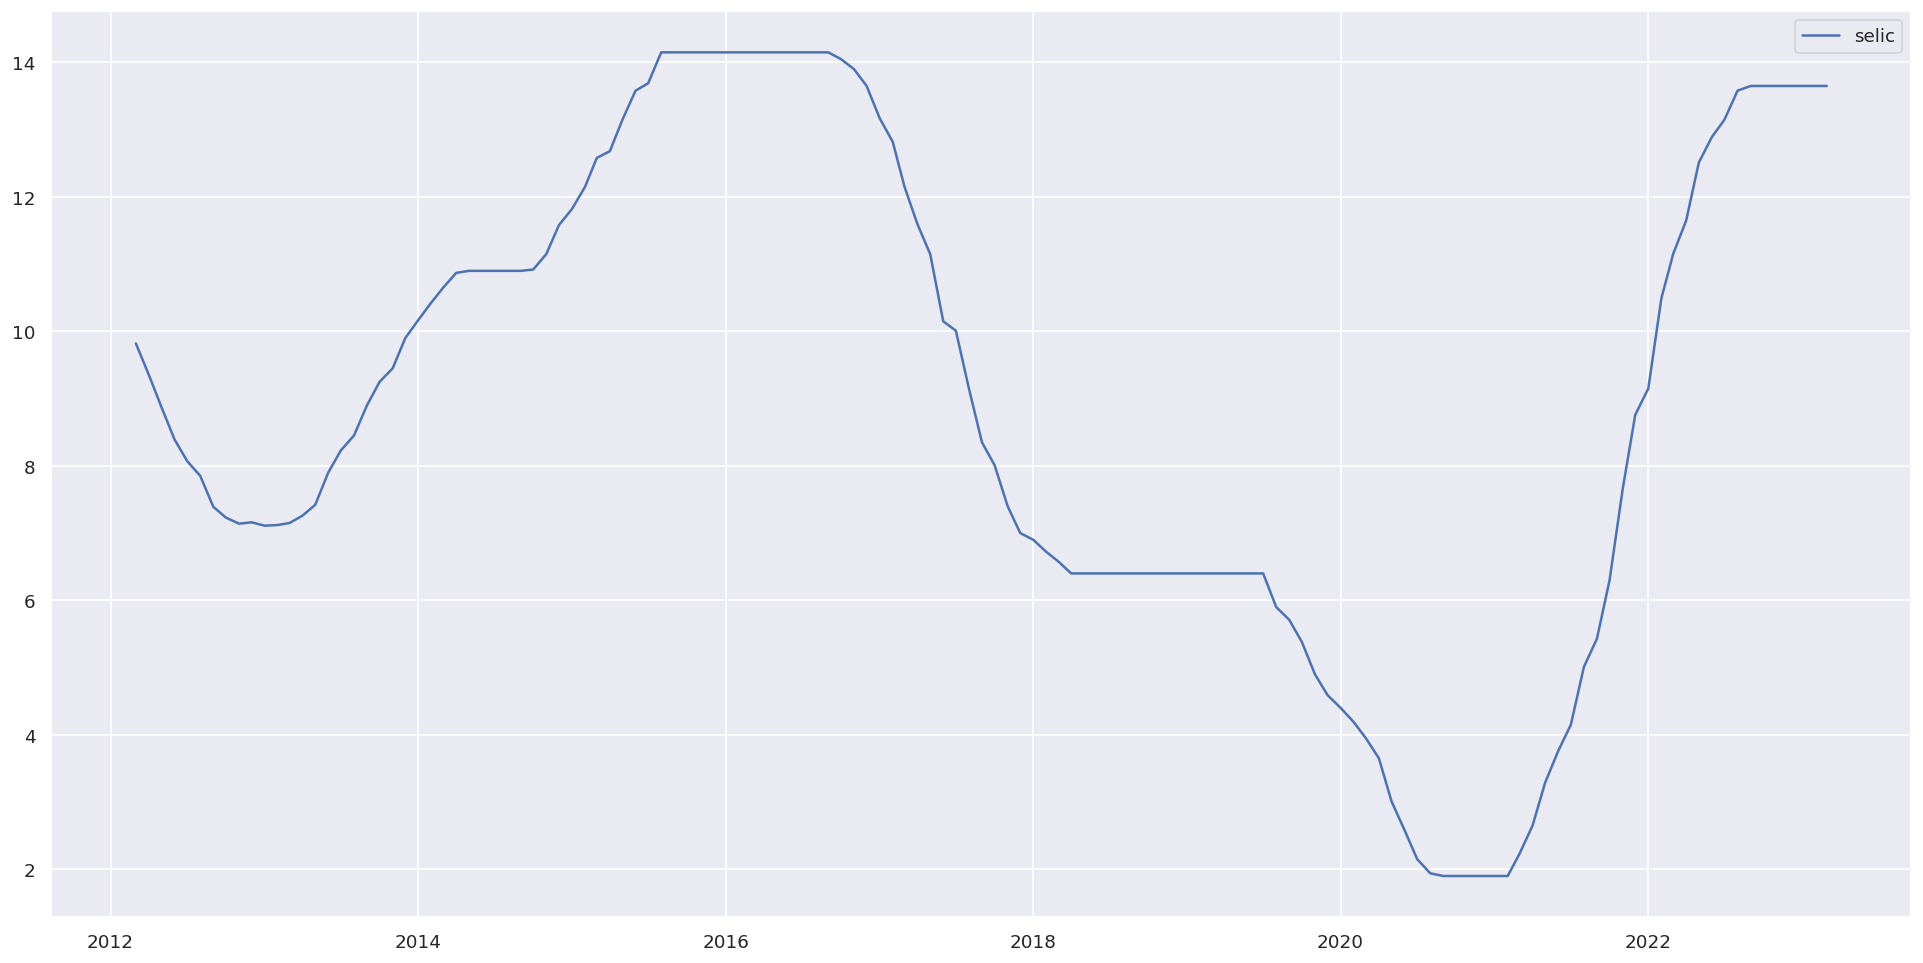

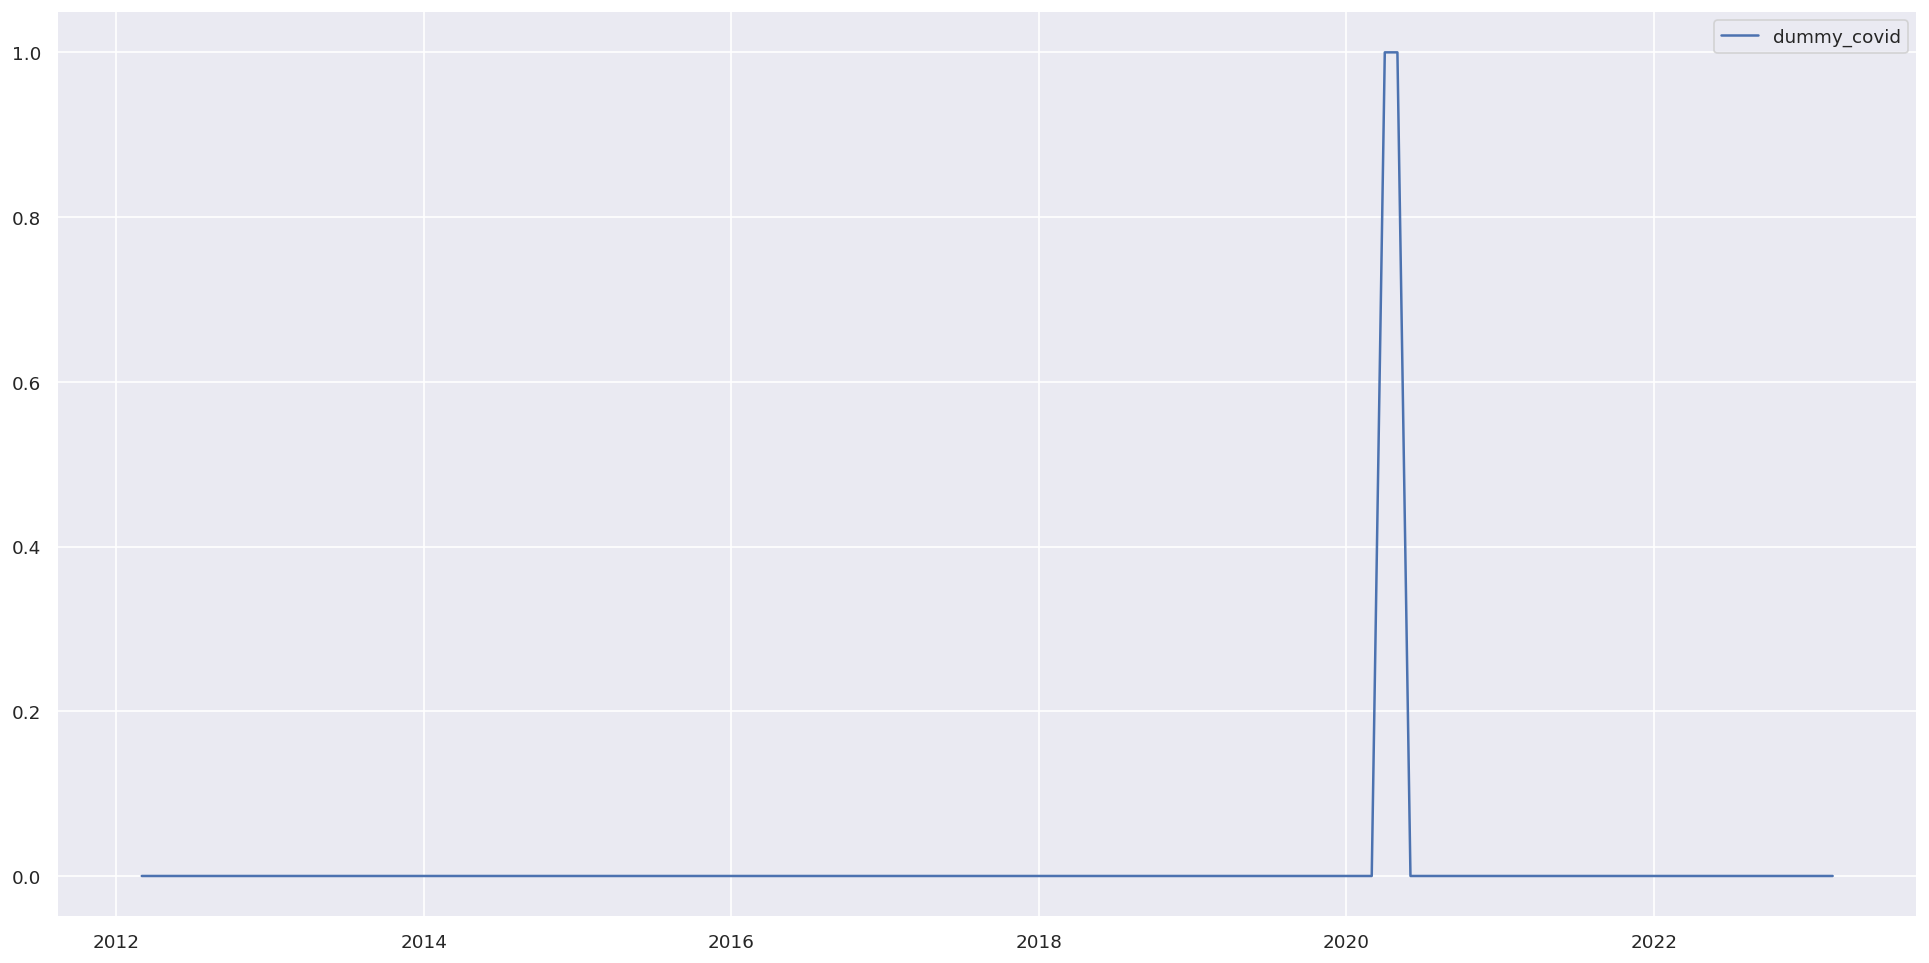

In [25]:
plotar(dados)

###Teste de estacionaridade Dickey-Fuller
Dickey-Fuller teste: esse é um dos testes estatísticos para verificar Estacionaridade. Aqui, a hipótese nula é que o TS é não-estacionária. Os resultados do teste são compostos por uma estatística de teste e alguns valores críticos para os níveis de confiança da diferença. Se o ‘teste estatístico’ é menor do que o “valor crítico”, podemos rejeitar a hipótese nula e dizer que a série é estacionária. Consulte este artigo para obter detalhes.

In [26]:
def test_kpss_adf(dados):
  #https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html
  def kpss_test(timeseries):
    """
    O KPSS é outro teste para verificar a estacionaridade de uma série temporal. As hipóteses nula e alternativa para o teste KPSS são opostas às do teste ADF.

    Hipótese Nula: O processo é estacionário de tendência.

    Hipótese Alternativa: A série tem raiz unitária (a série não é estacionária).

    Uma função é criada para realizar o teste KPSS em uma série temporal.
    """
    #print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
      kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    return kpss_output

  def adf_test(timeseries):

    """
    O teste ADF é usado para determinar a presença de raiz unitária na série e, portanto, ajuda a entender se a série é estacionária ou não. As hipóteses nula e 
    alternativa deste teste são:
    Hipótese Nula: A série tem raiz unitária.
    Hipótese alternativa: A série não tem raiz unitária.
    Se a hipótese nula não for rejeitada, este teste pode fornecer evidências de que a série é não estacionária.
   Uma função é criada para realizar o teste ADF em uma série temporal.
    """
    #print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
      dftest[0:4],
      index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
      dfoutput["Critical Value (%s)" % key] = value
    return dfoutput


  test_est = pd.DataFrame(index=dados.columns,columns = ['Teste_kpss', 'Estacionaria_ou_nâo_kpss','Teste_adf','Estacionaria_ou_nâo_adf'])
  for k in dados.columns:
    tes_kpss = kpss_test(dados[k].dropna())
    test_est.loc[k,test_est.columns[0]] = tes_kpss[1]
    tes_adf = adf_test(dados[k].dropna())
    test_est.loc[k,test_est.columns[2]] = tes_adf[1]
  test_est['Estacionaria_ou_nâo_kpss']=np.where(test_est['Teste_kpss'] >= 0.05,'Estacionaria','Nâo estacionaria')
  test_est['Estacionaria_ou_nâo_adf']=np.where(test_est['Teste_adf'] <= 0.05,'Estacionaria','Nâo estacionaria')
  return test_est
  

In [27]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    from statsmodels.tsa.stattools import adfuller
    import pandas as pd
    import matplotlib.pylab as plt
    import seaborn as sns
    import numpy as np
    for i in range(len(timeseries.columns)):
     #Determing rolling statistics
      rolmean = pd.Series(timeseries.iloc[:,i]).rolling(window=12).mean().dropna()
      rolstd = pd.Series(timeseries.iloc[:,i]).rolling(window=12).std().dropna()

      #Plot rolling statistics:
      if type(timeseries[timeseries.columns[i]][0]) != str:
        orig = plt.plot(timeseries.iloc[:,i], color='blue',label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title(f'Rolling Mean & Standard Deviation na variavel {timeseries.columns[i]}')
        plt.show(block=False)
    
        #Perform Dickey-Fuller test:
        print (f'Results of Dickey-Fuller Test:Coluna {timeseries.columns[i]}')
        dftest = adfuller(timeseries.iloc[:,i].dropna(), autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
          dfoutput['Critical Value (%s)'%key] = value
        print(dfoutput)
      else:
        try:
          timeseries.iloc[:,i] = timeseries.iloc[:,i].astype(int)
          orig = plt.plot(timeseries.iloc[:,i], color='blue',label='Original')
          mean = plt.plot(rolmean, color='red', label='Rolling Mean')
          std = plt.plot(rolstd, color='black', label = 'Rolling Std')
          plt.legend(loc='best')
          plt.title(f'Rolling Mean & Standard Deviation na variavel {timeseries.columns[i]}')
          plt.show(block=False)
    
          #Perform Dickey-Fuller test:
          print (f'Results of Dickey-Fuller Test:Coluna {timeseries.columns[i]}')
          dftest = adfuller(timeseries.iloc[:,i].dropna(), autolag='AIC')
          dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
          for key,value in dftest[4].items():
           dfoutput['Critical Value (%s)'%key] = value
          print(dfoutput)
        except:
          timeseries.iloc[:,i] = timeseries.iloc[:,i].astype(float)
          orig = plt.plot(timeseries.iloc[:,i], color='blue',label='Original')
          mean = plt.plot(rolmean, color='red', label='Rolling Mean')
          std = plt.plot(rolstd, color='black', label = 'Rolling Std')
          plt.legend(loc='best')
          plt.title(f'Rolling Mean & Standard Deviation na variavel {timeseries.columns[i]}')
          plt.show(block=False)
    
          #Perform Dickey-Fuller test:
          print (f'Results of Dickey-Fuller Test:Coluna {timeseries.columns[i]}')
          dftest = adfuller(timeseries.iloc[:,i].dropna(), autolag='AIC')
          dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
          for key,value in dftest[4].items():
           dfoutput['Critical Value (%s)'%key] = value
          print(dfoutput)
        
    return test_kpss_adf(timeseries)
          

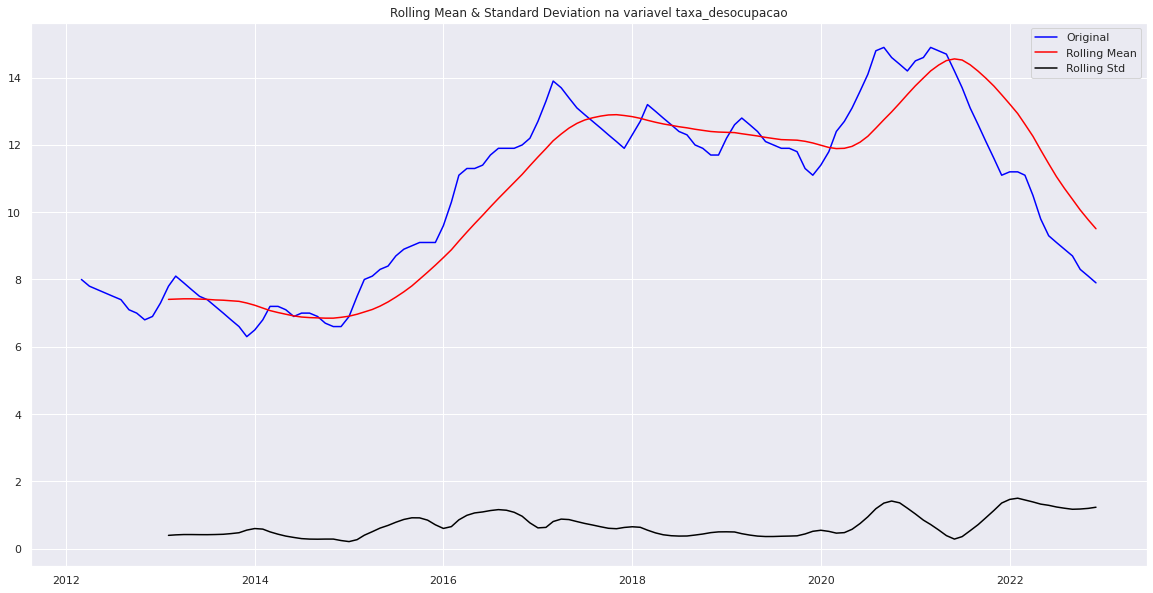

Results of Dickey-Fuller Test:Coluna taxa_desocupacao
Test Statistic                 -1.78
p-value                         0.39
#Lags Used                     13.00
Number of Observations Used   116.00
Critical Value (1%)            -3.49
Critical Value (5%)            -2.89
Critical Value (10%)           -2.58
dtype: float64


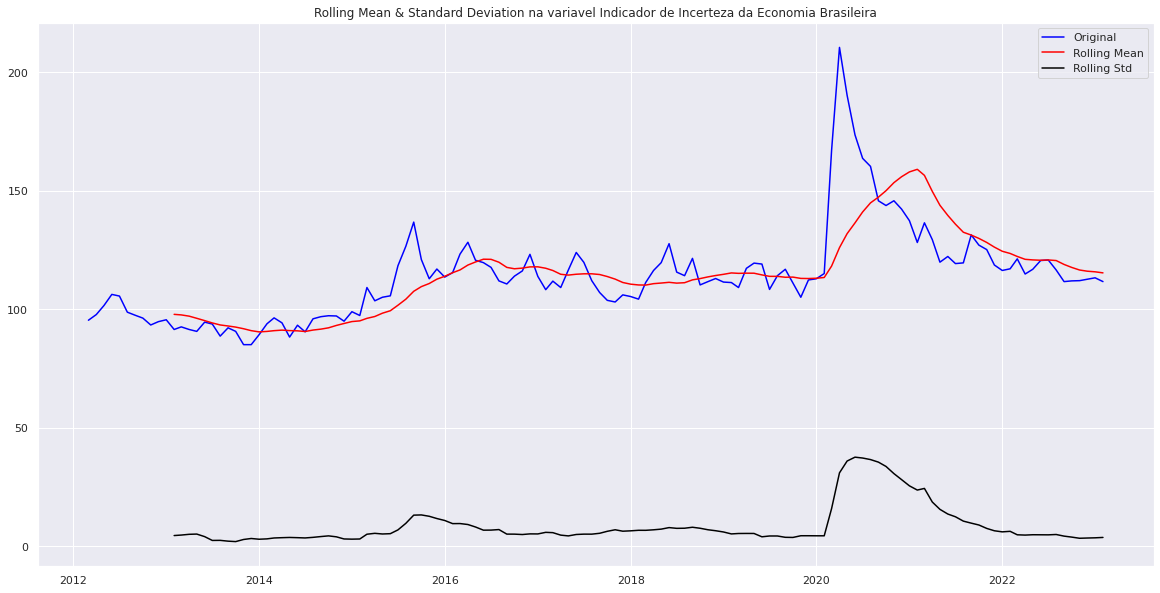

Results of Dickey-Fuller Test:Coluna Indicador de Incerteza da Economia Brasileira
Test Statistic                 -2.53
p-value                         0.11
#Lags Used                      2.00
Number of Observations Used   129.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


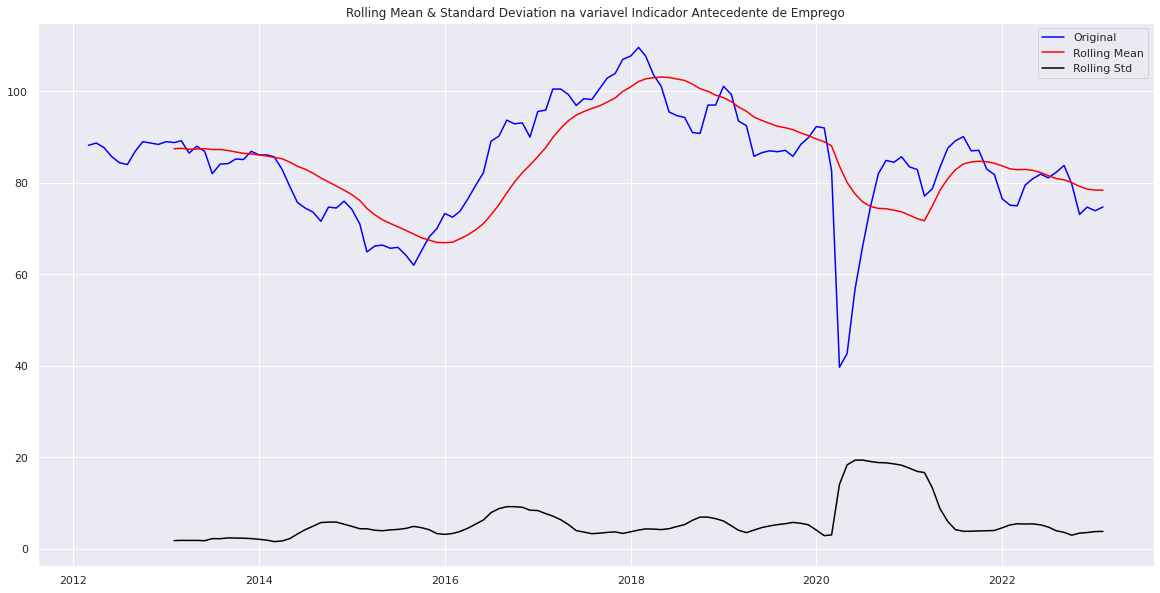

Results of Dickey-Fuller Test:Coluna Indicador Antecedente de Emprego
Test Statistic                 -3.23
p-value                         0.02
#Lags Used                      1.00
Number of Observations Used   130.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


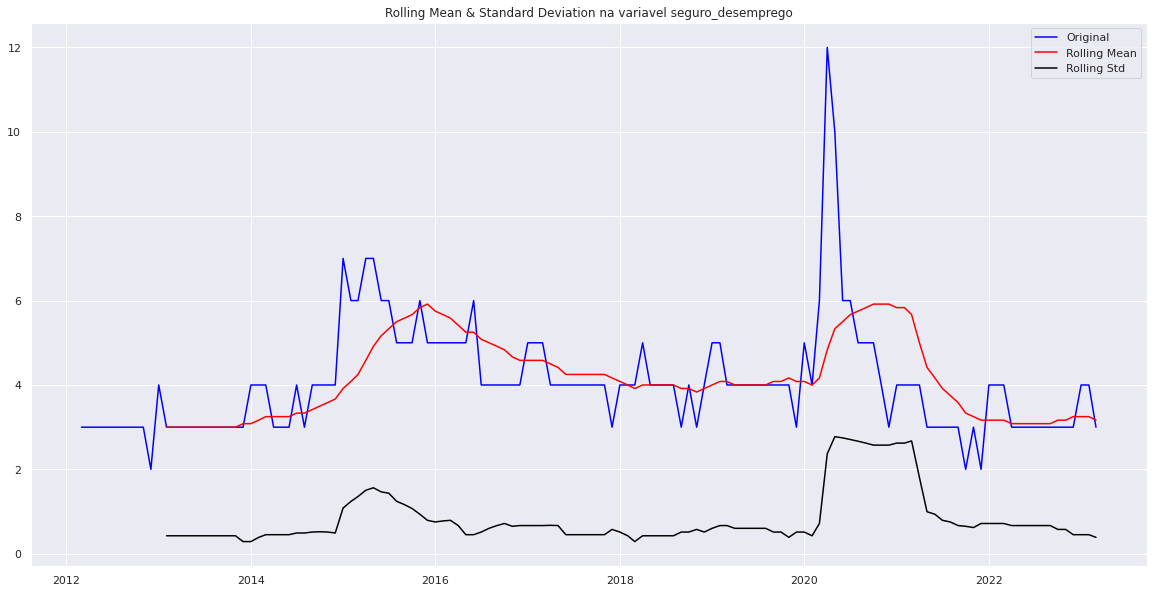

Results of Dickey-Fuller Test:Coluna seguro_desemprego
Test Statistic                 -4.42
p-value                         0.00
#Lags Used                      0.00
Number of Observations Used   132.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


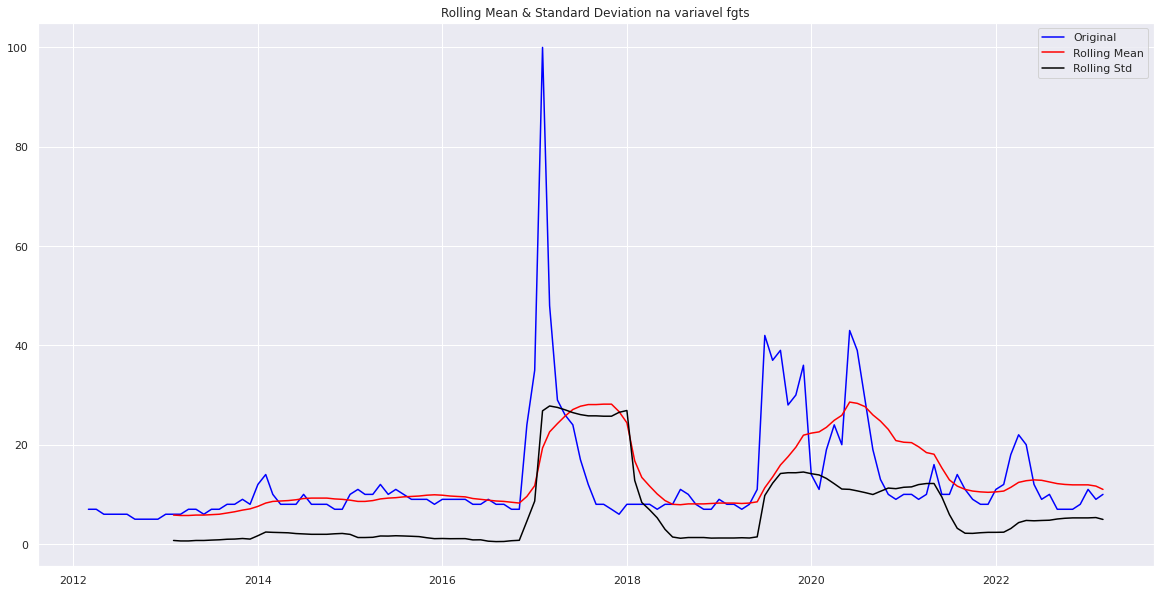

Results of Dickey-Fuller Test:Coluna fgts
Test Statistic                 -4.82
p-value                         0.00
#Lags Used                      0.00
Number of Observations Used   132.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


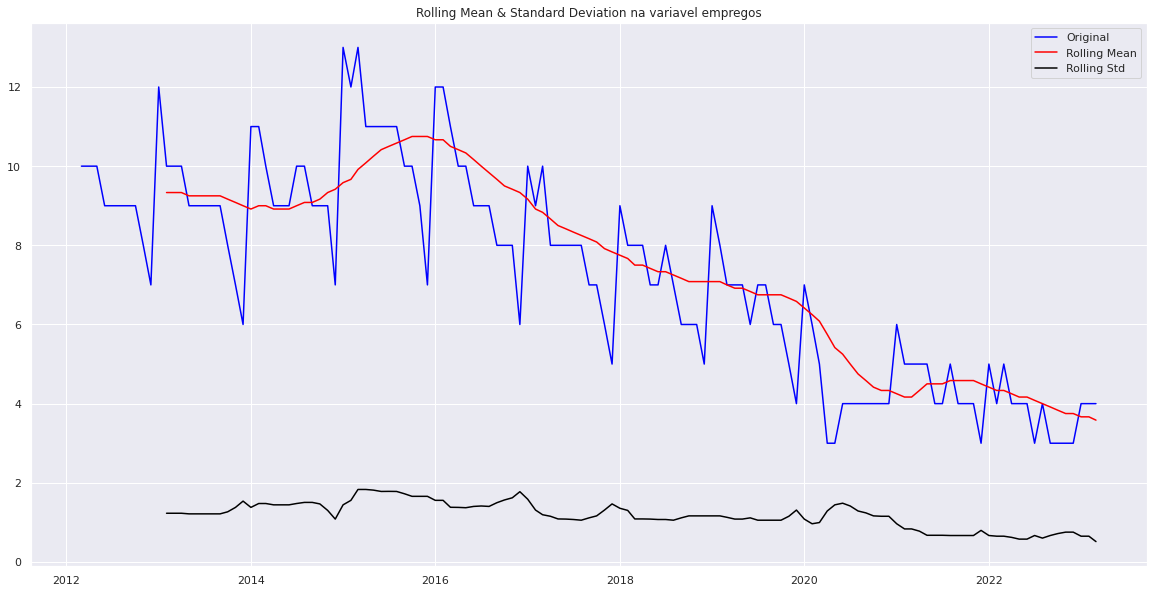

Results of Dickey-Fuller Test:Coluna empregos
Test Statistic                 -0.35
p-value                         0.92
#Lags Used                     13.00
Number of Observations Used   119.00
Critical Value (1%)            -3.49
Critical Value (5%)            -2.89
Critical Value (10%)           -2.58
dtype: float64


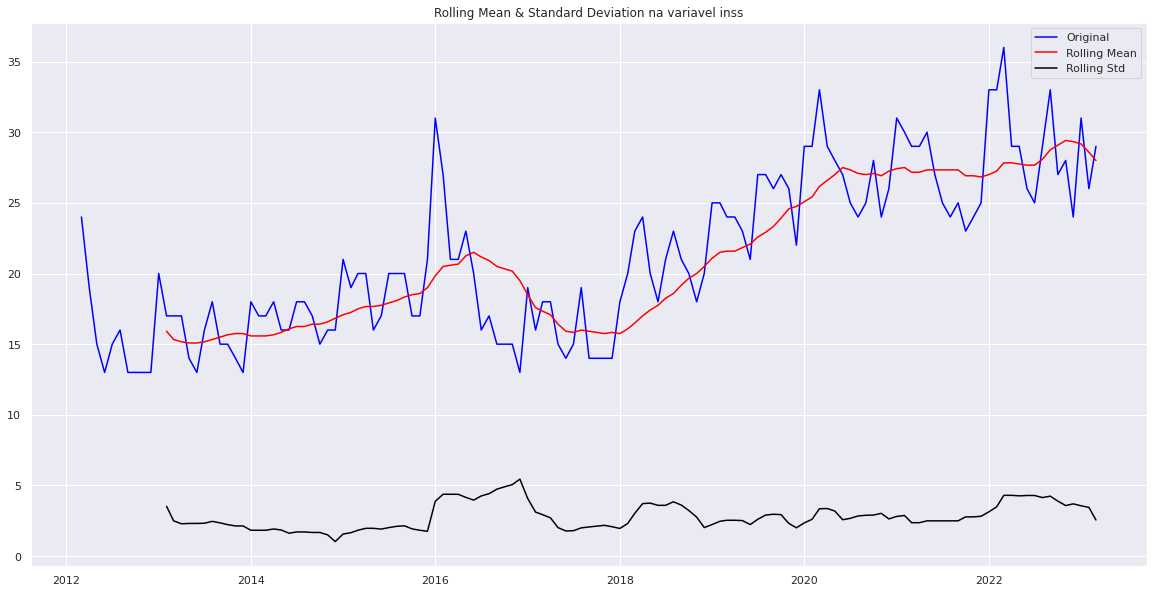

Results of Dickey-Fuller Test:Coluna inss
Test Statistic                 -1.08
p-value                         0.72
#Lags Used                     12.00
Number of Observations Used   120.00
Critical Value (1%)            -3.49
Critical Value (5%)            -2.89
Critical Value (10%)           -2.58
dtype: float64


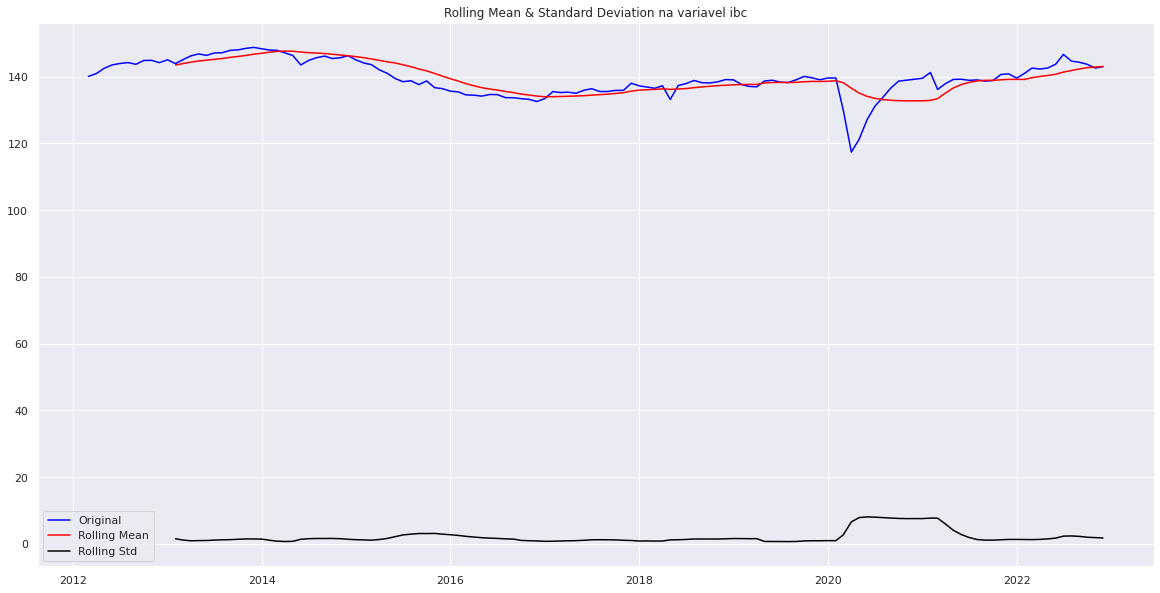

Results of Dickey-Fuller Test:Coluna ibc
Test Statistic                 -2.30
p-value                         0.17
#Lags Used                      2.00
Number of Observations Used   127.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


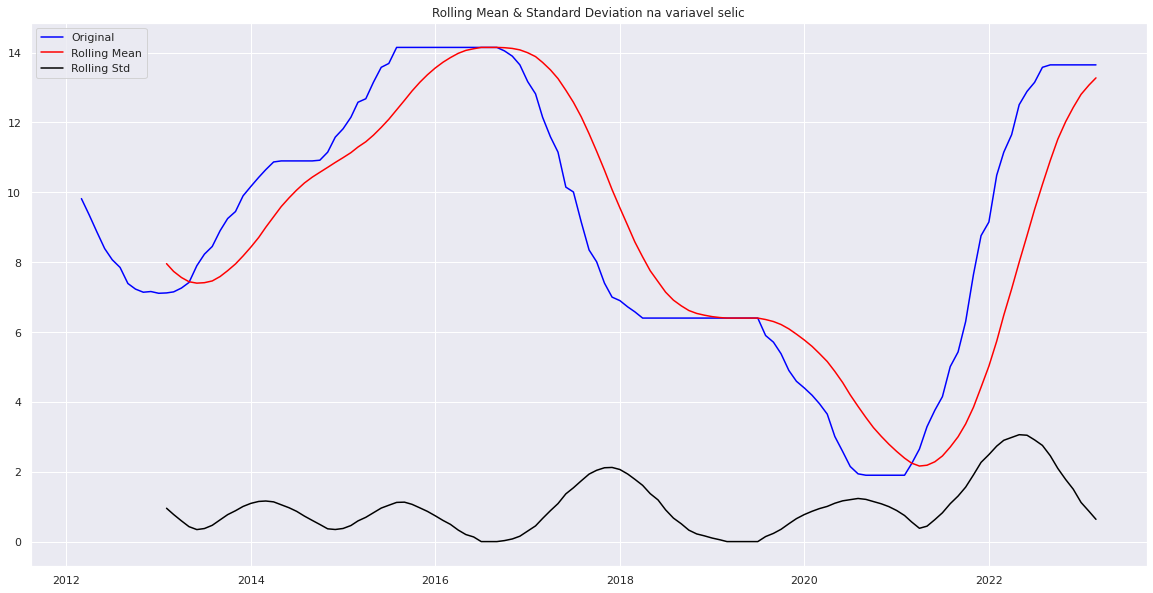

Results of Dickey-Fuller Test:Coluna selic
Test Statistic                 -1.67
p-value                         0.45
#Lags Used                      9.00
Number of Observations Used   123.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.89
Critical Value (10%)           -2.58
dtype: float64


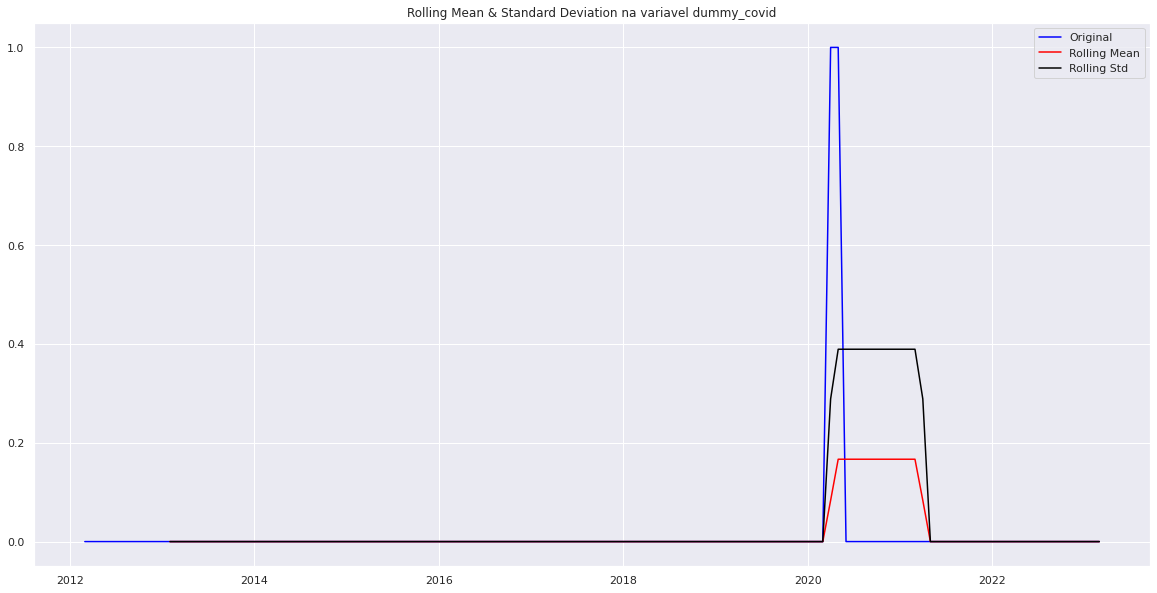

Results of Dickey-Fuller Test:Coluna dummy_covid
Test Statistic                 -4.62
p-value                         0.00
#Lags Used                      5.00
Number of Observations Used   127.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-va

In [28]:
test = test_stationarity(dados)

In [29]:
test

Teste_kpss  \
taxa_desocupacao                                    0.01   
Indicador de Incerteza da Economia Brasileira       0.01   
Indicador Antecedente de Emprego                    0.10   
seguro_desemprego                                   0.10   
fgts                                                0.10   
empregos                                            0.01   
inss                                                0.01   
ibc                                                 0.02   
selic                                               0.07   
dummy_covid                                         0.10   

                                              Estacionaria_ou_nâo_kpss  \
taxa_desocupacao                                      Nâo estacionaria   
Indicador de Incerteza da Economia Brasileira         Nâo estacionaria   
Indicador Antecedente de Emprego                          Estacionaria   
seguro_desemprego                                         Estacionaria   
fgts                                                      Estacionaria   
empregos                                              Nâo estacionaria   
inss                                                  Nâo estacionaria   
ibc                                                   Nâo estacionaria   
selic                                                     Estacionaria   
dummy_covid                                               Estacionaria   

                                              Teste_adf  \
taxa_desocupacao                                   0.39   
Indicador de Incerteza da Economia Brasileira      0.11   
Indicador Antecedente de Emprego                   0.02   
seguro_desemprego                                  0.00   
fgts                                               0.00   
empregos                                           0.92   
inss                                               0.72   
ibc                                                0.17   
selic                                              0.45   
dummy_covid                                        0.00   

                                              Estacionaria_ou_nâo_adf  
taxa_desocupacao                                     Nâo estacionaria  
Indicador de Incerteza da Economia Brasileira        Nâo estacionaria  
Indicador Antecedente de Emprego                         Estacionaria  
seguro_desemprego                                        Estacionaria  
fgts                                                     Estacionaria  
empregos                                             Nâo estacionaria  
inss                                                 Nâo estacionaria  
ibc                                                  Nâo estacionaria  
selic                                                Nâo estacionaria  
dummy_covid                                              Estacionaria

###Verificando a diferenca de estacionaridade
#http://alkaline-ml.com/pmdarima/1.5.1/modules/generated/pmdarima.arima.ndiffs.html

In [30]:
from pmdarima import arima

In [31]:
def report_ndiffs (dados,test=['kpss', 'adf', 'pp'],alpha=0.05):
  dat_ndifis = pd.DataFrame(index=dados.columns)
  for i in test:
    dat_n = []
    for j in dados.columns:
      dat_n.append(arima.ndiffs(dados[j].dropna(),alpha,test=i))
    dat_ndifis[i] = dat_n
  result = []
  for k in range(len(dat_ndifis)):
    result.append(np.where(dat_ndifis.iloc[k,0]==dat_ndifis.iloc[k,1],dat_ndifis.iloc[k,0],
         np.where(dat_ndifis.iloc[k,1]==dat_ndifis.iloc[k,2],dat_ndifis.iloc[k,1],
                  np.where(dat_ndifis.iloc[k,0]==dat_ndifis.iloc[k,2],dat_ndifis.iloc[k,2],''))))
  dat_ndifis['Ndifis'] = result
  dat_ndifis.sort_values(by='Ndifis',ascending=False,inplace=True)
  dat_ndifis['Ndifis'] = dat_ndifis['Ndifis'].astype(int)
  return dat_ndifis

In [32]:
n_difis = report_ndiffs(dados)
n_difis

kpss  adf  pp  Ndifis
taxa_desocupacao                                  1    1   1       1
Indicador de Incerteza da Economia Brasileira     1    1   0       1
Indicador Antecedente de Emprego                  0    1   1       1
empregos                                          1    1   0       1
inss                                              1    1   0       1
ibc                                               1    1   1       1
selic                                             1    2   1       1
seguro_desemprego                                 0    1   0       0
fgts                                              0    0   0       0
dummy_covid                                       0    0   0       0

###Ajustando dados nao estacionarios metodo de diferenciacao

https://www.youtube.com/watch?v=JuG8hwVK5uQ

Modelagem de séries temporais frequentemente exige a aplicação de transformações nas variáveis, tal como a bem conhecida primeira diferença. Formalmente, podemos descrever essa transformação como:


Ou seja, dado uma série temporal regularmente espaçada, subtraímos do valor em t o valor anterior (t-1), obtendo a série dita "na primeira diferença" ou "nas diferenças".

A mudança de nível da série geralmente contorna diversas características "não desejadas" pelo analista como tendência, sazonalidade, etc., mas dificulta a interpretação dos valores - especialmente quando pretende-se comunicá-los para públicos não técnicos. Para este objetivo é de grande utilidade saber como diferenciar uma série temporal e, sobretudo, também como reverter a transformação.

In [33]:
def corrigindo_nao_estacionaridade(base,n_difis,valor_predicao):
  dados_est = base.copy()
  for i in n_difis[n_difis['Ndifis'] >= 1].index:
    if i == valor_predicao:
      dados_est[i] = dados_est[i]
    else:
      j = 0
      while j < n_difis['Ndifis'][i]:
        dados_est[i] = dados_est[i].diff(periods=1)
        j = j+1
  return dados_est

In [34]:
dados_est = corrigindo_nao_estacionaridade(dados,n_difis,'taxa_desocupacao')[1:]
dados_est

taxa_desocupacao  Indicador de Incerteza da Economia Brasileira  \
2012-04-01              7.80                                           2.40   
2012-05-01              7.70                                           3.80   
2012-06-01              7.60                                           4.70   
2012-07-01              7.50                                          -0.70   
2012-08-01              7.40                                          -6.80   
...                      ...                                            ...   
2022-11-01              8.10                                           0.10   
2022-12-01              7.90                                           0.60   
2023-01-01               NaN                                           0.60   
2023-02-01               NaN                                          -1.60   
2023-03-01               NaN                                            NaN   

            Indicador Antecedente de Emprego  seguro_desemprego  fgts  \
2012-04-01                              0.50               3.00  7.00   
2012-05-01                             -1.00               3.00  6.00   
2012-06-01                             -2.00               3.00  6.00   
2012-07-01                             -1.30               3.00  6.00   
2012-08-01                             -0.40               3.00  6.00   
...                                      ...                ...   ...   
2022-11-01                             -6.70               3.00  7.00   
2022-12-01                              1.60               3.00  8.00   
2023-01-01                             -0.80               4.00 11.00   
2023-02-01                              0.82               4.00  9.00   
2023-03-01                               NaN               3.00 10.00   

            empregos  inss   ibc  selic  dummy_covid  
2012-04-01      0.00 -5.00  0.88  -0.47            0  
2012-05-01      0.00 -4.00  1.56  -0.48            0  
2012-06-01     -1.00 -2.00  1.01  -0.48            0  
2012-07-01      0.00  2.00  0.43  -0.32            0  
2012-08-01      0.00  1.00  0.26  -0.22            0  
...              ...   ...   ...    ...          ...  
2022-11-01      0.00  1.00 -1.11   0.00            0  
2022-12-01      0.00 -4.00  0.41   0.00            0  
2023-01-01      1.00  7.00   NaN   0.00            0  
2023-02-01      0.00 -5.00   NaN   0.00            0  
2023-03-01      0.00  3.00   NaN   0.00            0  

[132 rows x 10 columns]

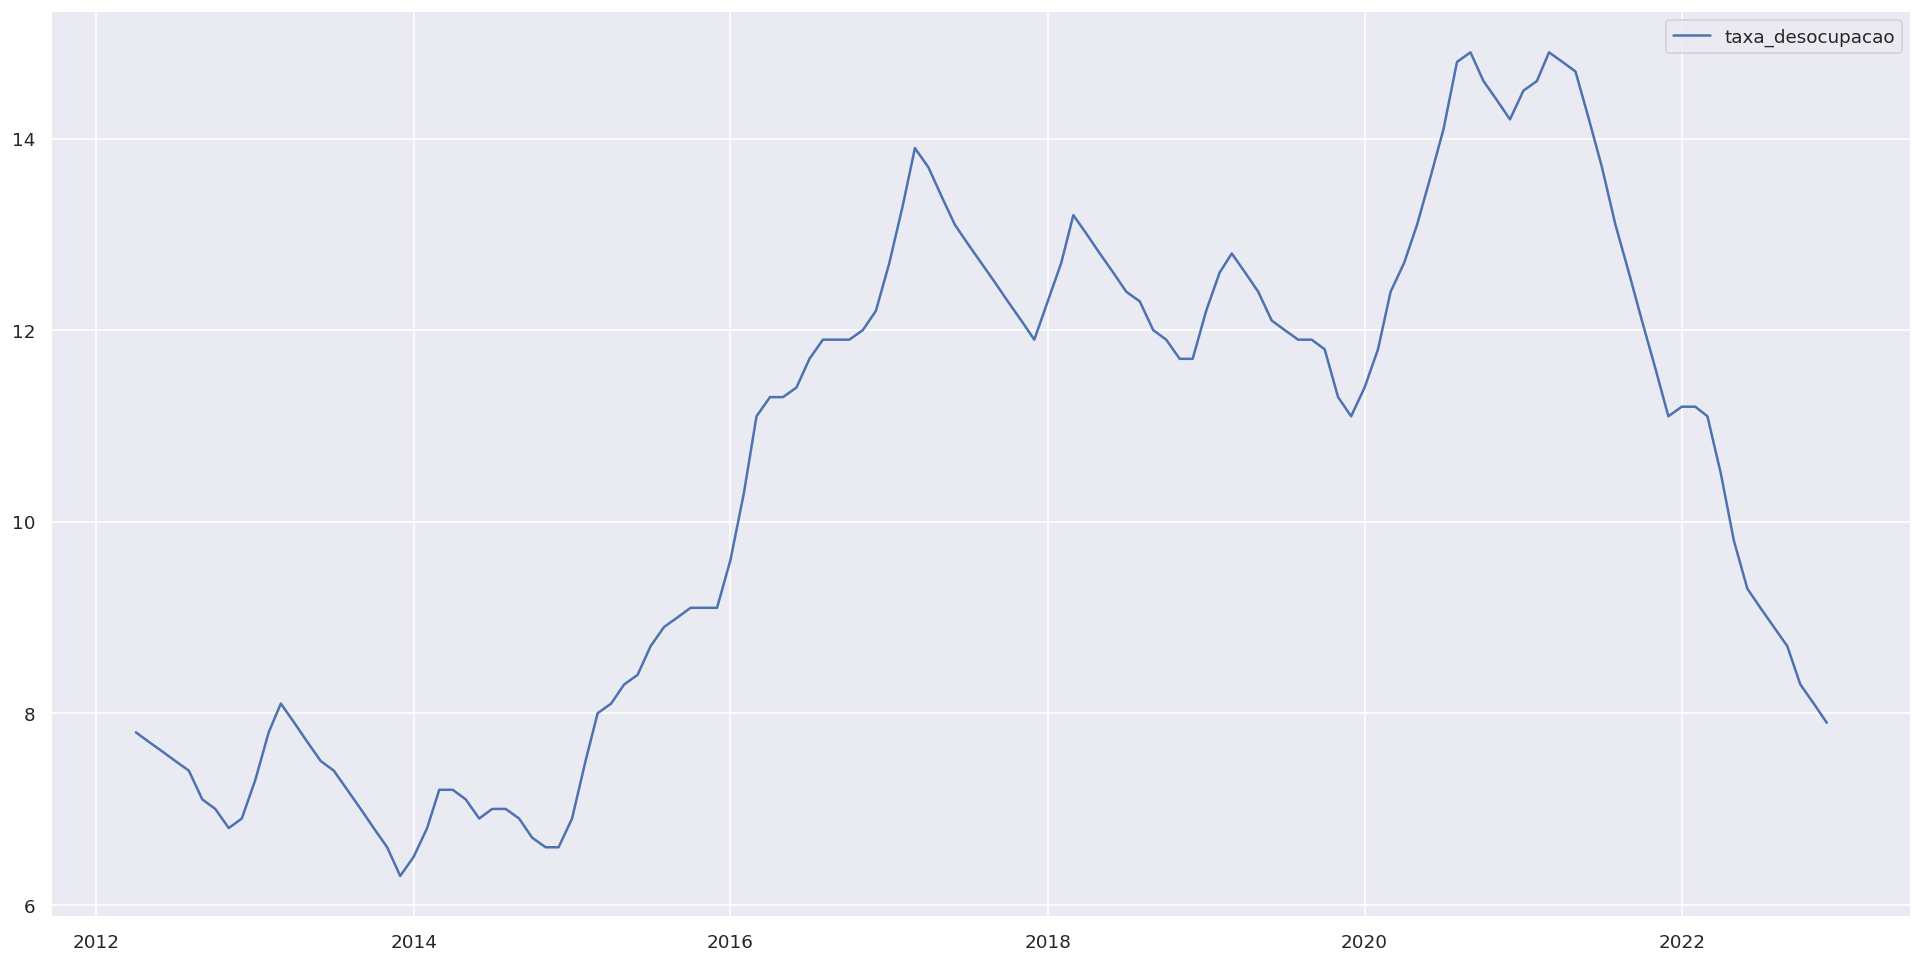

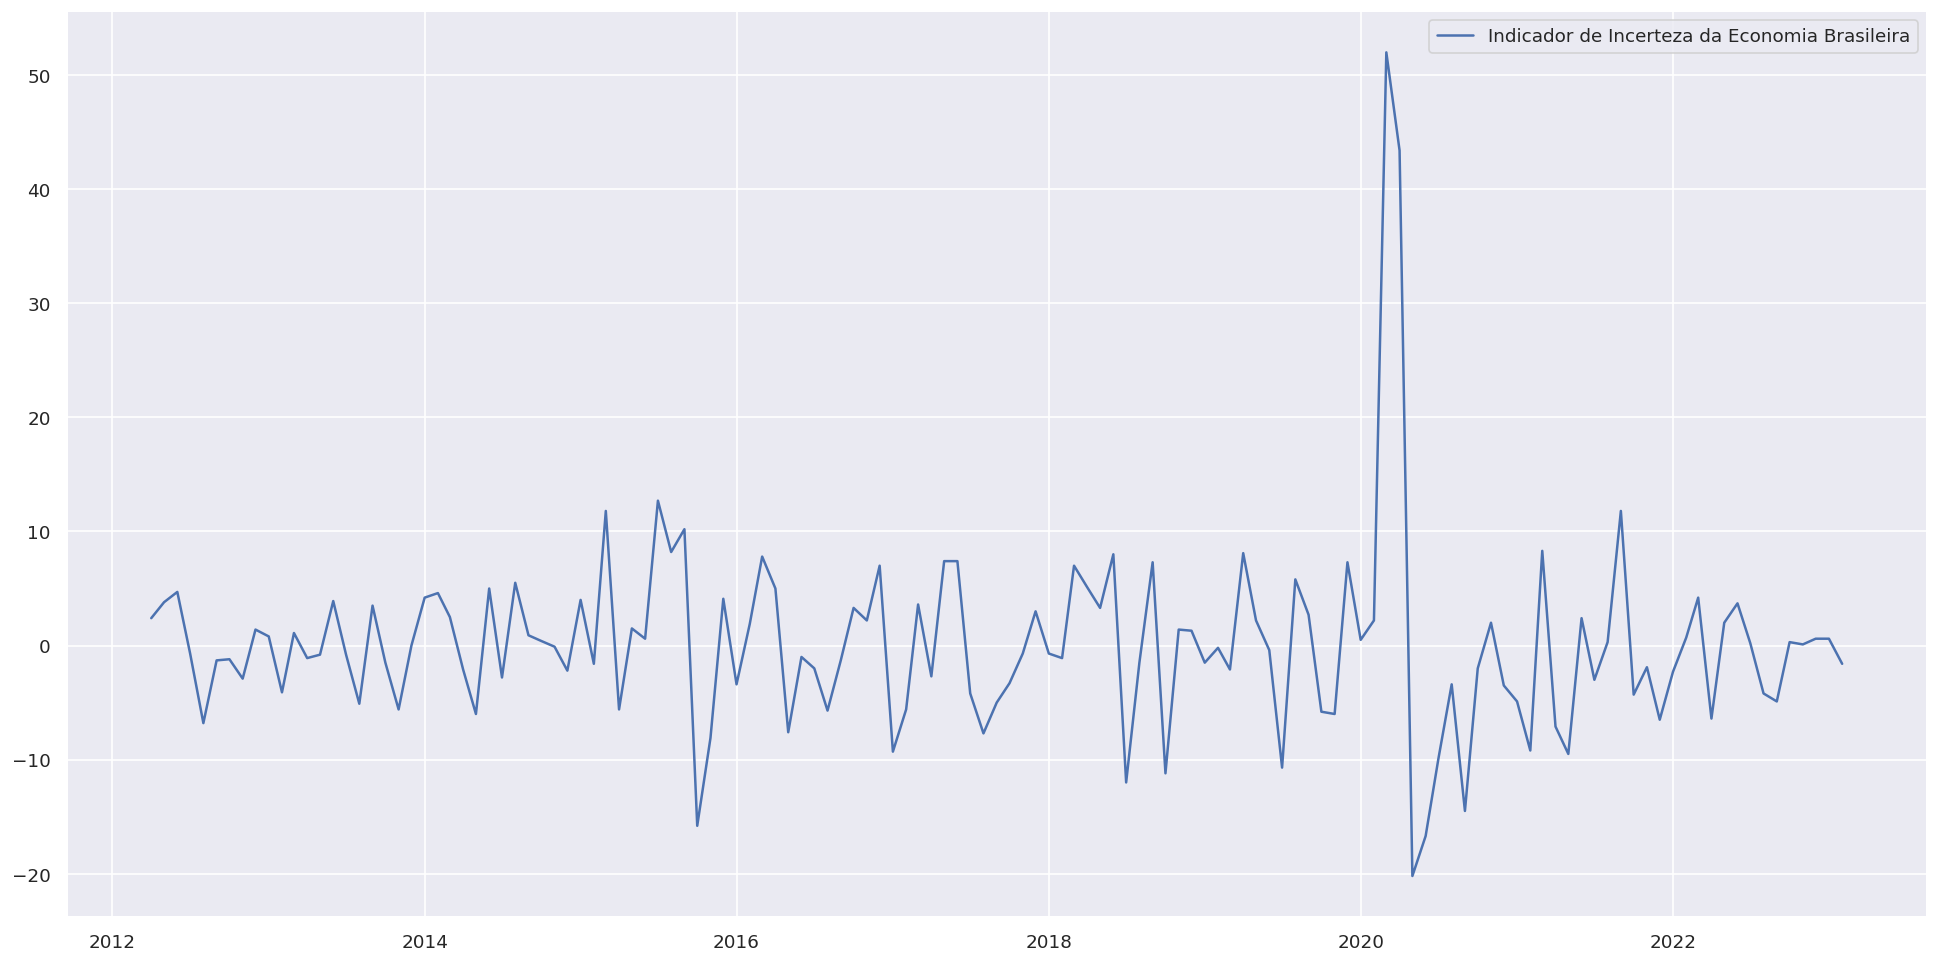

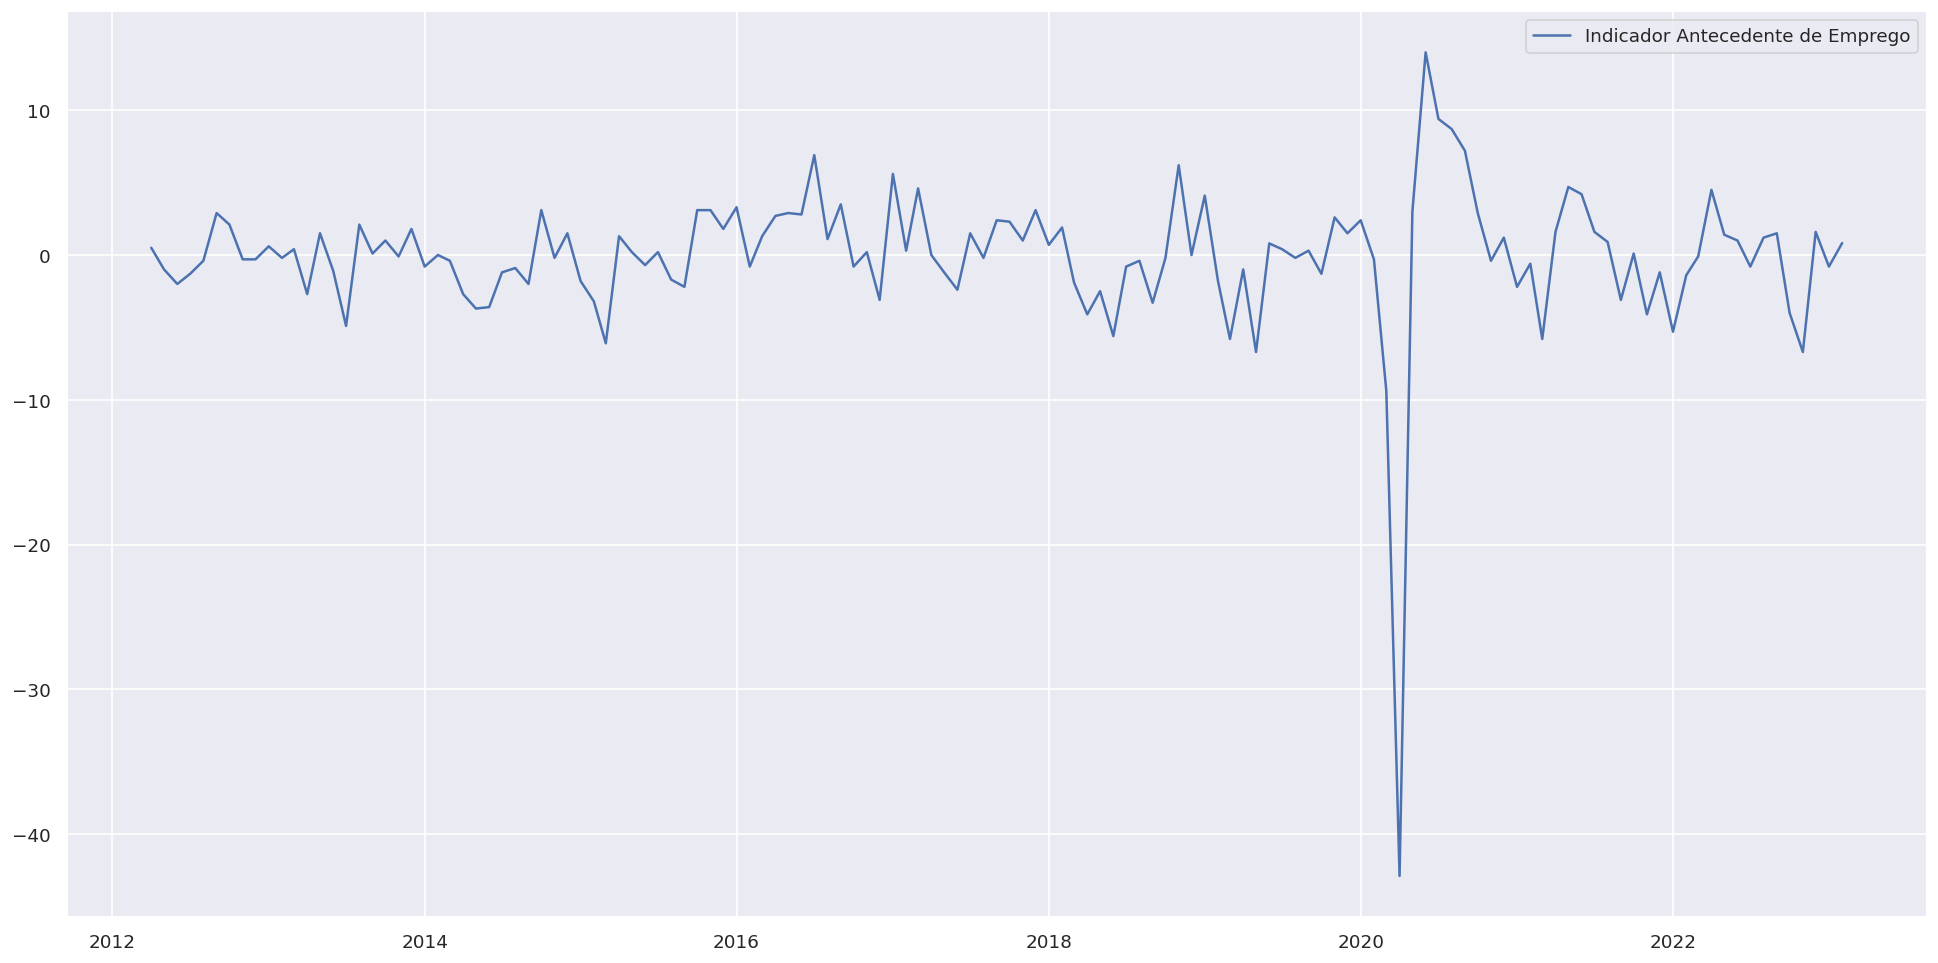

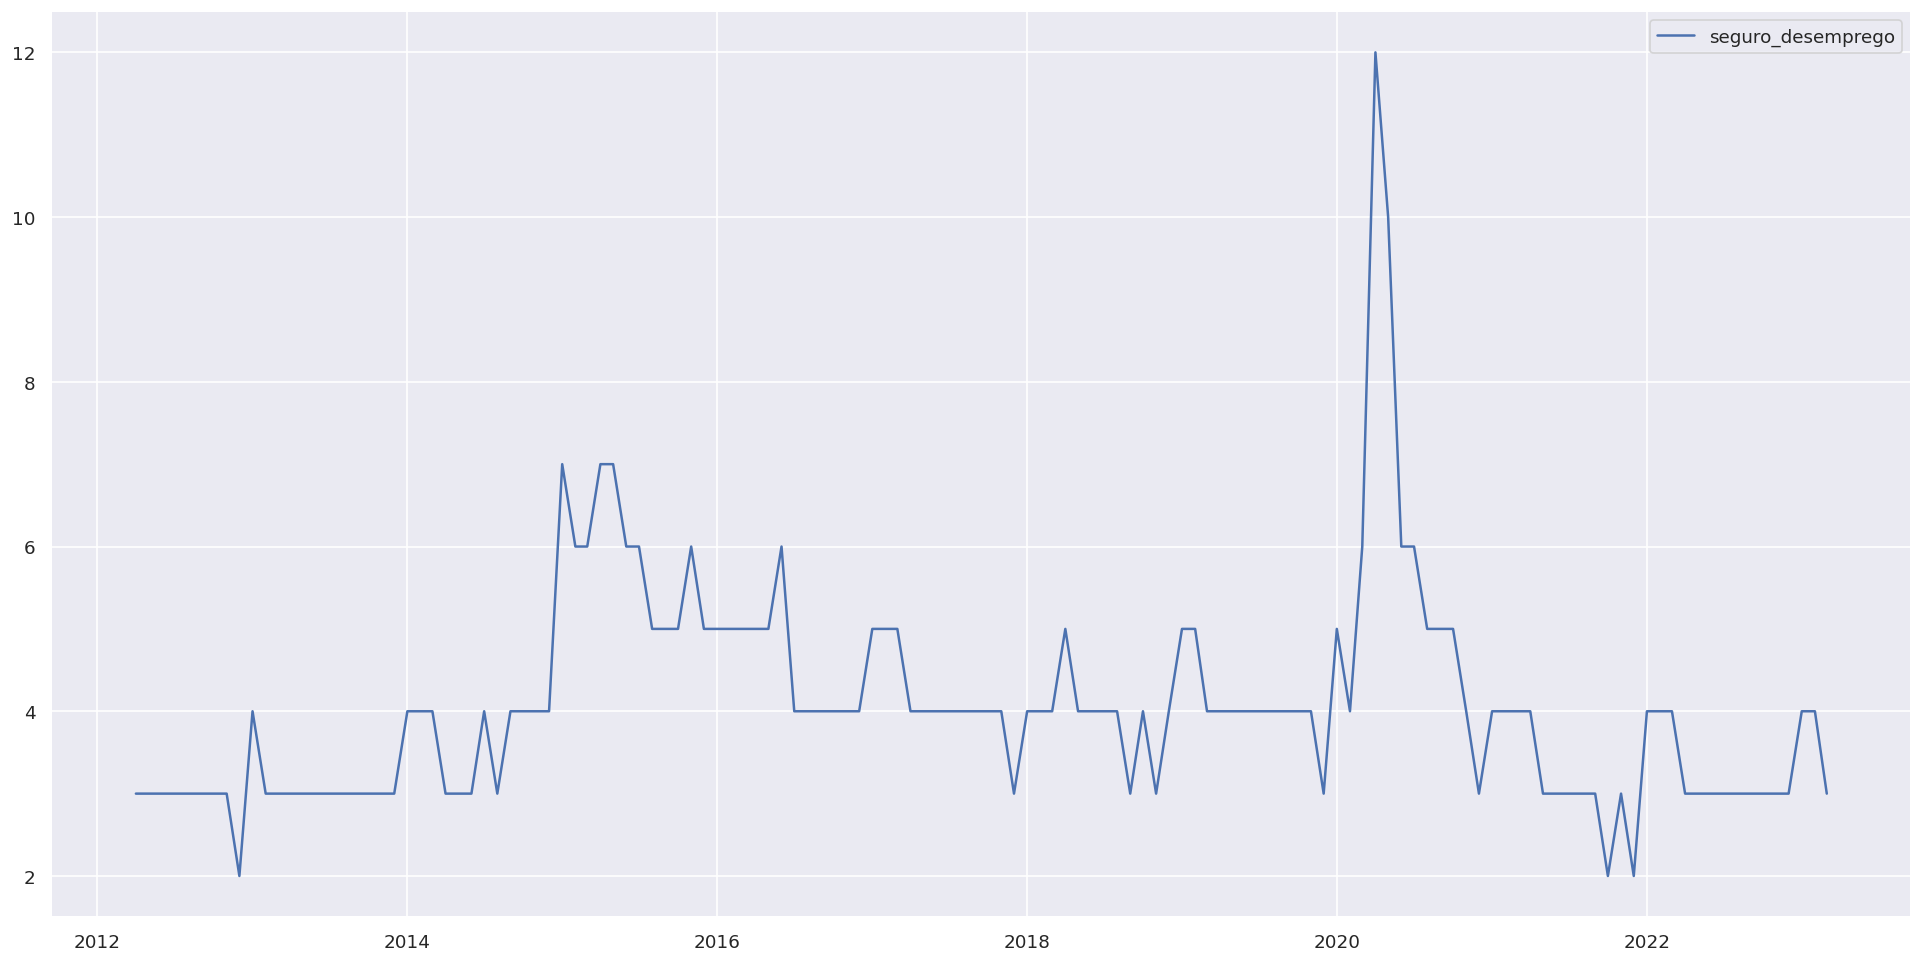

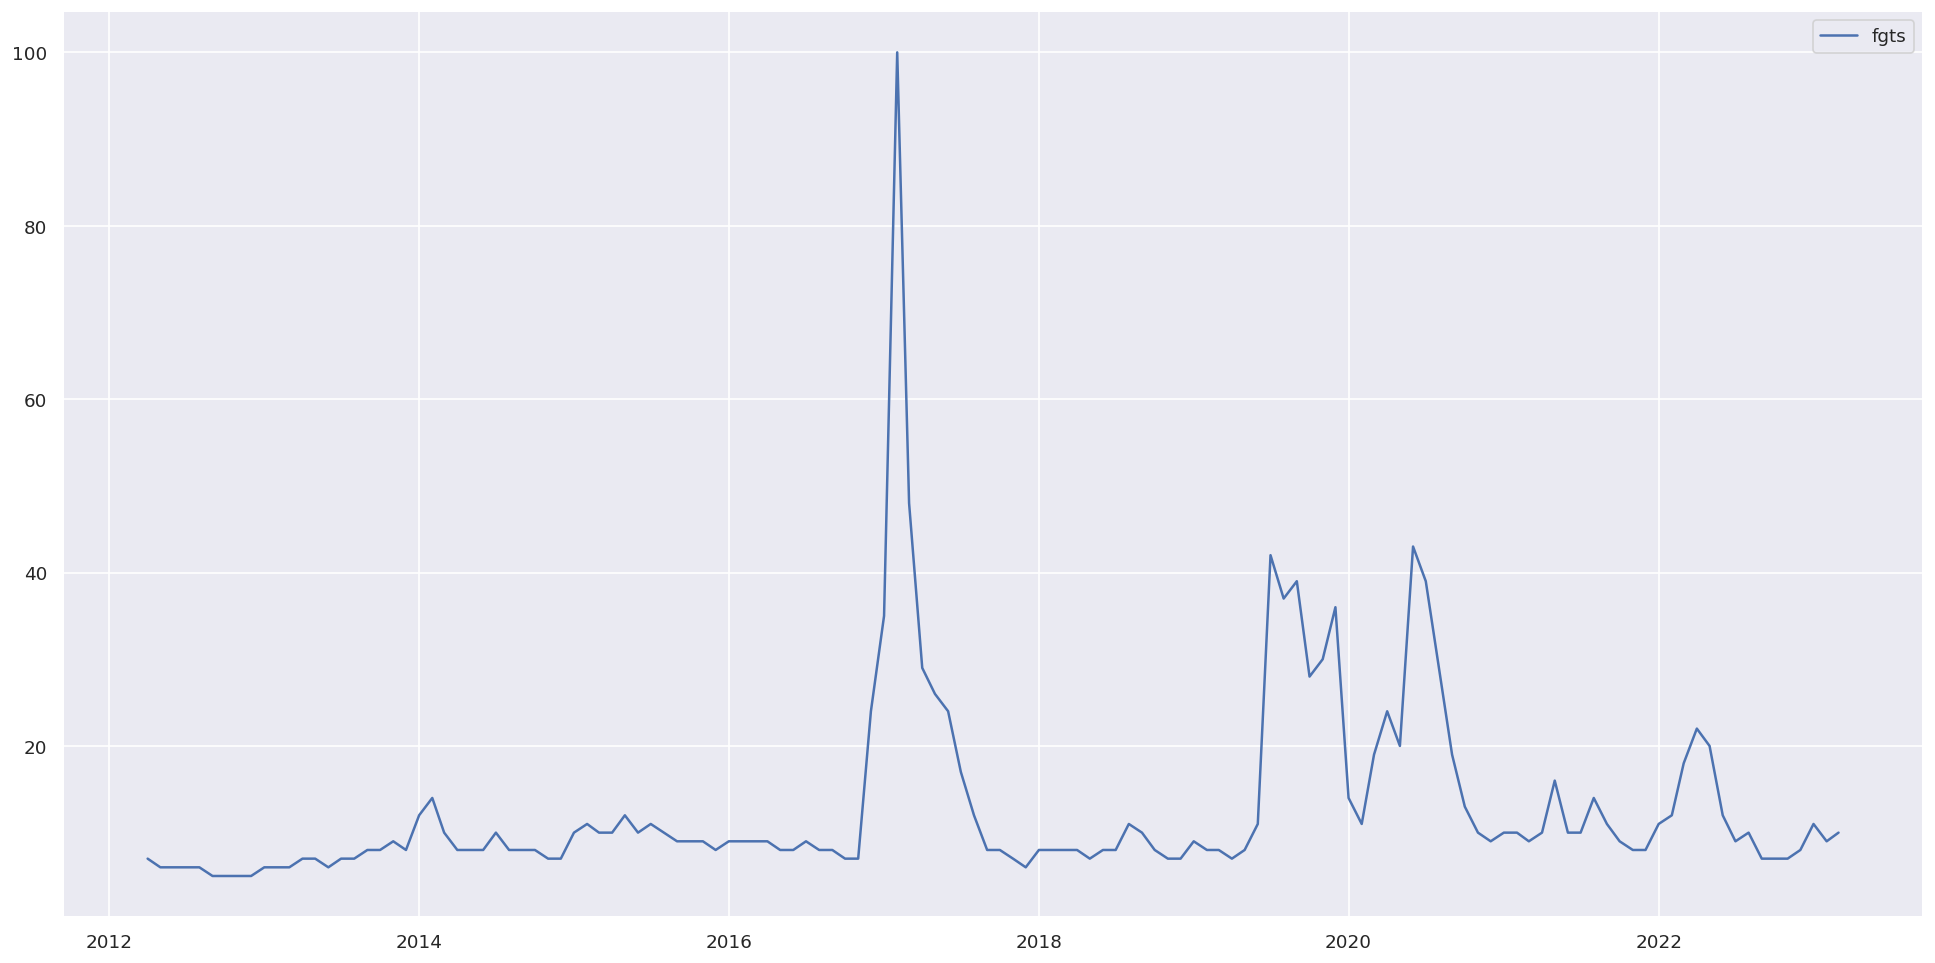

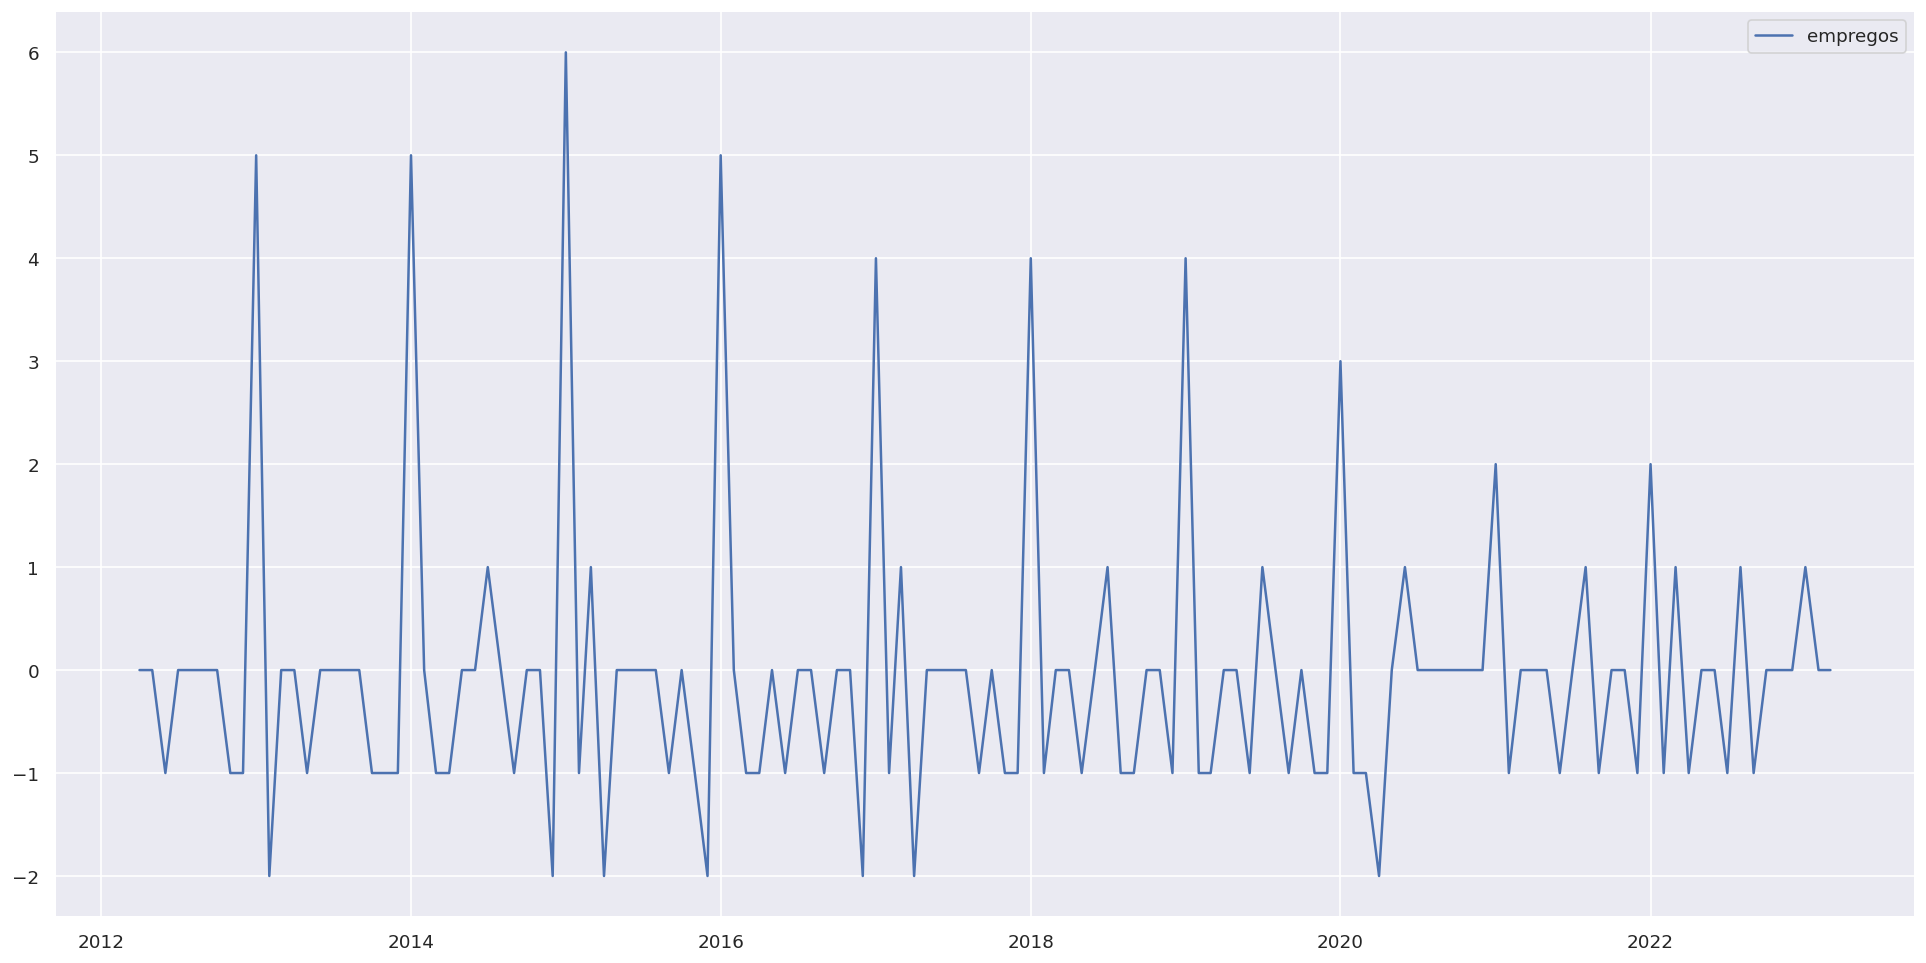

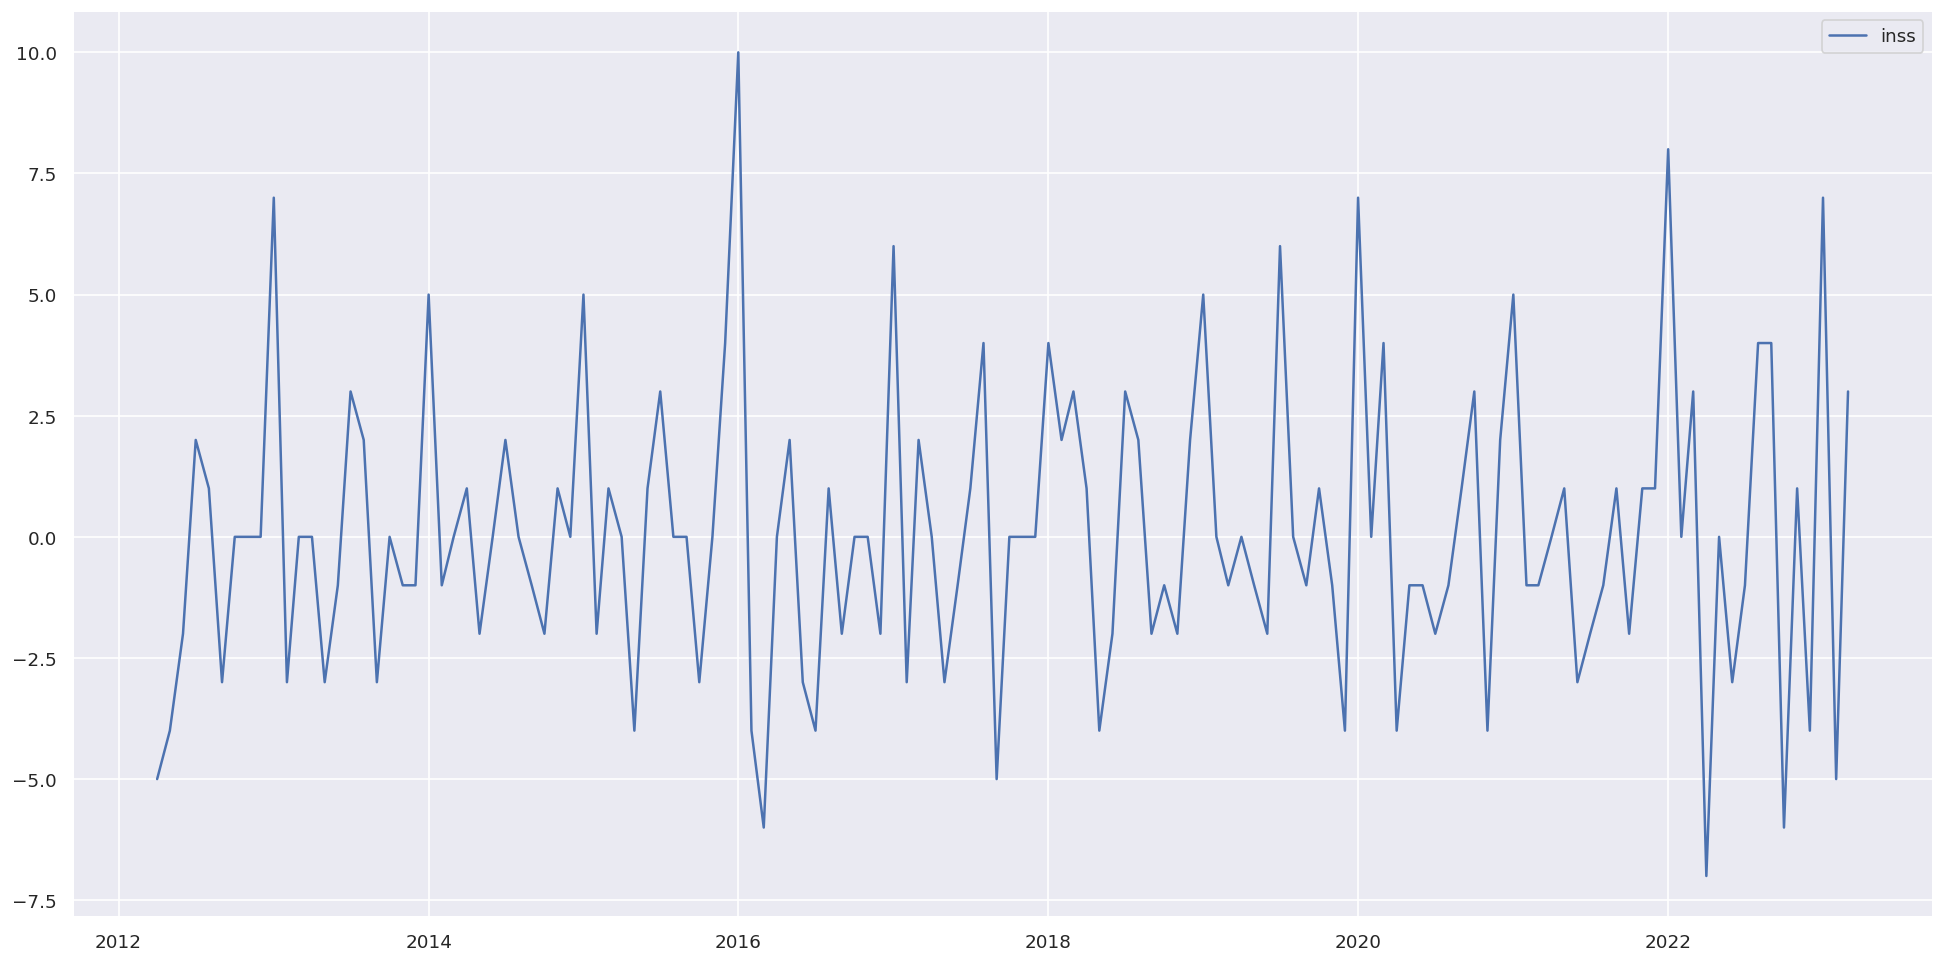

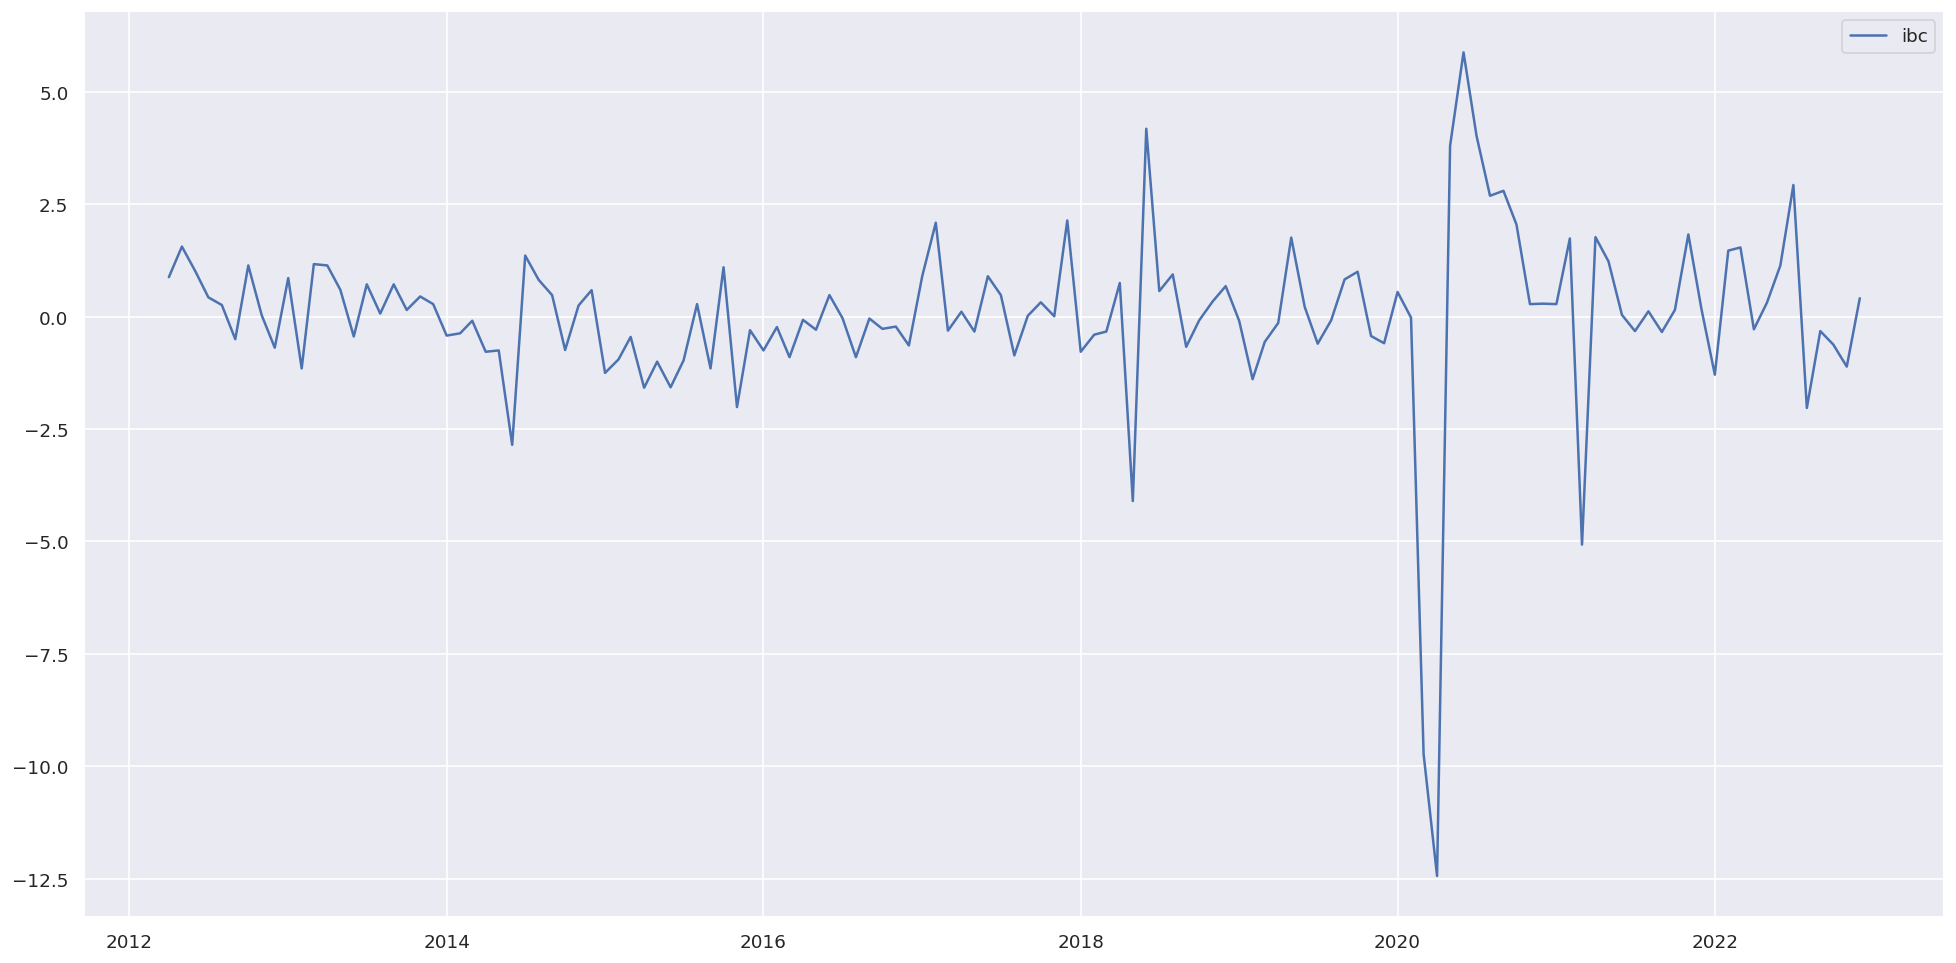

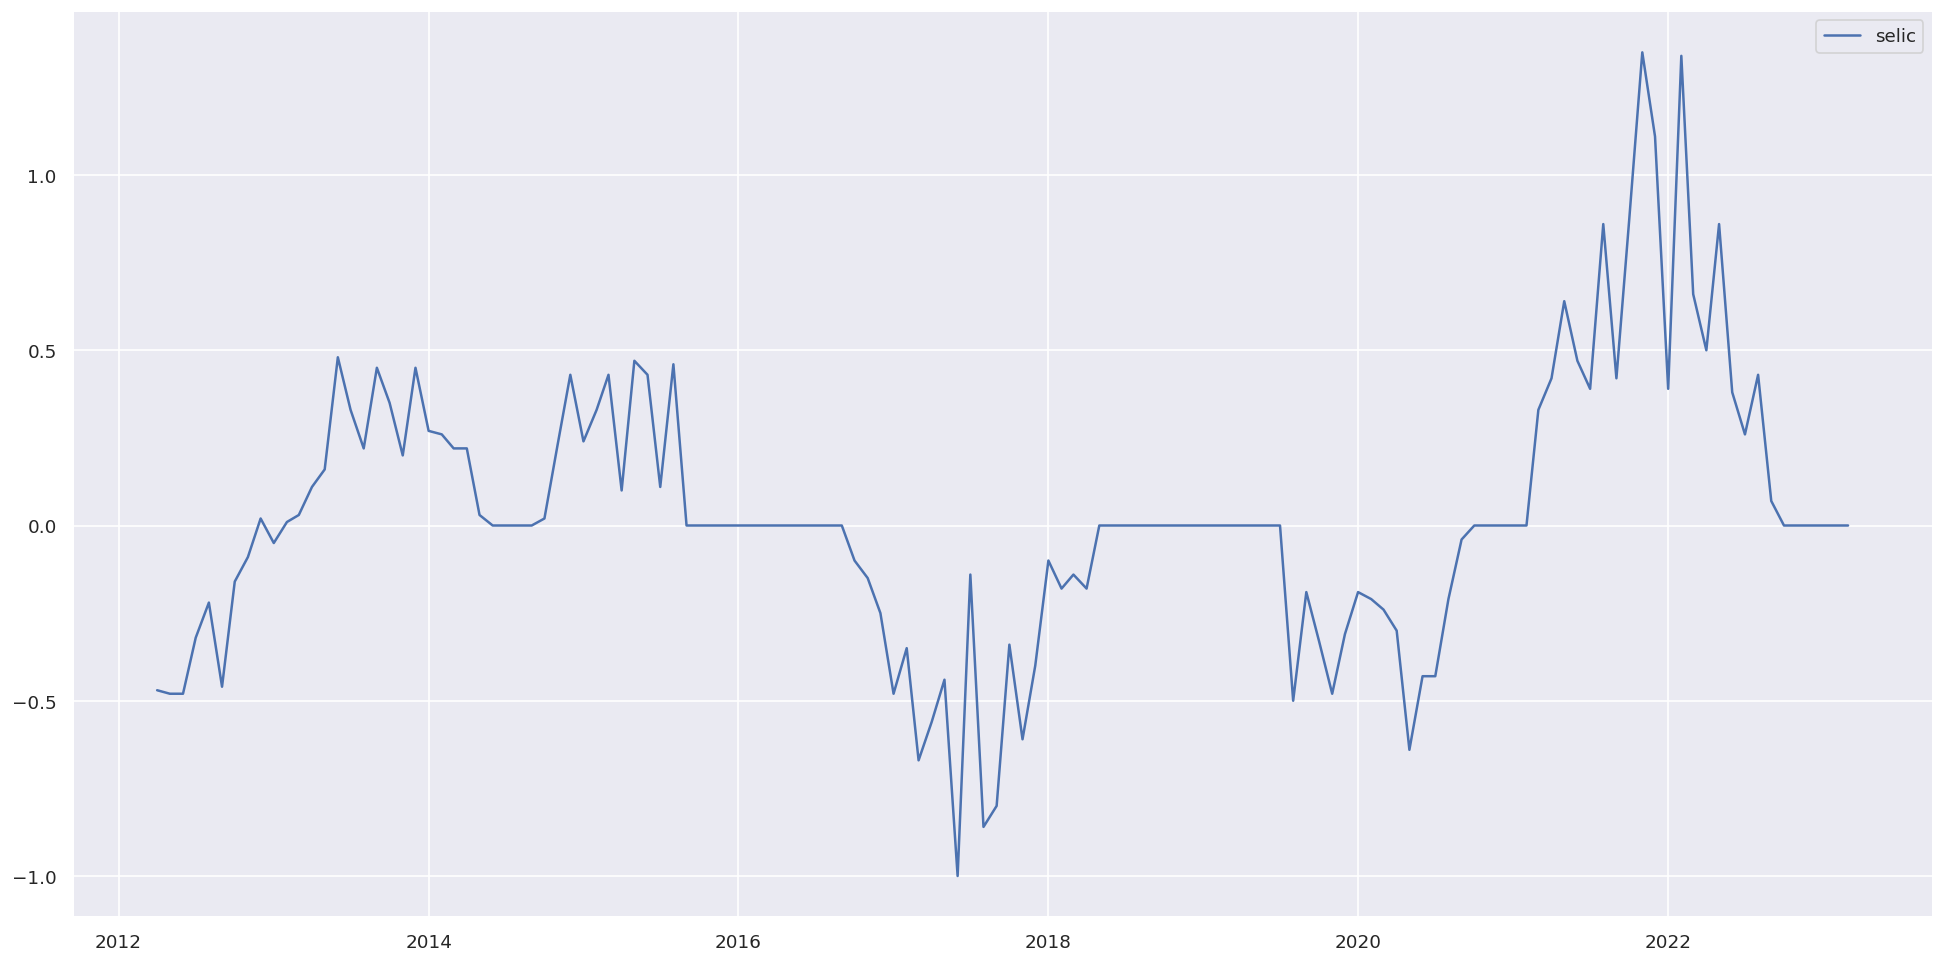

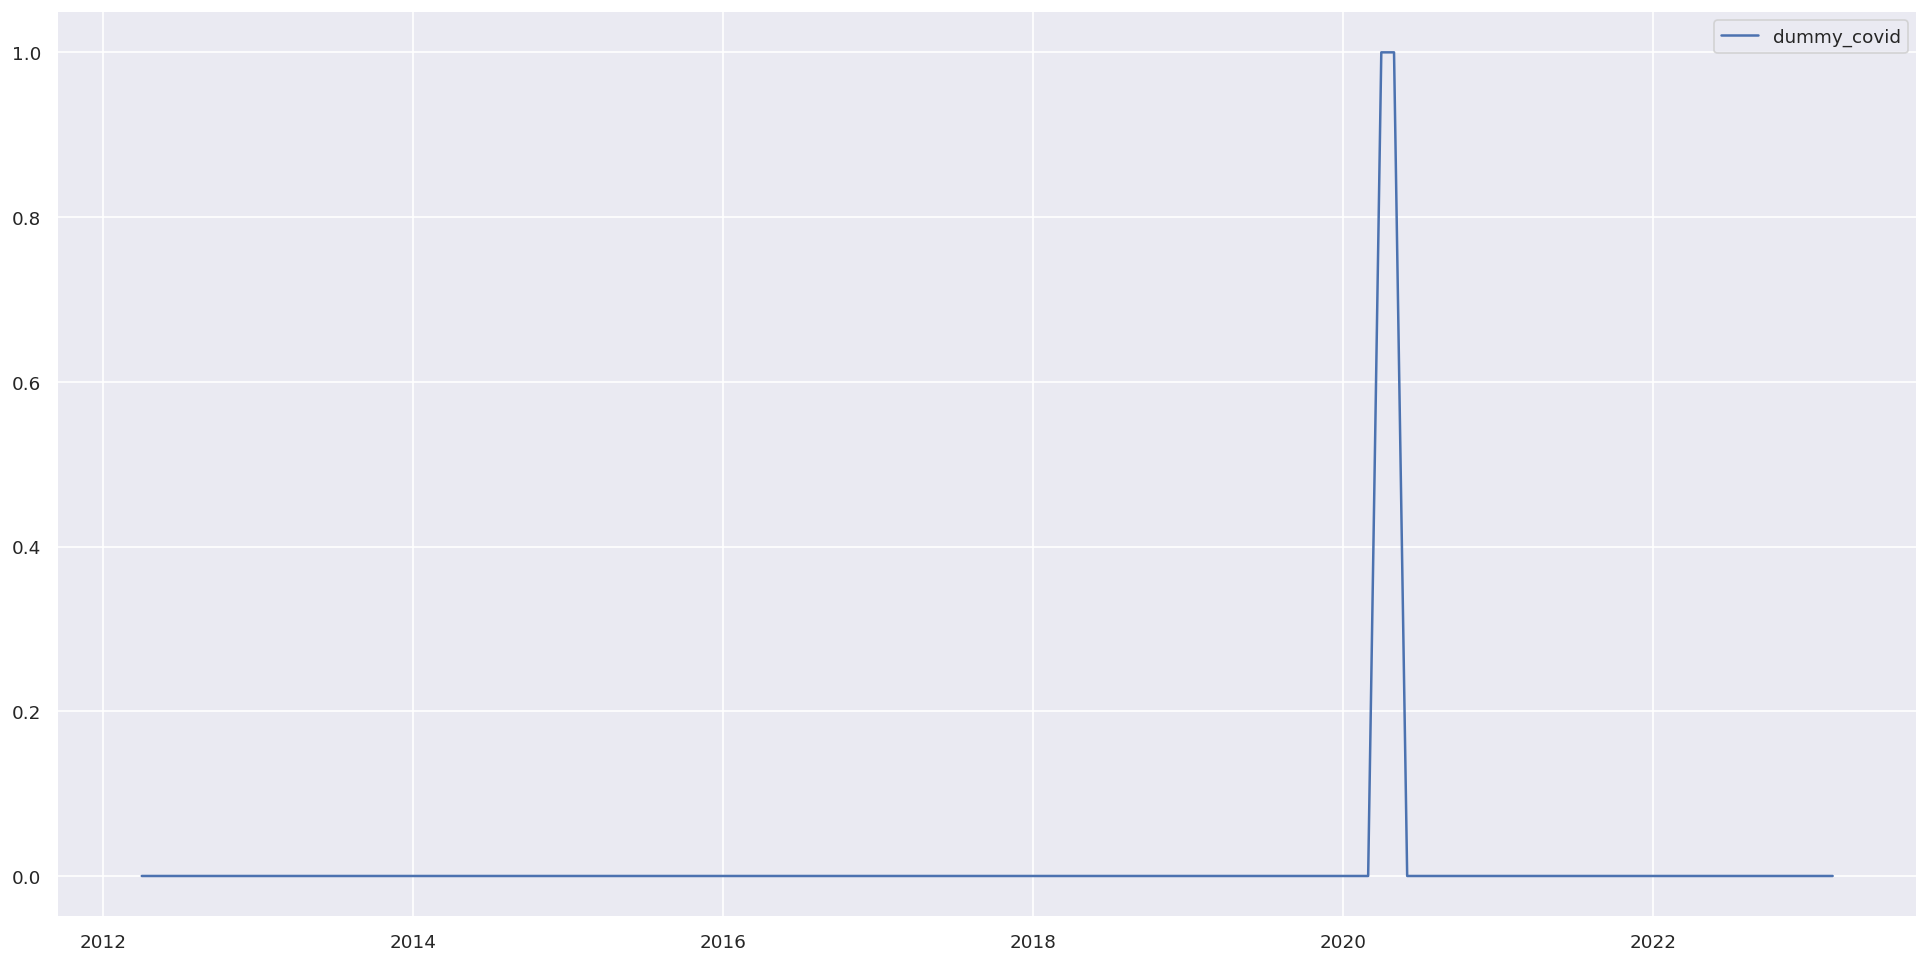

In [35]:
plotar(dados_est)

In [36]:
report_ndiffs(dados_est)

kpss  adf  pp  Ndifis
taxa_desocupacao                                  1    1   1       1
Indicador de Incerteza da Economia Brasileira     0    0   0       0
Indicador Antecedente de Emprego                  0    0   0       0
seguro_desemprego                                 0    1   0       0
fgts                                              0    0   0       0
empregos                                          0    0   0       0
inss                                              0    0   0       0
ibc                                               0    0   0       0
selic                                             0    1   0       0
dummy_covid                                       0    0   0       0

##Epandir base criando defasagens

In [37]:
def criando_defasagens(base,numero_defasagens=4):
  base_def = base.copy()
  for j in range(numero_defasagens):
    for i in base.columns:
      base_def[i+str('_lags_')+str(j+1)] = base_def[i].shift(j+1)
  return base_def

In [38]:
dados_defasados = criando_defasagens(dados_est,4)[4:]
dados_defasados.head()

taxa_desocupacao  Indicador de Incerteza da Economia Brasileira  \
2012-08-01              7.40                                          -6.80   
2012-09-01              7.10                                          -1.30   
2012-10-01              7.00                                          -1.20   
2012-11-01              6.80                                          -2.90   
2012-12-01              6.90                                           1.40   

            Indicador Antecedente de Emprego  seguro_desemprego  fgts  \
2012-08-01                             -0.40               3.00  6.00   
2012-09-01                              2.90               3.00  5.00   
2012-10-01                              2.10               3.00  5.00   
2012-11-01                             -0.30               3.00  5.00   
2012-12-01                             -0.30               2.00  5.00   

            empregos  inss   ibc  selic  dummy_covid  ...  \
2012-08-01      0.00  1.00  0.26  -0.22            0  ...   
2012-09-01      0.00 -3.00 -0.50  -0.46            0  ...   
2012-10-01      0.00  0.00  1.14  -0.16            0  ...   
2012-11-01     -1.00  0.00  0.03  -0.09            0  ...   
2012-12-01     -1.00  0.00 -0.69   0.02            0  ...   

            taxa_desocupacao_lags_4  \
2012-08-01                     7.80   
2012-09-01                     7.70   
2012-10-01                     7.60   
2012-11-01                     7.50   
2012-12-01                     7.40   

            Indicador de Incerteza da Economia Brasileira_lags_4  \
2012-08-01                                               2.40      
2012-09-01                                               3.80      
2012-10-01                                               4.70      
2012-11-01                                              -0.70      
2012-12-01                                              -6.80      

            Indicador Antecedente de Emprego_lags_4  seguro_desemprego_lags_4  \
2012-08-01                                     0.50                      3.00   
2012-09-01                                    -1.00                      3.00   
2012-10-01                                    -2.00                      3.00   
2012-11-01                                    -1.30                      3.00   
2012-12-01                                    -0.40                      3.00   

            fgts_lags_4  empregos_lags_4  inss_lags_4  ibc_lags_4  \
2012-08-01         7.00             0.00        -5.00        0.88   
2012-09-01         6.00             0.00        -4.00        1.56   
2012-10-01         6.00            -1.00        -2.00        1.01   
2012-11-01         6.00             0.00         2.00        0.43   
2012-12-01         6.00             0.00         1.00        0.26   

            selic_lags_4  dummy_covid_lags_4  
2012-08-01         -0.47                0.00  
2012-09-01         -0.48                0.00  
2012-10-01         -0.48                0.00  
2012-11-01         -0.32                0.00  
2012-12-01         -0.22                0.00  

[5 rows x 50 columns]

##Dividindo os dados em treino e teste

In [39]:
dados_defasados

taxa_desocupacao  Indicador de Incerteza da Economia Brasileira  \
2012-08-01              7.40                                          -6.80   
2012-09-01              7.10                                          -1.30   
2012-10-01              7.00                                          -1.20   
2012-11-01              6.80                                          -2.90   
2012-12-01              6.90                                           1.40   
...                      ...                                            ...   
2022-11-01              8.10                                           0.10   
2022-12-01              7.90                                           0.60   
2023-01-01               NaN                                           0.60   
2023-02-01               NaN                                          -1.60   
2023-03-01               NaN                                            NaN   

            Indicador Antecedente de Emprego  seguro_desemprego  fgts  \
2012-08-01                             -0.40               3.00  6.00   
2012-09-01                              2.90               3.00  5.00   
2012-10-01                              2.10               3.00  5.00   
2012-11-01                             -0.30               3.00  5.00   
2012-12-01                             -0.30               2.00  5.00   
...                                      ...                ...   ...   
2022-11-01                             -6.70               3.00  7.00   
2022-12-01                              1.60               3.00  8.00   
2023-01-01                             -0.80               4.00 11.00   
2023-02-01                              0.82               4.00  9.00   
2023-03-01                               NaN               3.00 10.00   

            empregos  inss   ibc  selic  dummy_covid  ...  \
2012-08-01      0.00  1.00  0.26  -0.22            0  ...   
2012-09-01      0.00 -3.00 -0.50  -0.46            0  ...   
2012-10-01      0.00  0.00  1.14  -0.16            0  ...   
2012-11-01     -1.00  0.00  0.03  -0.09            0  ...   
2012-12-01     -1.00  0.00 -0.69   0.02            0  ...   
...              ...   ...   ...    ...          ...  ...   
2022-11-01      0.00  1.00 -1.11   0.00            0  ...   
2022-12-01      0.00 -4.00  0.41   0.00            0  ...   
2023-01-01      1.00  7.00   NaN   0.00            0  ...   
2023-02-01      0.00 -5.00   NaN   0.00            0  ...   
2023-03-01      0.00  3.00   NaN   0.00            0  ...   

            taxa_desocupacao_lags_4  \
2012-08-01                     7.80   
2012-09-01                     7.70   
2012-10-01                     7.60   
2012-11-01                     7.50   
2012-12-01                     7.40   
...                             ...   
2022-11-01                     9.10   
2022-12-01                     8.90   
2023-01-01                     8.70   
2023-02-01                     8.30   
2023-03-01                     8.10   

            Indicador de Incerteza da Economia Brasileira_lags_4  \
2012-08-01                                               2.40      
2012-09-01                                               3.80      
2012-10-01                                               4.70      
2012-11-01                                              -0.70      
2012-12-01                                              -6.80      
...                                                       ...      
2022-11-01                                               0.20      
2022-12-01                                              -4.20      
2023-01-01                                              -4.90      
2023-02-01                                               0.30      
2023-03-01                                               0.10      

            Indicador Antecedente de Emprego_lags_4  seguro_desemprego_lags_4  \
2012-08-01                                     0.50                      3.00   
2012-

In [40]:
treino = dados_defasados[dados_defasados.index < pd.to_datetime('2022-01-01')]

In [41]:
treino

taxa_desocupacao  Indicador de Incerteza da Economia Brasileira  \
2012-08-01              7.40                                          -6.80   
2012-09-01              7.10                                          -1.30   
2012-10-01              7.00                                          -1.20   
2012-11-01              6.80                                          -2.90   
2012-12-01              6.90                                           1.40   
...                      ...                                            ...   
2021-08-01             13.10                                           0.30   
2021-09-01             12.60                                          11.80   
2021-10-01             12.10                                          -4.30   
2021-11-01             11.60                                          -1.90   
2021-12-01             11.10                                          -6.50   

            Indicador Antecedente de Emprego  seguro_desemprego  fgts  \
2012-08-01                             -0.40               3.00  6.00   
2012-09-01                              2.90               3.00  5.00   
2012-10-01                              2.10               3.00  5.00   
2012-11-01                             -0.30               3.00  5.00   
2012-12-01                             -0.30               2.00  5.00   
...                                      ...                ...   ...   
2021-08-01                              0.90               3.00 14.00   
2021-09-01                             -3.10               3.00 11.00   
2021-10-01                              0.10               2.00  9.00   
2021-11-01                             -4.10               3.00  8.00   
2021-12-01                             -1.20               2.00  8.00   

            empregos  inss   ibc  selic  dummy_covid  ...  \
2012-08-01      0.00  1.00  0.26  -0.22            0  ...   
2012-09-01      0.00 -3.00 -0.50  -0.46            0  ...   
2012-10-01      0.00  0.00  1.14  -0.16            0  ...   
2012-11-01     -1.00  0.00  0.03  -0.09            0  ...   
2012-12-01     -1.00  0.00 -0.69   0.02            0  ...   
...              ...   ...   ...    ...          ...  ...   
2021-08-01      1.00 -1.00  0.12   0.86            0  ...   
2021-09-01     -1.00  1.00 -0.34   0.42            0  ...   
2021-10-01      0.00 -2.00  0.15   0.87            0  ...   
2021-11-01      0.00  1.00  1.83   1.35            0  ...   
2021-12-01     -1.00  1.00  0.18   1.11            0  ...   

            taxa_desocupacao_lags_4  \
2012-08-01                     7.80   
2012-09-01                     7.70   
2012-10-01                     7.60   
2012-11-01                     7.50   
2012-12-01                     7.40   
...                             ...   
2021-08-01                    14.80   
2021-09-01                    14.70   
2021-10-01                    14.20   
2021-11-01                    13.70   
2021-12-01                    13.10   

            Indicador de Incerteza da Economia Brasileira_lags_4  \
2012-08-01                                               2.40      
2012-09-01                                               3.80      
2012-10-01                                               4.70      
2012-11-01                                              -0.70      
2012-12-01                                              -6.80      
...                                                       ...      
2021-08-01                                              -7.10      
2021-09-01                                              -9.50      
2021-10-01                                               2.40      
2021-11-01                                              -3.00      
2021-12-01                                               0.30      

            Indicador Antecedente de Emprego_lags_4  seguro_desemprego_lags_4  \
2012-08-01                                     0.50                      3.00   
2012-

In [42]:
y_treino = treino['taxa_desocupacao'].values
x_treino = treino.loc[:,treino.columns != 'taxa_desocupacao'].values

In [43]:
teste = dados_defasados[dados_defasados.index >= pd.to_datetime('2022-01-01')]

In [44]:
##Criando os dados de validacao com os dados que nao tem ainda
dados_predicao = teste[teste['taxa_desocupacao'].isnull()]
dados_predicao.drop('taxa_desocupacao',axis=1,inplace=True)
dados_predicao

<ipython-input-44-9b6262521570>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_predicao.drop('taxa_desocupacao',axis=1,inplace=True)


Indicador de Incerteza da Economia Brasileira  \
2023-01-01                                           0.60   
2023-02-01                                          -1.60   
2023-03-01                                            NaN   

            Indicador Antecedente de Emprego  seguro_desemprego  fgts  \
2023-01-01                             -0.80               4.00 11.00   
2023-02-01                              0.82               4.00  9.00   
2023-03-01                               NaN               3.00 10.00   

            empregos  inss  ibc  selic  dummy_covid  taxa_desocupacao_lags_1  \
2023-01-01      1.00  7.00  NaN   0.00            0                     7.90   
2023-02-01      0.00 -5.00  NaN   0.00            0                      NaN   
2023-03-01      0.00  3.00  NaN   0.00            0                      NaN   

            ...  taxa_desocupacao_lags_4  \
2023-01-01  ...                     8.70   
2023-02-01  ...                     8.30   
2023-03-01  ...                     8.10   

            Indicador de Incerteza da Economia Brasileira_lags_4  \
2023-01-01                                              -4.90      
2023-02-01                                               0.30      
2023-03-01                                               0.10      

            Indicador Antecedente de Emprego_lags_4  seguro_desemprego_lags_4  \
2023-01-01                                     1.50                      3.00   
2023-02-01                                    -4.00                      3.00   
2023-03-01                                    -6.70                      3.00   

            fgts_lags_4  empregos_lags_4  inss_lags_4  ibc_lags_4  \
2023-01-01         7.00            -1.00         4.00       -0.32   
2023-02-01         7.00             0.00        -6.00       -0.62   
2023-03-01         7.00             0.00         1.00       -1.11   

            selic_lags_4  dummy_covid_lags_4  
2023-01-01          0.07                0.00  
2023-02-01          0.00                0.00  
2023-03-01          0.00                0.00  

[3 rows x 49 columns]

In [45]:
teste = teste.drop(dados_predicao.index)
y_teste = teste['taxa_desocupacao'].values
x_teste= teste.loc[:,teste.columns != 'taxa_desocupacao'].values

In [46]:
print('O tamanho do y_treino e ',y_treino.shape)
print('O tamanho do x_treino e ',x_treino.shape)
print('--------------------')
print('O tamanho do y_teste e ',y_teste.shape)
print('O tamanho do x_teste e ',x_teste.shape)
print('--------------------')
print('O tamanho dos dados para predicao sao ',dados_predicao.shape)

O tamanho do y_treino e  (113,)
O tamanho do x_treino e  (113, 49)
--------------------
O tamanho do y_teste e  (12,)
O tamanho do x_teste e  (12, 49)
--------------------
O tamanho dos dados para predicao sao  (3, 49)


#Treinando os modelos

##Aplicando Grid Search


###Treinando o RandomForestRegressor

RandomForestRegressor(max_depth=70, max_features=1, min_samples_split=11,
                      n_estimators=10)

In [175]:
from scipy.stats import randint as sp_randint

In [176]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
# definindo os hiperparâmetros
param_grid = {
  "n_estimators": [10, 20,50,60,100],
  "max_depth": [1,2,30,70,100],
  "min_samples_split": [2, 6,8,11],
  "min_samples_leaf": [1,4,9,11],
  "max_features": [1, 3,10,15,23],
  'criterion':['squared_error','absolute_error','friedman_mse']
}

# definição do RMSE como métrica de avaliação



# instanciando o modelo de random forest
rf = RandomForestRegressor()

# instanciando o randomized search
#random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, scoring= ['neg_root_mean_squared_error','neg_mean_absolute_percentage_error','neg_mean_absolute_error'], refit=False, cv=5, verbose=3)

search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring= 'neg_root_mean_squared_error', cv=5, verbose=3)


# fit no modelo
search.fit(x_treino, y_treino)

# print dos melhores hiperparâmetros



A saída de streaming foi truncada nas últimas 5000 linhas.
[CV 1/5] END criterion=friedman_mse, max_depth=30, max_features=10, min_samples_leaf=9, min_samples_split=2, n_estimators=10;, score=-1.653 total time=   0.0s
[CV 2/5] END criterion=friedman_mse, max_depth=30, max_features=10, min_samples_leaf=9, min_samples_split=2, n_estimators=10;, score=-0.990 total time=   0.0s
[CV 3/5] END criterion=friedman_mse, max_depth=30, max_features=10, min_samples_leaf=9, min_samples_split=2, n_estimators=10;, score=-0.501 total time=   0.0s
[CV 4/5] END criterion=friedman_mse, max_depth=30, max_features=10, min_samples_leaf=9, min_samples_split=2, n_estimators=10;, score=-0.817 total time=   0.0s
[CV 5/5] END criterion=friedman_mse, max_depth=30, max_features=10, min_samples_leaf=9, min_samples_split=2, n_estimators=10;, score=-2.128 total time=   0.0s
[CV 1/5] END criterion=friedman_mse, max_depth=30, max_features=10, min_samples_leaf=9, min_samples_split=2, n_estimators=20;, score=-1.737 total 

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'criterion': ['squared_error', 'absolute_error',
                                       'friedman_mse'],
                         'max_depth': [1, 2, 30, 70, 100],
                         'max_features': [1, 3, 10, 15, 23],
                         'min_samples_leaf': [1, 4, 9, 11],
                         'min_samples_split': [2, 6, 8, 11],
                         'n_estimators': [10, 20, 50, 60, 100]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [177]:
search.best_estimator_

RandomForestRegressor(max_depth=70, max_features=23, min_samples_split=6,
                      n_estimators=10)

###Treinando o Reggressao lasso

Model: Lasso
Best parameters: {'alpha': 3.1444639083259216}
Best cross-validation score: -9.982334856276303

In [178]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

models = [LinearRegression(), Ridge(), Lasso()]
param_grid = [
    {'fit_intercept': [True, False]},
    {'alpha': np.logspace(-3, 3, 1000)},
    {'alpha': np.logspace(-3, 3, 1020)}]
for model, param_grid_model in zip(models, param_grid):
    grid_search = GridSearchCV(model, param_grid_model, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
    grid_search.fit(x_treino, y_treino)
    print(f"Model: {type(model).__name__}")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_}")
    print("")


Model: LinearRegression
Best parameters: {'fit_intercept': False}
Best cross-validation score: -0.06840008987040472

Model: Ridge
Best parameters: {'alpha': 0.001}
Best cross-validation score: -0.07755211292847466



/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.204e-01, tolerance: 6.150e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.045e-01, tolerance: 7.072e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.621e-02, tolerance: 7.596e-02

Model: Lasso
Best parameters: {'alpha': 0.001}
Best cross-validation score: -0.06649176561142499



/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.207e-01, tolerance: 8.111e-02
  model = cd_fast.enet_coordinate_descent(


### Treinando gradiente Bosting 

{'learning_rate': 0.1,
 'loss': 'quantile',
 'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 250}

In [47]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
# instanciar o modelo de Gradient Boosting
model = GradientBoostingRegressor()

# definir os hiperparâmetros a serem testados
param_grid = {
    "loss":["ls", "lad", "huber", "quantile"],
    "learning_rate":[0.1, 0.05, 0.01],
    "n_estimators":[100, 250, 500],
    "max_depth":[3, 5, 7, 9],
    "min_samples_split":[2, 4, 8],
    "min_samples_leaf":[1, 2, 4]
}

# instanciar o GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error',verbose=3)

# fit no modelo
grid_search.fit(x_treino, y_treino)

# print dos melhores hiperparâmetros
print("Melhores hiperparâmetros: ", grid_search.best_params_)

# prever com os melhores hiperparâmetros
y_pred = grid_search.predict(x_teste)


A saída de streaming foi truncada nas últimas 5000 linhas.
[CV 1/5] END learning_rate=0.1, loss=huber, max_depth=7, min_samples_leaf=4, min_samples_split=8, n_estimators=500;, score=-0.227 total time=   2.0s
[CV 2/5] END learning_rate=0.1, loss=huber, max_depth=7, min_samples_leaf=4, min_samples_split=8, n_estimators=500;, score=-1.320 total time=   2.0s
[CV 3/5] END learning_rate=0.1, loss=huber, max_depth=7, min_samples_leaf=4, min_samples_split=8, n_estimators=500;, score=-0.133 total time=   2.1s
[CV 4/5] END learning_rate=0.1, loss=huber, max_depth=7, min_samples_leaf=4, min_samples_split=8, n_estimators=500;, score=-0.090 total time=   2.0s
[CV 5/5] END learning_rate=0.1, loss=huber, max_depth=7, min_samples_leaf=4, min_samples_split=8, n_estimators=500;, score=-1.482 total time=   2.4s
[CV 1/5] END learning_rate=0.1, loss=huber, max_depth=9, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-0.189 total time=   1.8s
[CV 2/5] END learning_rate=0.1, loss=huber, max

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
3240 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1620 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/utils/_p

Melhores hiperparâmetros:  {'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 100}


In [48]:
grid_search.best_params_

{'learning_rate': 0.1,
 'loss': 'huber',
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 100}

In [49]:
grid_search.best_score_

-0.4908548907714942

#Treinando os modelos com os melhores paramentros

In [100]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_regression(y_true, y_pred, algorithm):
    metrics = {}
    metrics['MAE'] = mean_absolute_error(y_true, y_pred)
    metrics['MSE'] = mean_squared_error(y_true, y_pred)
    metrics['RMSE'] = np.sqrt(metrics['MSE'])
    metrics['R²'] = r2_score(y_true, y_pred)
    metrics_df = pd.DataFrame(metrics, index=[algorithm])
    return metrics_df


In [101]:
#Best parameters: {'alpha': 0.001}
#Best cross-validation score: -0.07755211292847466
from sklearn.linear_model import LinearRegression, Ridge, Lasso
lasso = Lasso(random_state=0,alpha=3.1444639083259216)
lasso.fit(x_treino, y_treino)

Lasso(alpha=3.1444639083259216, random_state=0)

In [102]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(max_depth=70, max_features=23, min_samples_split=6,n_estimators=10)
#rfr = RandomForestRegressor(random_state=0,max_depth=70, max_features=1, min_samples_split=11, n_estimators=10)
rfr.fit(x_treino, y_treino)

RandomForestRegressor(max_depth=70, max_features=23, min_samples_split=6,
                      n_estimators=10)

In [103]:
melhores_parametros = {'learning_rate': 0.1, 'loss': 'quantile', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}
{'learning_rate': 0.1,
 'loss': 'huber',
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 100}

{'learning_rate': 0.1,
 'loss': 'huber',
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 100}

In [104]:
from sklearn.ensemble import GradientBoostingRegressor
grad_bost = GradientBoostingRegressor(random_state=0,learning_rate= 0.1, loss ='huber', max_depth= 3, min_samples_leaf = 1, min_samples_split = 8, n_estimators = 100)
grad_bost.fit(x_treino, y_treino)

GradientBoostingRegressor(loss='huber', min_samples_split=8, random_state=0)

In [105]:
import tensorflow as tf

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=40,activation='relu',input_shape=(x_treino.shape[1],),activity_regularizer='l1'))
model.add(tf.keras.layers.Dropout(0.11))
model.add(tf.keras.layers.Dense(units=40,activation='relu',activity_regularizer='l1'))
model.add(tf.keras.layers.Dropout(0.11))
model.add(tf.keras.layers.Dense(units=40,activation='relu',activity_regularizer='l1'))
model.add(tf.keras.layers.Dropout(0.11))
model.add(tf.keras.layers.Dense(units=40,activation='relu',activity_regularizer='l1'))
model.add(tf.keras.layers.Dropout(0.10))
model.add(tf.keras.layers.Dense(units=30,activation='relu',activity_regularizer='l1'))
model.add(tf.keras.layers.Dropout(0.10))
model.add(tf.keras.layers.Dense(units=25,activation='relu',activity_regularizer='l1'))
model.add(tf.keras.layers.Dropout(0.10))
model.add(tf.keras.layers.Dense(units=20,activation='relu',activity_regularizer='l1'))
model.add(tf.keras.layers.Dropout(0.10))
model.add(tf.keras.layers.Dense(units=10,activation='relu',activity_regularizer='l1'))
model.add(tf.keras.layers.Dropout(0.20))
model.add(tf.keras.layers.Dense(units=1,activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.fit(x_treino, y_treino, epochs=1000,batch_size=100)

Epoch 1/1000
2/2 [==============================] - 4s 11ms/step - loss: 139.0460 - mean_absolute_error: 11.3132
Epoch 2/1000
2/2 [==============================] - 0s 9ms/step - loss: 134.4163 - mean_absolute_error: 11.1355
Epoch 3/1000
2/2 [==============================] - 0s 13ms/step - loss: 130.9439 - mean_absolute_error: 10.9942
Epoch 4/1000
2/2 [==============================] - 0s 7ms/step - loss: 128.4189 - mean_absolute_error: 10.8903
Epoch 5/1000
2/2 [==============================] - 0s 9ms/step - loss: 126.6228 - mean_absolute_error: 10.8220
Epoch 6/1000
2/2 [==============================] - 0s 7ms/step - loss: 126.0006 - mean_absolute_error: 10.7969
Epoch 7/1000
2/2 [==============================] - 0s 21ms/step - loss: 125.2361 - mean_absolute_error: 10.7687
Epoch 8/1000
2/2 [==============================] - 0s 8ms/step - loss: 124.8915 - mean_absolute_error: 10.7568
Epoch 9/1000
2/2 [==============================] - 0s 14ms/step - loss: 124.6368 - mean_absolute_err

##Avaliando os residuos dos medelos

https://medium.com/@krzysztofdrelczuk/acf-autocorrelation-function-simple-explanation-with-python-example-492484c32711

###Regressao lasso


In [106]:
predic_treino_lasso = lasso.predict(x_treino)

In [107]:
residuo_lasso = y_treino - predic_treino_lasso

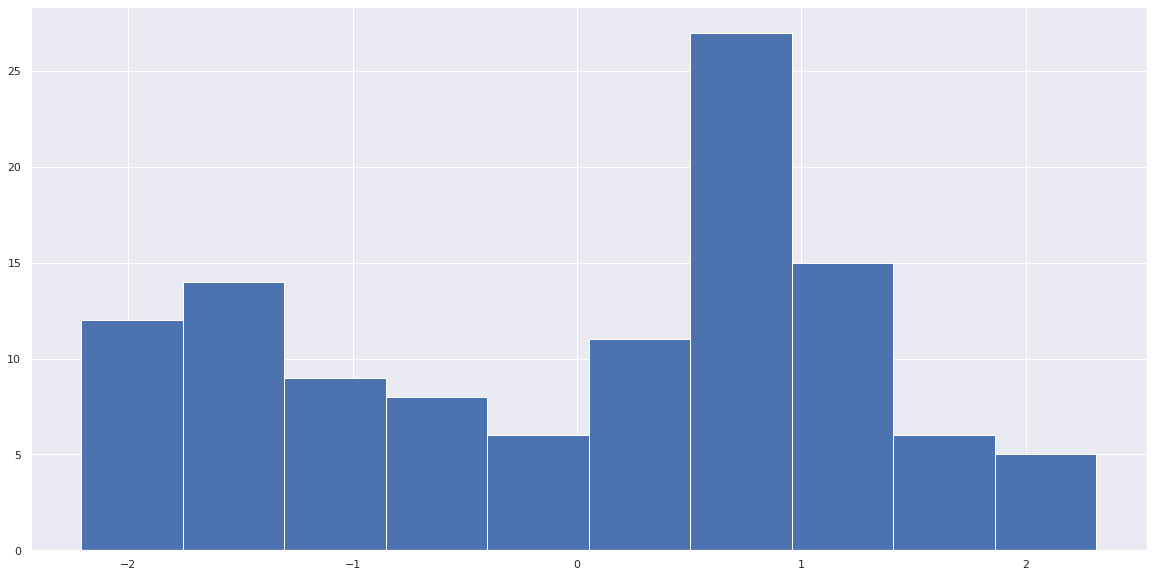

In [108]:
plt.hist(residuo_lasso);

In [109]:
import statsmodels.api as sm

Gráfico ACF de resíduos
Com dados de séries temporais, é altamente provável que o valor de uma variável observada no período de tempo atual seja semelhante ao seu valor no período anterior, ou mesmo no período anterior a esse, e assim por diante. Portanto, ao ajustar um modelo de regressão a dados de séries temporais, é comum encontrar autocorrelação nos resíduos. Nesse caso, o modelo estimado viola a suposição de não haver autocorrelação nos erros, e nossas previsões podem ser ineficientes — sobra alguma informação que deve ser contabilizada no modelo para obter melhores previsões. As previsões de um modelo com erros autocorrelacionados ainda não são viesadas e, portanto, não estão “erradas”, mas geralmente terão intervalos de previsão maiores do que o necessário. Portanto, devemos sempre olhar para um gráfico ACF dos resíduos.

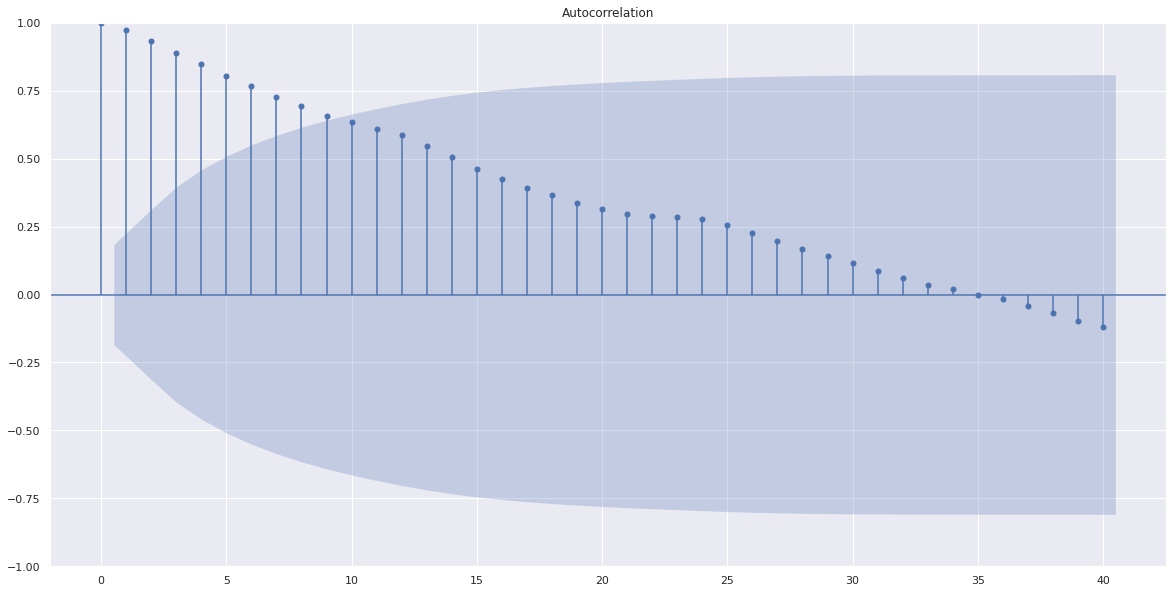

In [110]:
sm.graphics.tsa.plot_acf(residuo_lasso,lags=40)
plt.show()

###Random forest
RandomForestRegressor(max_depth=100, max_features=15, min_samples_leaf=4,
                      min_samples_split=8, n_estimators=20)

In [111]:
predic_rando_treino = rfr.predict(x_treino)

In [112]:
residuo_random = y_treino-predic_rando_treino

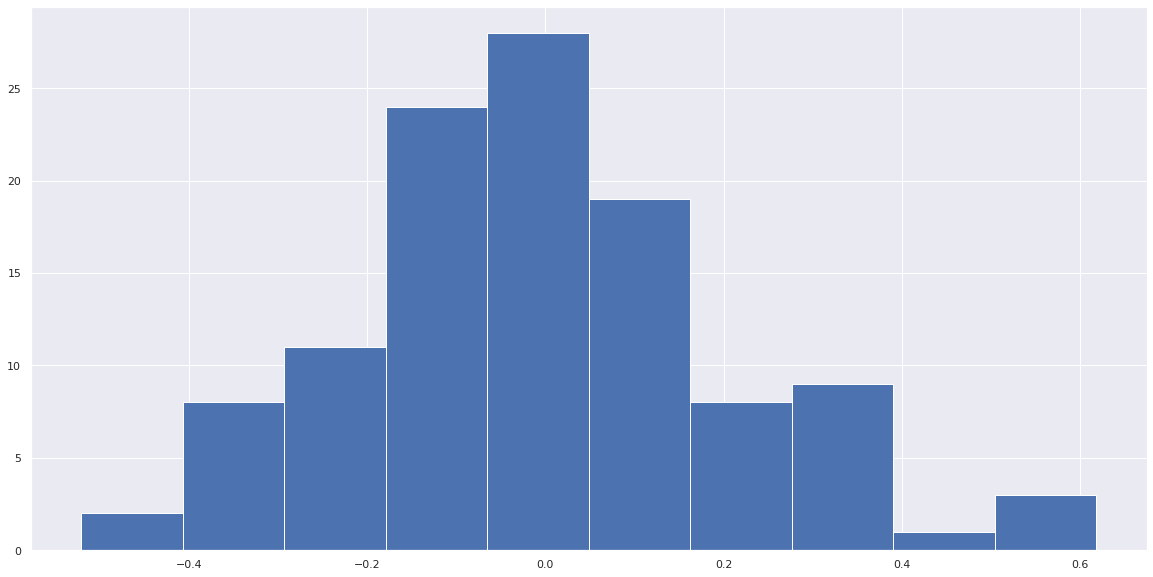

In [113]:
plt.hist(residuo_random);

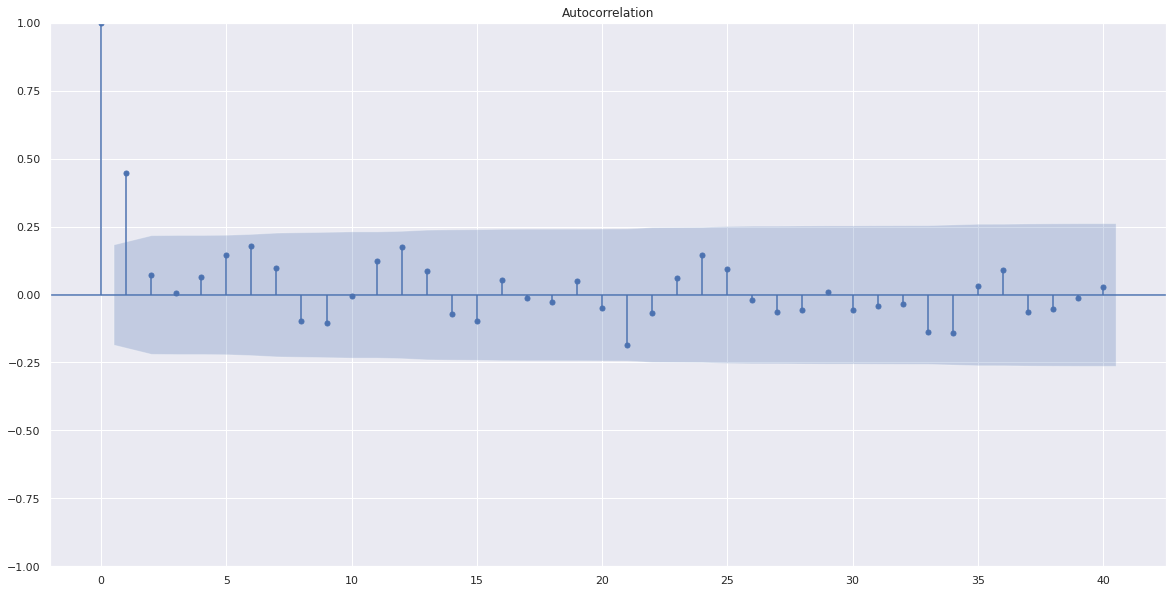

In [114]:
sm.graphics.tsa.plot_acf(residuo_random,lags=40)
plt.show()

###Gradiente Boosting


In [115]:
predict_grad_treino = grad_bost.predict(x_treino)

In [116]:
residuo_grad = y_treino - predict_grad_treino

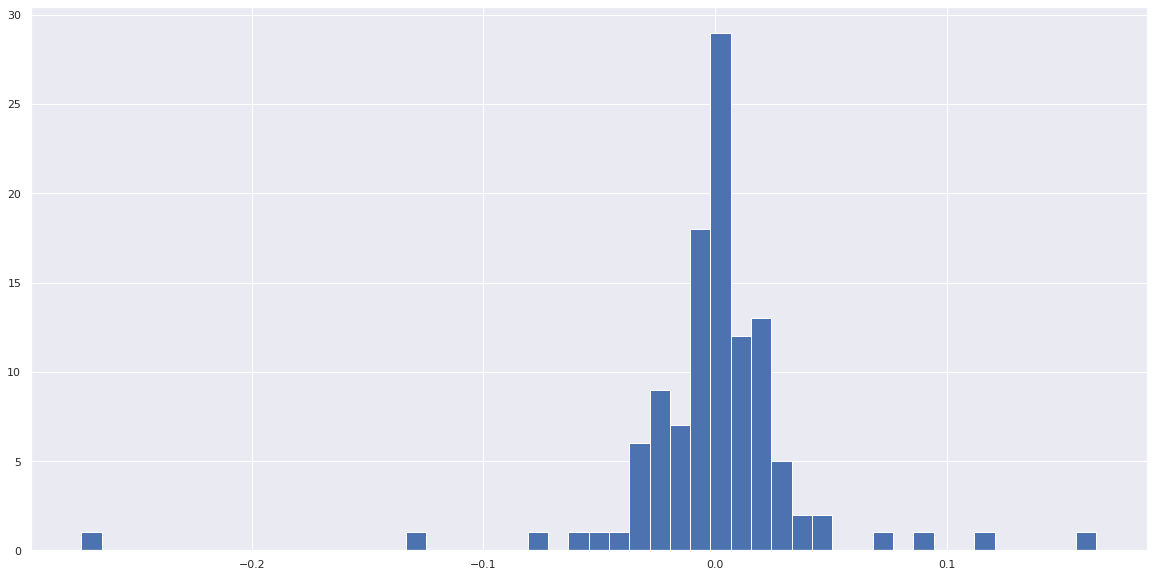

In [117]:
plt.hist(residuo_grad,bins=50);

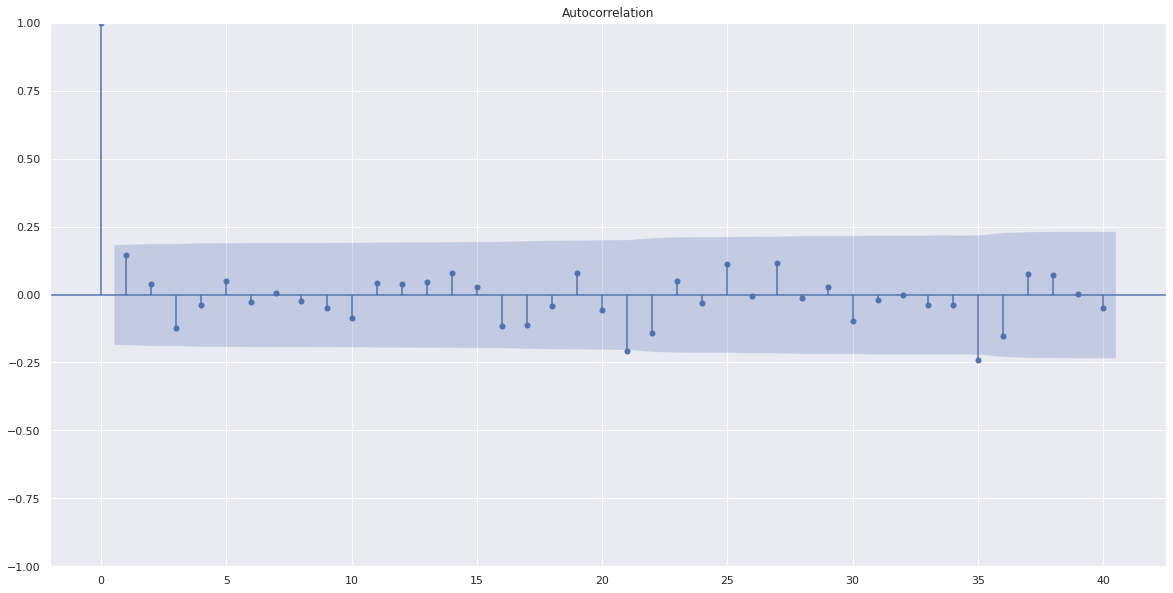

In [118]:
sm.graphics.tsa.plot_acf(residuo_grad,lags=40)
plt.show()

###Redes neurais

In [119]:
predict_redes_treino = model.predict(x_treino)

4/4 [==============================] - 0s 3ms/step


In [120]:
#Retirando um dimensao do array
predict_redes_treino = np.squeeze(predict_redes_treino)
predict_redes_treino

array([ 7.6946917,  7.7002797,  7.6169353,  8.011258 ,  7.954813 ,
        7.4341044,  7.7341905,  7.746387 ,  7.7457266,  7.9408007,
        7.7872148,  7.2888584,  7.3045664,  7.522702 ,  7.4454794,
        7.364763 ,  7.6464844,  7.292203 ,  7.287715 ,  7.5820446,
        7.2873635,  7.3294806,  7.505692 ,  7.2953835,  7.6362686,
        7.295841 ,  7.551573 ,  7.2916455,  7.294026 ,  7.289601 ,
        7.339906 ,  7.2941475,  7.363018 ,  7.508617 ,  7.5747695,
        7.4176393,  7.676908 ,  7.809971 ,  8.173892 ,  8.331596 ,
        8.34256  ,  8.306228 ,  8.472276 ,  9.07525  ,  9.198641 ,
       10.007283 ,  9.5526   ,  9.395298 ,  9.463372 ,  9.740052 ,
        9.785979 ,  9.765353 ,  9.750502 , 10.310142 , 11.387572 ,
       11.585731 , 10.053906 , 11.127111 , 10.861844 , 10.506086 ,
        9.804715 , 10.024304 ,  9.924174 ,  9.795625 , 10.007539 ,
        9.9074   , 10.285635 , 10.511322 ,  9.98178  ,  9.877969 ,
        9.719811 , 10.294111 , 10.198255 ,  9.801957 ,  9.4088

In [121]:
residuo_neurais = y_treino - predict_redes_treino

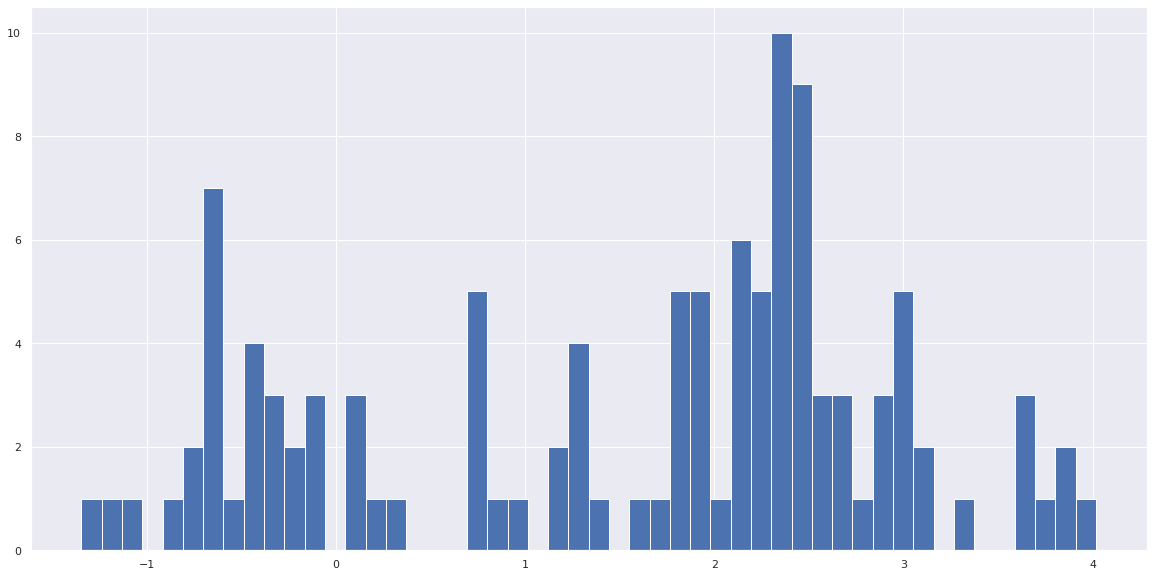

In [122]:
plt.hist(residuo_neurais,bins=50);

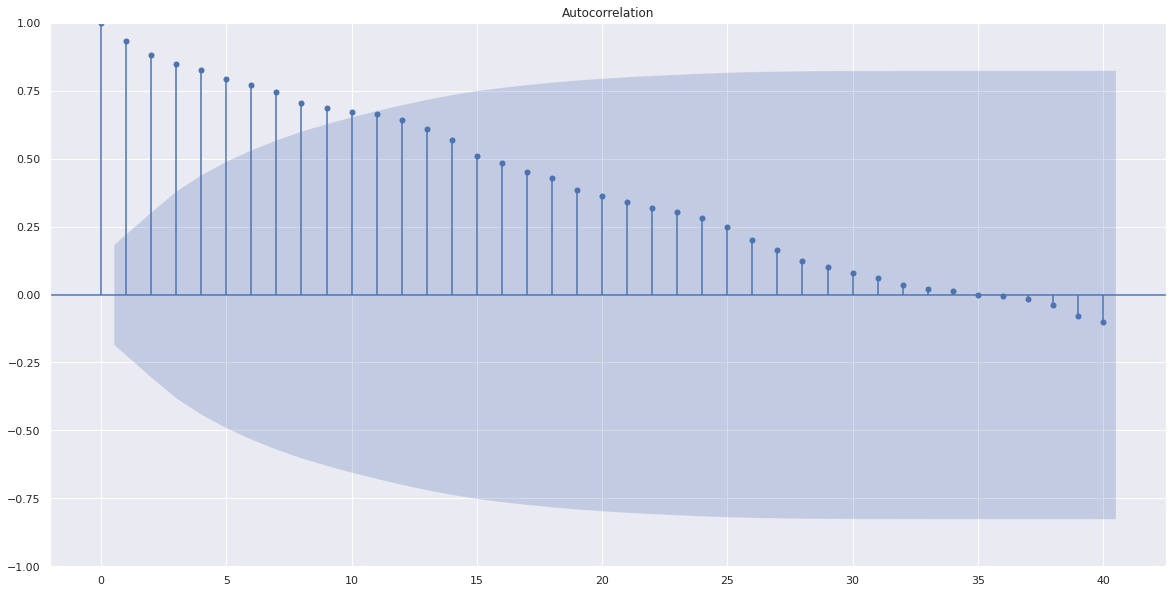

In [123]:
sm.graphics.tsa.plot_acf(residuo_neurais,lags=40)
plt.show()


##Avaliando os dados de treino

In [124]:
metrics_random_treino = evaluate_regression(y_treino,predic_rando_treino, 'Random Forest Regression')
metrics_linear_treino = evaluate_regression(y_treino,predic_treino_lasso, 'Linear Regression')
metrics_grad_treino = evaluate_regression(y_treino,predict_grad_treino, 'Gradiente Boosting Regression')
metrics_redes_treino = evaluate_regression(y_treino,predict_redes_treino, 'Redes Neurais')
metrics_treino = pd.concat([metrics_random_treino, metrics_linear_treino,metrics_grad_treino,metrics_redes_treino])
metrics_treino

MAE  MSE  RMSE   R²
Random Forest Regression      0.16 0.05  0.21 0.99
Linear Regression             1.09 1.50  1.23 0.79
Gradiente Boosting Regression 0.02 0.00  0.04 1.00
Redes Neurais                 1.78 4.27  2.07 0.40

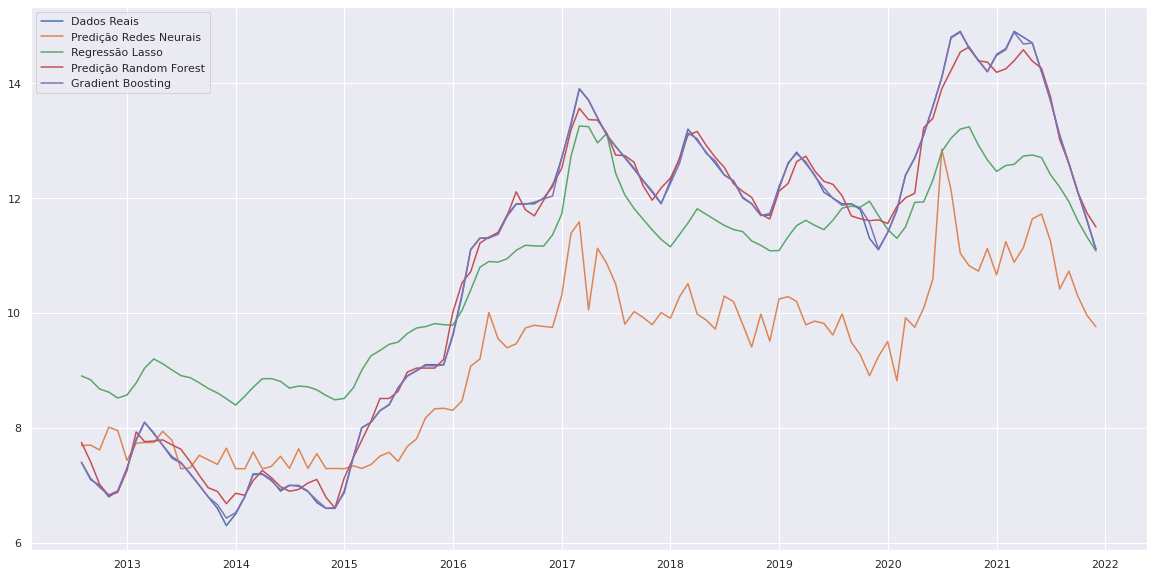

In [125]:
#Plotando as predicoes
plt.plot(treino.index,y_treino,label='Dados Reais')
plt.plot(treino.index,predict_redes_treino,label='Predição Redes Neurais')
plt.plot(treino.index,predic_treino_lasso,label='Regressão Lasso')
plt.plot(treino.index,predic_rando_treino,label='Predição Random Forest')
plt.plot(treino.index,predict_grad_treino,label='Gradient Boosting')
plt.legend();

##Avaliando nos dados de teste

In [126]:
predic_teste_lasso = lasso.predict(x_teste)

In [127]:
predic_rando_teste = rfr.predict(x_teste)

In [128]:
predict_grad_teste = grad_bost.predict(x_teste)

In [129]:
predict_redes_teste = model.predict(x_teste)
predict_redes_teste = np.squeeze(predict_redes_teste)

1/1 [==============================] - 0s 55ms/step


In [130]:
metrics_random_teste = evaluate_regression(y_teste,predic_rando_teste, 'Random Forest Regression')
metrics_linear_teste = evaluate_regression(y_teste,predic_teste_lasso, 'Linear Regression')
metrics_grad_teste = evaluate_regression(y_teste,predict_grad_teste, 'Gradiente Boosting Regression')
metrics_redes_teste = evaluate_regression(y_teste,predict_redes_teste, 'Redes Neurais')
metrics_teste = pd.concat([metrics_random_teste, metrics_linear_teste,metrics_grad_teste,metrics_redes_teste])
metrics_teste

MAE  MSE  RMSE    R²
Random Forest Regression      0.89 1.14  1.07  0.17
Linear Regression             0.86 0.91  0.95  0.34
Gradiente Boosting Regression 0.56 0.47  0.69  0.66
Redes Neurais                 1.02 1.56  1.25 -0.13

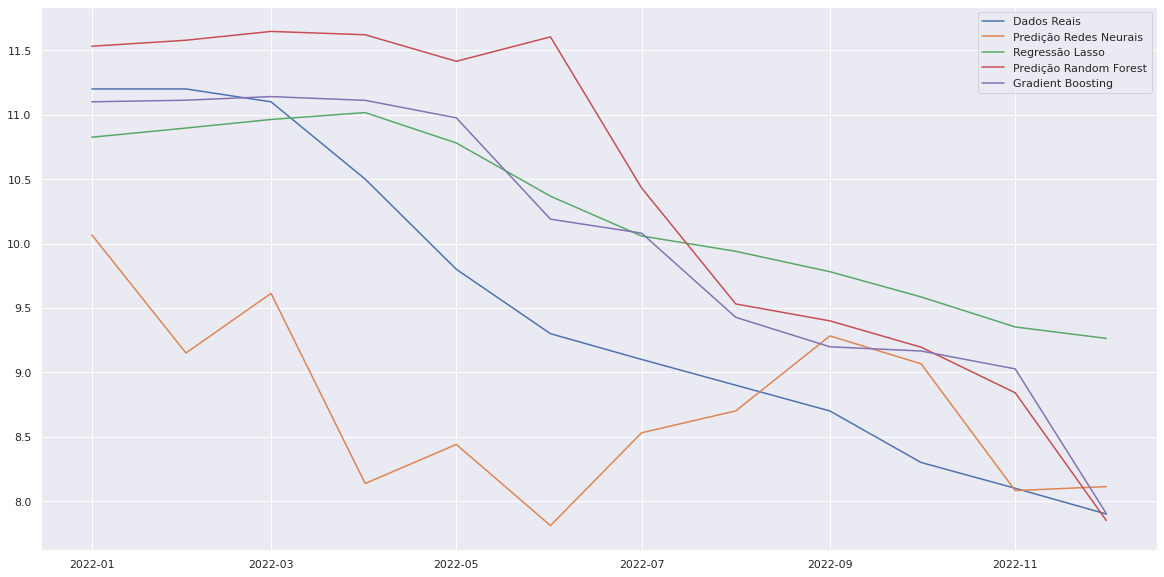

In [131]:
#Plotando as predicoes
plt.plot(teste.index,y_teste,label='Dados Reais')
plt.plot(teste.index,predict_redes_teste,label='Predição Redes Neurais')
plt.plot(teste.index,predic_teste_lasso,label='Regressão Lasso')
plt.plot(teste.index,predic_rando_teste,label='Predição Random Forest')
plt.plot(teste.index,predict_grad_teste,label='Gradient Boosting')
plt.legend();

##Intervalo de previsao

In [132]:
def intervalo_predicao_bootstraps(x_treino,y_treino,modelo_treinado,x_teste,index,predicao,nome_algoritimo,percentiles = [2.5, 97.5],n_bootstraps=1000):
  import numpy as np
  from sklearn.utils import resample

  # Bootstrap
  n_samples = len(x_treino)
  bootstrapped_predictions = np.zeros((n_bootstraps, len(x_teste)))
  
  if nome_algoritimo == 'Redes Neurais':
    for i in range(n_bootstraps):
      bootstrapped_data = resample(np.column_stack((x_treino, y_treino)), replace=True, n_samples=n_samples, random_state=i)
      bootstrapped_x_train, bootstrapped_y_train = bootstrapped_data[:, :-1], bootstrapped_data[:, -1]
      bootstrapped_model = modelo_treinado.fit(bootstrapped_x_train, bootstrapped_y_train, epochs=100,batch_size=100,verbose=0)
      bootstrapped_predictions[i] = np.squeeze(model.predict(x_teste))
  else:
    for i in range(n_bootstraps):
      bootstrapped_data = resample(np.column_stack((x_treino, y_treino)), replace=True, n_samples=n_samples, random_state=i)
      bootstrapped_x_train, bootstrapped_y_train = bootstrapped_data[:, :-1], bootstrapped_data[:, -1]
      bootstrapped_model = modelo_treinado.fit(bootstrapped_x_train, bootstrapped_y_train)
      bootstrapped_predictions[i] = bootstrapped_model.predict(x_teste)

  # Calcula intervalos de previsão
  lower = np.percentile(bootstrapped_predictions, percentiles[0], axis=0)
  upper = np.percentile(bootstrapped_predictions, percentiles[1], axis=0)

  intervalos = pd.DataFrame(index=index)
  intervalos['Predicao'] = predicao
  intervalos[f'lower({percentiles[0]})'] = lower
  intervalos[f'upper({percentiles[1]})'] = upper

  import matplotlib.pyplot as plt

  plt.plot(index,predicao,'*')
  plt.fill_between(index,lower, upper, color='gray', alpha=0.5, label=f'Intervalo de confiança de {percentiles[1]-percentiles[0]}%')
  plt.legend()
  plt.xlabel('Datas')
  plt.ylabel('Predição')
  plt.title('Previsões com intervalo de confiança para a'+' '+nome_algoritimo)
  plt.show()
  return intervalos

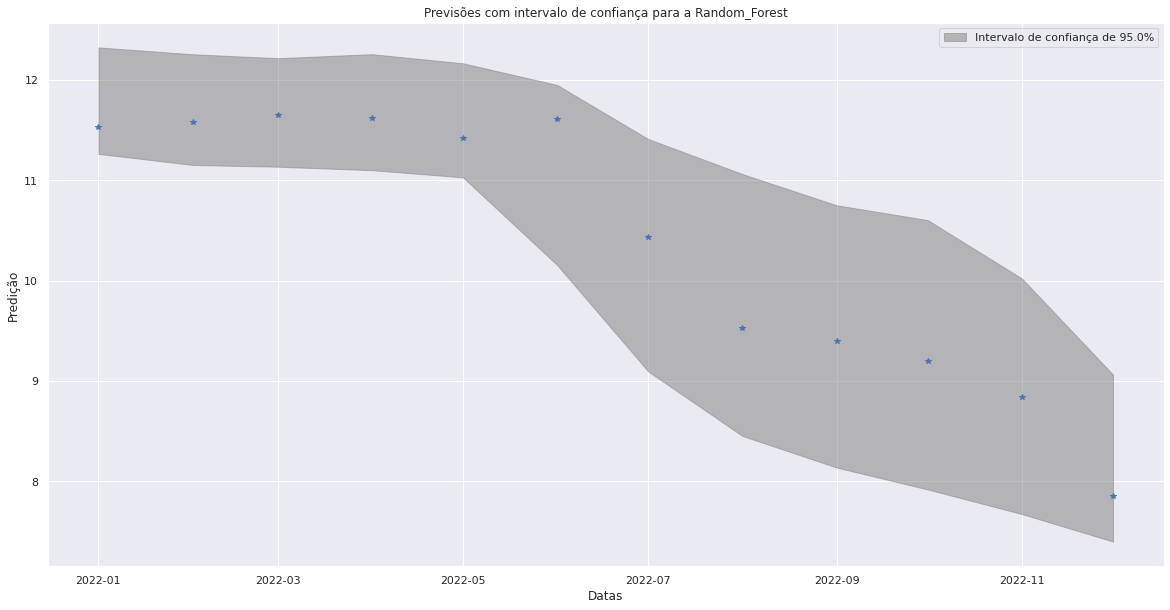

In [133]:
intervalo_random = intervalo_predicao_bootstraps(x_treino,y_treino,rfr,x_teste,teste.index,predic_rando_teste,'Random_Forest')

In [134]:
intervalo_random

Predicao  lower(2.5)  upper(97.5)
2022-01-01     11.53       11.26        12.32
2022-02-01     11.58       11.15        12.25
2022-03-01     11.65       11.13        12.21
2022-04-01     11.62       11.10        12.25
2022-05-01     11.41       11.03        12.16
2022-06-01     11.60       10.15        11.95
2022-07-01     10.43        9.10        11.41
2022-08-01      9.53        8.45        11.06
2022-09-01      9.40        8.14        10.75
2022-10-01      9.20        7.92        10.60
2022-11-01      8.84        7.67        10.02
2022-12-01      7.85        7.40         9.06

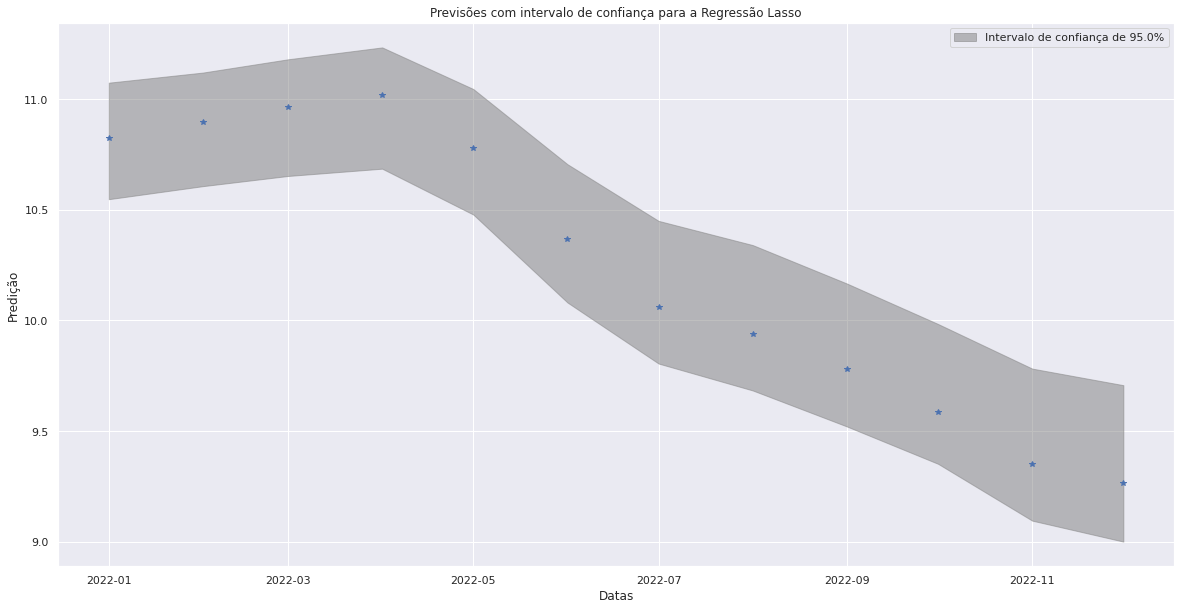

In [135]:
intervalo_lasso = intervalo_predicao_bootstraps(x_treino,y_treino,lasso,x_teste,teste.index,predic_teste_lasso,'Regressão Lasso')

In [136]:
intervalo_lasso

Predicao  lower(2.5)  upper(97.5)
2022-01-01     10.83       10.55        11.07
2022-02-01     10.90       10.61        11.12
2022-03-01     10.96       10.65        11.18
2022-04-01     11.02       10.69        11.23
2022-05-01     10.78       10.48        11.05
2022-06-01     10.37       10.08        10.71
2022-07-01     10.06        9.81        10.45
2022-08-01      9.94        9.68        10.34
2022-09-01      9.78        9.52        10.17
2022-10-01      9.59        9.35         9.98
2022-11-01      9.35        9.10         9.78
2022-12-01      9.26        9.00         9.71

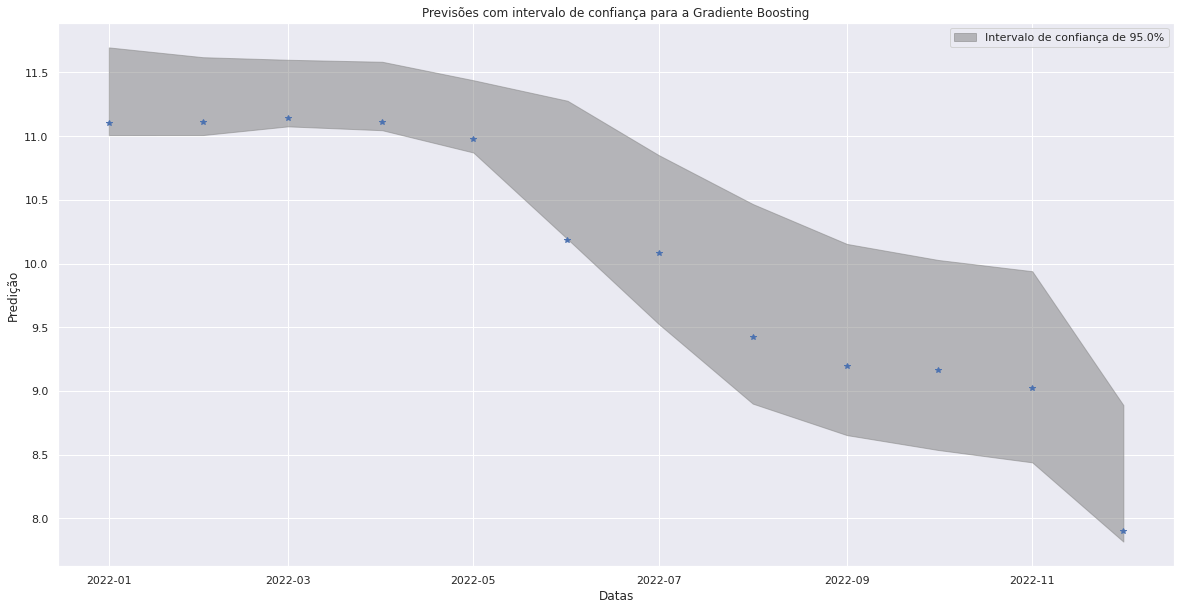

In [137]:
intervalo_grad = intervalo_predicao_bootstraps(x_treino,y_treino,grad_bost,x_teste,teste.index,predict_grad_teste,'Gradiente Boosting',n_bootstraps=100)

In [138]:
intervalo_grad

Predicao  lower(2.5)  upper(97.5)
2022-01-01     11.10       11.01        11.70
2022-02-01     11.11       11.01        11.62
2022-03-01     11.14       11.08        11.60
2022-04-01     11.11       11.05        11.58
2022-05-01     10.98       10.87        11.44
2022-06-01     10.19       10.19        11.28
2022-07-01     10.08        9.53        10.85
2022-08-01      9.43        8.90        10.47
2022-09-01      9.20        8.65        10.15
2022-10-01      9.17        8.54        10.03
2022-11-01      9.03        8.44         9.94
2022-12-01      7.90        7.82         8.89

1/1 [==============================] - 0s 16ms/step


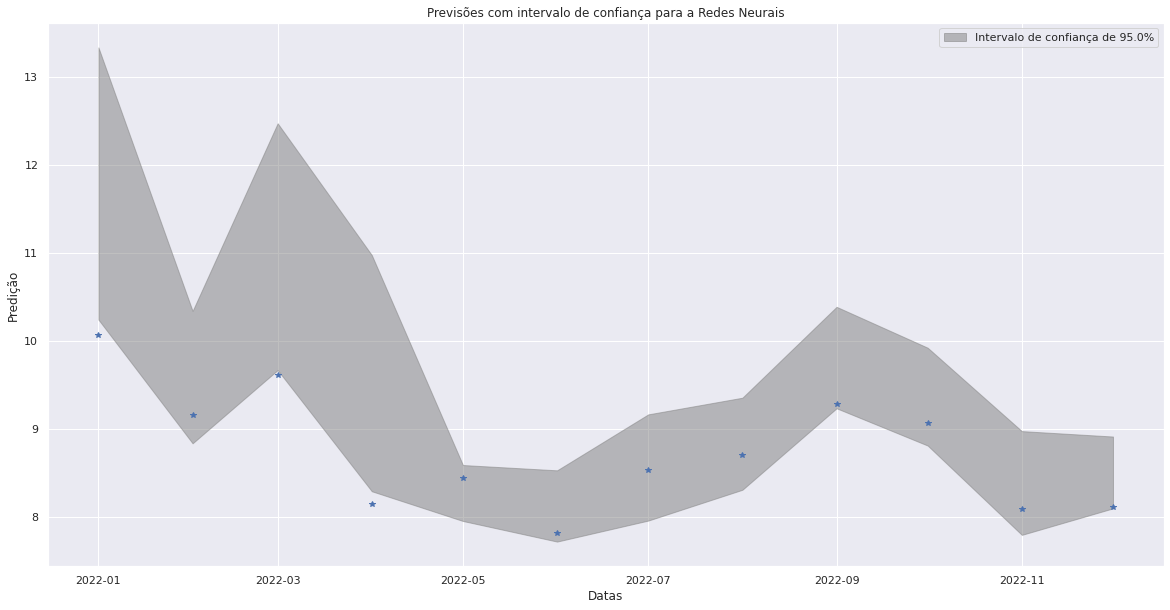

In [139]:
intervalo_redes = intervalo_predicao_bootstraps(x_treino,y_treino,model,x_teste,teste.index,predict_redes_teste,'Redes Neurais',n_bootstraps=20)

In [140]:
intervalo_redes

Predicao  lower(2.5)  upper(97.5)
2022-01-01     10.07       10.24        13.33
2022-02-01      9.15        8.83        10.34
2022-03-01      9.61        9.66        12.47
2022-04-01      8.14        8.29        10.97
2022-05-01      8.44        7.95         8.59
2022-06-01      7.81        7.71         8.52
2022-07-01      8.53        7.95         9.16
2022-08-01      8.70        8.30         9.35
2022-09-01      9.28        9.23        10.38
2022-10-01      9.07        8.81         9.92
2022-11-01      8.08        7.79         8.97
2022-12-01      8.11        8.09         8.91

##Predicao valores

In [141]:
dados_predicao

Indicador de Incerteza da Economia Brasileira  \
2023-01-01                                           0.60   
2023-02-01                                          -1.60   
2023-03-01                                          -1.60   

            Indicador Antecedente de Emprego  seguro_desemprego  fgts  \
2023-01-01                             -0.80               4.00 11.00   
2023-02-01                              0.82               4.00  9.00   
2023-03-01                              0.82               3.00 10.00   

            empregos  inss    ibc  selic  dummy_covid  \
2023-01-01      1.00  7.00 142.95   0.00            0   
2023-02-01      0.00 -5.00 142.95   0.00            0   
2023-03-01      0.00  3.00 142.95   0.00            0   

            taxa_desocupacao_lags_1  ...  taxa_desocupacao_lags_4  \
2023-01-01                     7.90  ...                     8.70   
2023-02-01                     7.90  ...                     8.30   
2023-03-01                     7.90  ...                     8.10   

            Indicador de Incerteza da Economia Brasileira_lags_4  \
2023-01-01                                              -4.90      
2023-02-01                                               0.30      
2023-03-01                                               0.10      

            Indicador Antecedente de Emprego_lags_4  seguro_desemprego_lags_4  \
2023-01-01                                     1.50                      3.00   
2023-02-01                                    -4.00                      3.00   
2023-03-01                                    -6.70                      3.00   

            fgts_lags_4  empregos_lags_4  inss_lags_4  ibc_lags_4  \
2023-01-01         7.00            -1.00         4.00       -0.32   
2023-02-01         7.00             0.00        -6.00       -0.62   
2023-03-01         7.00             0.00         1.00       -1.11   

            selic_lags_4  dummy_covid_lags_4  
2023-01-01          0.07                0.00  
2023-02-01          0.00                0.00  
2023-03-01          0.00                0.00  

[3 rows x 49 columns]

In [142]:
#replicar o ultimo numero para os valores faltantes
dados_predicao = dados_predicao.fillna(method='ffill')
dados_predicao['ibc'].fillna(dados['ibc'][dados['ibc'].last_valid_index()],inplace=True)
dados_predicao

Indicador de Incerteza da Economia Brasileira  \
2023-01-01                                           0.60   
2023-02-01                                          -1.60   
2023-03-01                                          -1.60   

            Indicador Antecedente de Emprego  seguro_desemprego  fgts  \
2023-01-01                             -0.80               4.00 11.00   
2023-02-01                              0.82               4.00  9.00   
2023-03-01                              0.82               3.00 10.00   

            empregos  inss    ibc  selic  dummy_covid  \
2023-01-01      1.00  7.00 142.95   0.00            0   
2023-02-01      0.00 -5.00 142.95   0.00            0   
2023-03-01      0.00  3.00 142.95   0.00            0   

            taxa_desocupacao_lags_1  ...  taxa_desocupacao_lags_4  \
2023-01-01                     7.90  ...                     8.70   
2023-02-01                     7.90  ...                     8.30   
2023-03-01                     7.90  ...                     8.10   

            Indicador de Incerteza da Economia Brasileira_lags_4  \
2023-01-01                                              -4.90      
2023-02-01                                               0.30      
2023-03-01                                               0.10      

            Indicador Antecedente de Emprego_lags_4  seguro_desemprego_lags_4  \
2023-01-01                                     1.50                      3.00   
2023-02-01                                    -4.00                      3.00   
2023-03-01                                    -6.70                      3.00   

            fgts_lags_4  empregos_lags_4  inss_lags_4  ibc_lags_4  \
2023-01-01         7.00            -1.00         4.00       -0.32   
2023-02-01         7.00             0.00        -6.00       -0.62   
2023-03-01         7.00             0.00         1.00       -1.11   

            selic_lags_4  dummy_covid_lags_4  
2023-01-01          0.07                0.00  
2023-02-01          0.00                0.00  
2023-03-01          0.00                0.00  

[3 rows x 49 columns]

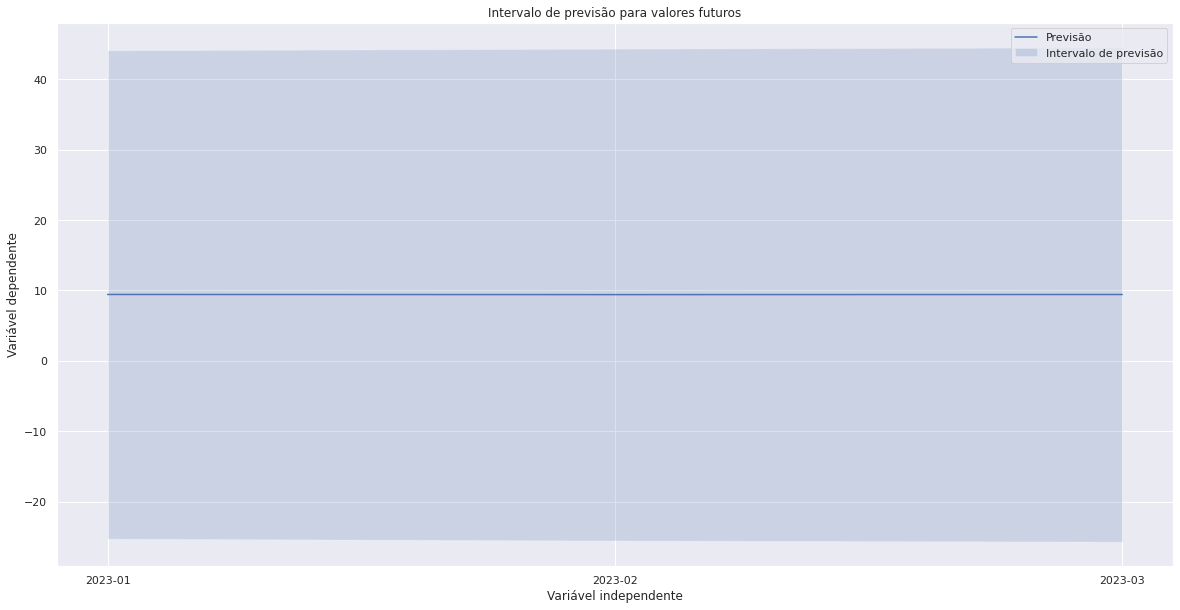

In [143]:
import numpy as np
import matplotlib.pyplot as plt

# gerar a faixa de valores de predição
X_pred = np.linspace(0, 10, 100).reshape(-1, 1) # aqui estamos gerando 100 pontos igualmente espaçados entre 0 e 10

# fazer as previsões para a faixa de valores
predicao_lasso = lasso.predict(dados_predicao.values)

# calcular o desvio padrão dos resíduos
desvio_padrao_residuos = np.std(residuo_lasso)

# calcular o intervalo de previsão para a faixa de valores
nivel_confianca = 0.95
z = 1.96 # valor crítico para um nível de confiança de 95%
intervalo_previsao = z * desvio_padrao_residuos * np.sqrt(1 + np.diag(np.dot(dados_predicao.values, np.dot(np.linalg.inv(np.dot(x_treino.T, x_treino)), dados_predicao.values.T))))

index = dados_predicao.index.strftime('%Y-%m')
intervalos = pd.DataFrame()
intervalos['predicao'] = predicao_lasso
intervalos['nivel_baixo'] = (predicao_lasso - intervalo_previsao)
intervalos['nivel_alto'] = (predicao_lasso + intervalo_previsao) 

index = dados_predicao.index.strftime('%Y-%m')
# plotar a faixa de valores e o intervalo de previsão correspondente
plt.plot(index, predicao_lasso, label='Previsão')
plt.fill_between(index,predicao_lasso - intervalo_previsao, predicao_lasso + intervalo_previsao, alpha=0.2, label='Intervalo de previsão')
plt.legend()
plt.xlabel('Variável independente')
plt.ylabel('Variável dependente')
plt.title('Intervalo de previsão para valores futuros')
plt.show()


In [144]:
def intervalo_predicao(residuo,dados_predicao,x_treino,predicao,nivel_confianca):
  import numpy as np
  import matplotlib.pyplot as plt

  # gerar a faixa de valores de predição
  X_pred = np.linspace(0, 10, 100).reshape(-1, 1) # aqui estamos gerando 100 pontos igualmente espaçados entre 0 e 10

  # calcular o desvio padrão dos resíduos
  desvio_padrao_residuos = np.std(residuo)

  # calcular o intervalo de previsão para a faixa de valores
  # calcular o intervalo de previsão para a faixa de valores
  z = 0.0
  if nivel_confianca == 0.95:
    z = 1.96 # valor crítico para um nível de confiança de 95%
  elif nivel_confianca == 0.90:
    z = 1.645 # valor crítico para um nível de confiança de 90%
  else:
    z = 1.0 # valor crítico para um nível de confiança de 68%

  intervalo_previsao = z * desvio_padrao_residuos * np.sqrt(1 + np.diag(np.dot(dados_predicao.values, np.dot(np.linalg.inv(np.dot(x_treino.T, x_treino)), dados_predicao.values.T))))
  
  index = dados_predicao.index.strftime('%Y-%m')
  intervalos = pd.DataFrame()
  intervalos['predicao'] = predicao
  intervalos[f'nivel_baixo({nivel_confianca})'] = (predicao - intervalo_previsao)
  intervalos[f'nivel_alto({nivel_confianca})'] = (predicao + intervalo_previsao) 
    # plotar a faixa de valores e o intervalo de previsão correspondente
  plt.plot(index, predicao, label='Previsão')
  plt.fill_between(index,predicao - intervalo_previsao, predicao + intervalo_previsao, alpha=0.2, label='Intervalo de previsão')
  plt.legend()
  plt.xlabel('Variável independente')
  plt.ylabel('Variável dependente')
  plt.title(f'Intervalo de previsão para valores futuros de {nivel_confianca}')
  plt.show()

  return intervalos

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


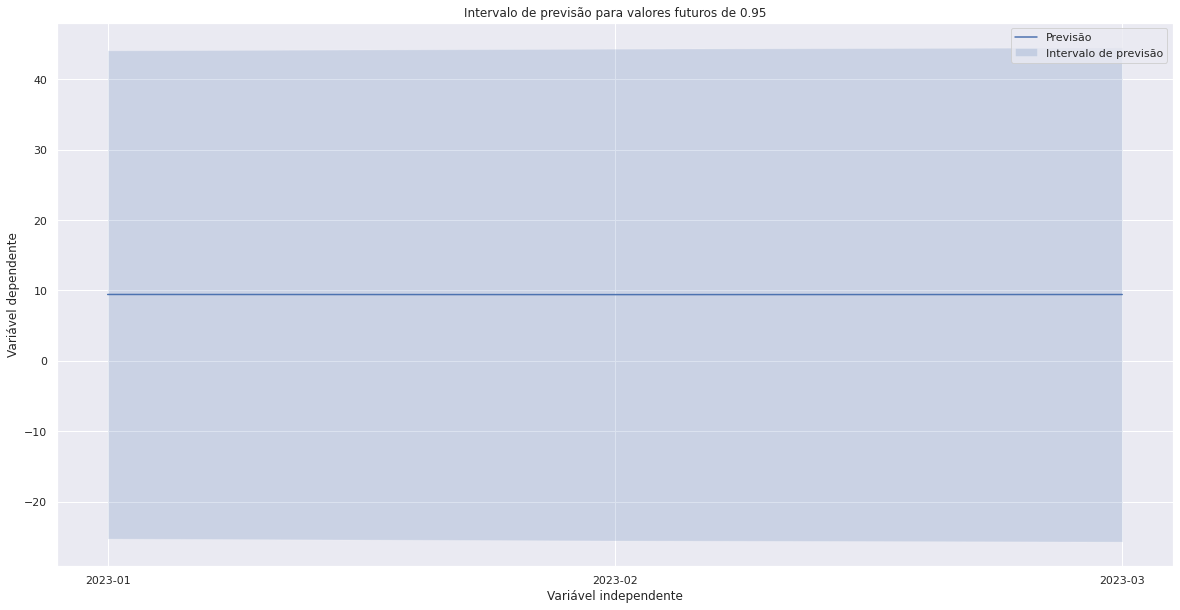

predicao  nivel_baixo(0.95)  nivel_alto(0.95)
0      9.43             -25.26             44.11
1      9.40             -25.53             44.34
2      9.42             -25.69             44.53

In [145]:
predicao_lasso = lasso.predict(dados_predicao)
intervalos_lasso = intervalo_predicao(residuo_lasso,dados_predicao,x_treino,predicao_lasso,0.95)
intervalos_lasso

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


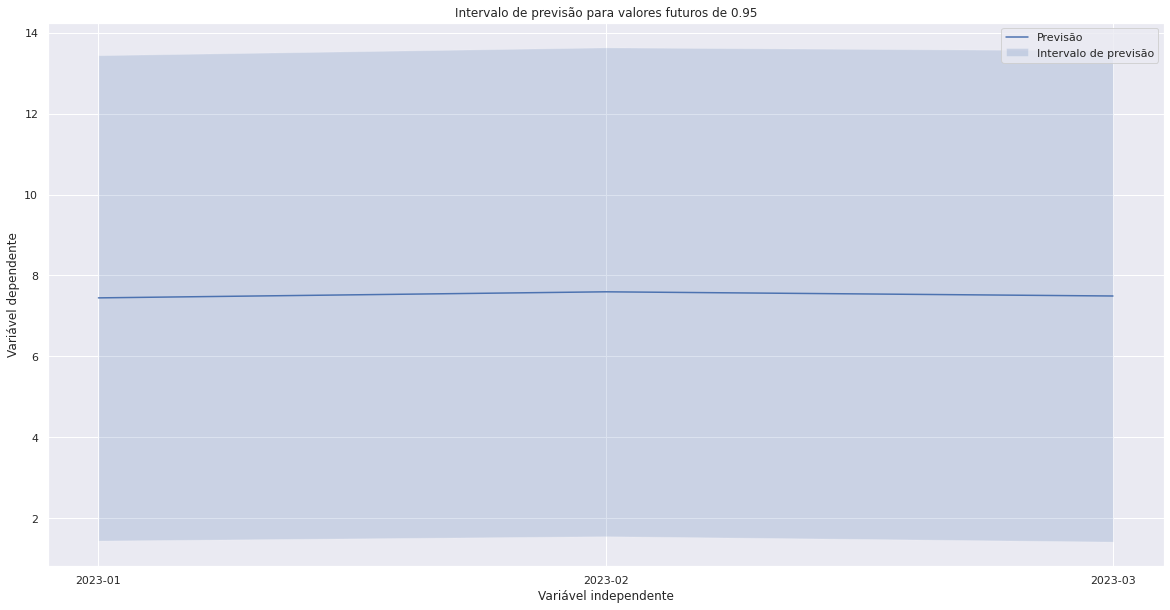

predicao  nivel_baixo(0.95)  nivel_alto(0.95)
0      7.45               1.45             13.44
1      7.60               1.56             13.64
2      7.49               1.42             13.56

In [146]:
predicao_random = rfr.predict(dados_predicao)
intervalos_random = intervalo_predicao(residuo_random,dados_predicao,x_treino,predicao_random,0.95)
intervalos_random

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


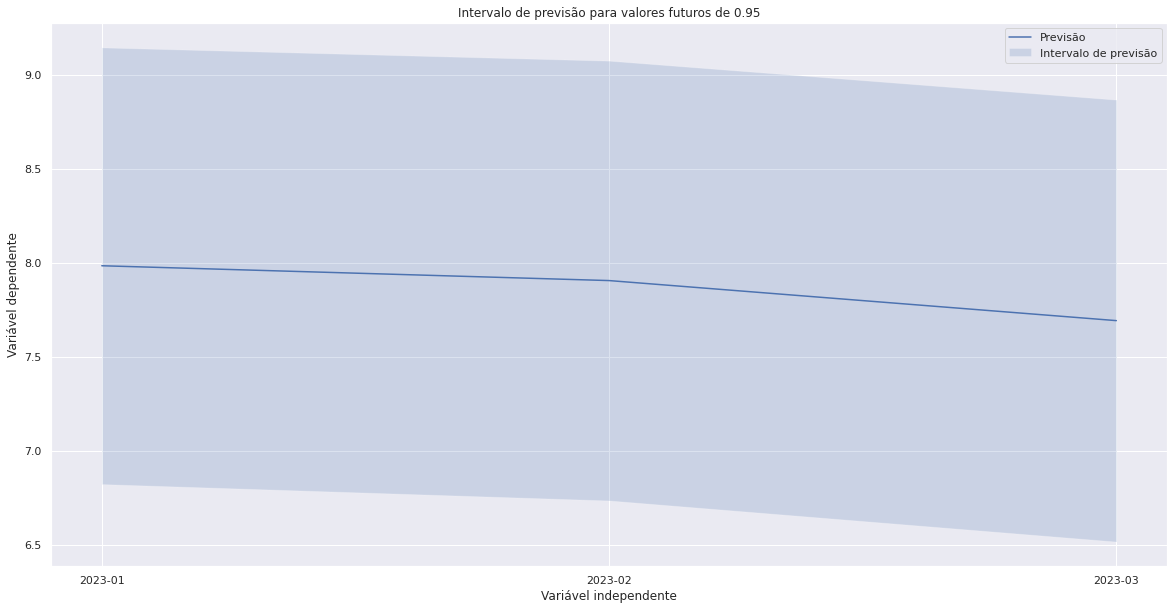

predicao  nivel_baixo(0.95)  nivel_alto(0.95)
0      7.98               6.82              9.15
1      7.91               6.74              9.08
2      7.69               6.52              8.87

In [150]:
predicao_boost = grad_bost.predict(dados_predicao)
intervalos_boost= intervalo_predicao(residuo_grad,dados_predicao,x_treino,predicao_boost,0.95)
intervalos_boost

1/1 [==============================] - 0s 123ms/step


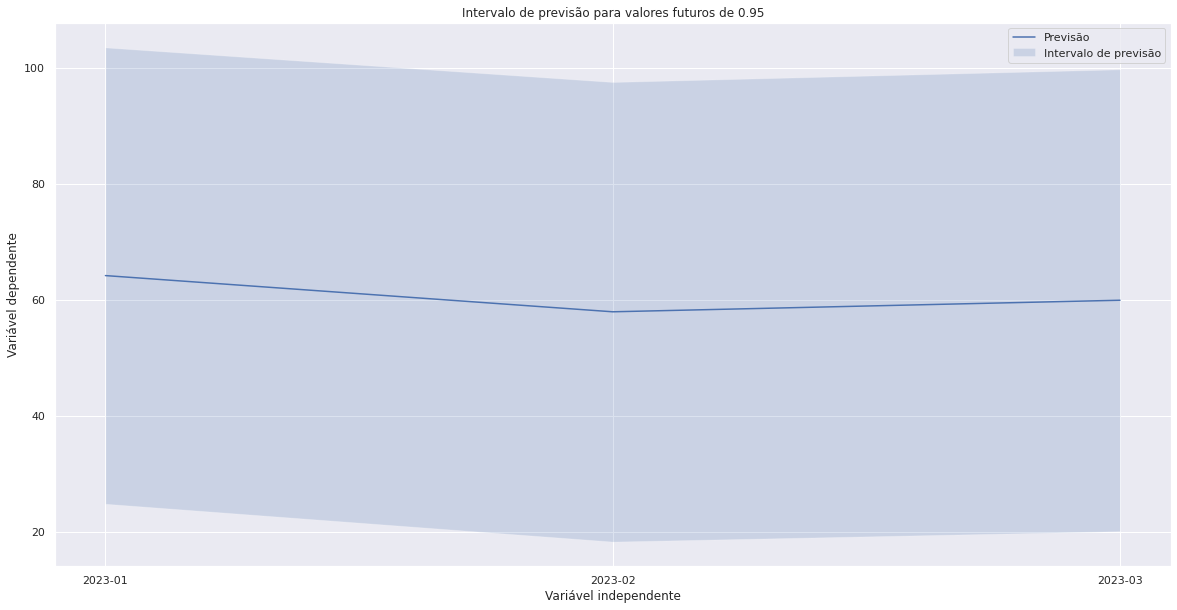

predicao  nivel_baixo(0.95)  nivel_alto(0.95)
0     64.16              24.81            103.50
1     57.91              18.29             97.54
2     59.91              20.09             99.72

In [148]:
predicao_redes = np.squeeze(model.predict(dados_predicao))
intervalos_redes= intervalo_predicao(residuo_neurais,dados_predicao,x_treino,predicao_redes,0.95)
intervalos_redes